## Imports

In [1]:
import sys 
import os
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io
import math
import copy

import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.dataset import Dataset
sys.path.insert(0, '../../Utils')

import models
from train import *
from metrics import * 
#from Gradient_Ascent import data_extraction
from skimage.restoration import denoise_nl_means, estimate_sigma

from PIL import Image
import pdb

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

Python: 3.7.2 (default, Feb 21 2019, 17:35:59) [MSC v.1915 64 bit (AMD64)]
Pytorch: 1.4.0+cu92


## Hyperparameters

In [2]:
n_epochs = 40
batch_size = 32
lr = 0.01
groups = 2

## Load ATT

In [3]:
class ATTdataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform        
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    def __getitem__(self, idx): 
        
        image = np.empty((112, 92, 1), dtype=np.uint8)
        img_path = self.file_list[idx]
        im = io.imread(img_path)
        im = im.reshape(112,92)
        image[:,:,0]= im
#         image[:,:,1]= im
#         image[:,:,2]= im
        # pdb.set_trace()
        label = self.people_to_idx[img_path.split('\\')[-2]]
        
        if self.transform is not None: 
            image = self.transform(image)
        
        return image, label
        

# Data augmentation 
train_transform = torchvision.transforms.Compose([

#     torchvision.transforms.ToPILImage(),
#     torchvision.transforms.CenterCrop((92,92)),    
#     torchvision.transforms.Resize((128,128)),
    torchvision.transforms.ToTensor(),

    
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = torchvision.transforms.Compose([
    
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])
    

### Effort to do cross validation (groups)

In [4]:
data_dir = "..\\..\\attfaces"

img_paths = []
for p in os.listdir(data_dir): 
    for i in os.listdir(os.path.join(data_dir,p)): 
        img_paths.append(os.path.join(data_dir,p,i))
        
people = []
people_to_idx = {}
idx_to_people = {}
sample_paths = []
k = 0 
for i in img_paths: 
    name = i.split('\\')[-2]
    if name not in people_to_idx: 
        people.append(name)
        people_to_idx[name] = k
        idx_to_people[k] = name
        k += 1
        sample_paths.append(i)

img_paths = np.random.permutation(img_paths)
print(type(img_paths))
lfw_size = len(img_paths)
lfw_group_size = math.floor(lfw_size*1.0/groups)
print(lfw_group_size)

kflists = [] # k-fold cross validation
for i in range(groups):
    start = 0 + i*lfw_group_size
    end = 0 + (i+1)*lfw_group_size
    kflists.append(img_paths[start:end])
    
# tmp1 = img_paths[0:4]
# tmp2 = img_paths[4:8]
# print(np.hstack(tmp1,tmp2))

# trainset = ATTdataset(lfw_train_list, people_to_idx, transform=train_transform)
# testset = ATTdataset(lfw_test_list, people_to_idx, transform=test_transform)
sampleset = ATTdataset(sample_paths, people_to_idx, transform=torchvision.transforms.ToTensor())

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
# testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
sampleloader = torch.utils.data.DataLoader(sampleset, batch_size=40, shuffle=False, num_workers=0)

<class 'numpy.ndarray'>
200


<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> torch.Size([3, 572, 754])
<class 'numpy.ndarray'> (3, 572, 754)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39])
tensor(0.)
tensor(0.9569)
torch.Size([40, 1, 112, 92])


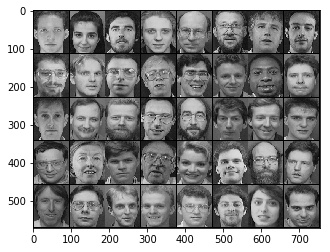

In [5]:
# helper function to unnormalize and plot image 
def imshow(img, name):
    print(type(img), img.shape)
    img = np.array(img)
    #img = img / 2 + 0.5
    print(type(img), img.shape)
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    plt.imsave('.\\'+name, img)
    
# display sample from dataset 
imgs,labels = iter(sampleloader).next()
print(type(imgs), type(torchvision.utils.make_grid(imgs)))
imshow(torchvision.utils.make_grid(imgs),'origin') 
print(labels)
print(imgs.min())
print(imgs.max())
print(imgs.shape)

## Model Architecture

In [6]:
class mlp(nn.Module): 
    def __init__(self, n_in=112*92, n_out=40, n_hidden=3000): 
        super(mlp, self).__init__()
        self.hidden1 = nn.Linear(n_in, n_out)        

    def forward(self, x):
        x = x.view(-1,112*92)
        out = self.hidden1(x)
        return out

In [7]:
# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# net = mlp().to(device)
# net.apply(models.weights_init)

# net2 = mlp().to(device)
# net2.apply(models.weights_init)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=lr)
# optimizer2 = optim.SGD(net2.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)


# ww0 = copy.deepcopy(net2.hidden1.weight.data)
# bb = copy.deepcopy(net2.hidden1.bias.data[:])
# #im0 = ww0[34].reshape(112,92)

## Training 

In [8]:
ww0_shape = nn.Linear(112*92, 40) .weight.data.shape
print(ww0_shape)
groups_ww0_shape = torch.Size([groups]) + ww0_shape
print(groups_ww0_shape)
groups_ww0 = torch.randn(groups_ww0_shape).to(device)
groups_ww = torch.randn(groups_ww0_shape).to(device)

torch.Size([40, 10304])
torch.Size([2, 40, 10304])


In [12]:
train_accs = torch.zeros(torch.Size([groups])).to(device)
test_accs = torch.zeros(torch.Size([groups])).to(device)
i = 0
print("k-fold cross validation: ", i)
trainlist = []
for j in range(groups):
    if j != i:
        trainlist = np.concatenate((trainlist, kflists[j]))
testlist = kflists[i]
trainset = ATTdataset(trainlist, people_to_idx, transform=train_transform)
testset = ATTdataset(testlist, people_to_idx, transform=test_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
net2 = mlp().to(device)
net2.apply(models.weights_init)
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(net2.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
groups_ww0[i] = copy.deepcopy(net2.hidden1.weight.data)
train_accs[i], test_accs[i] = train(net2, trainloader, testloader, optimizer2, criterion, n_epochs, verbose=False)
groups_ww[i] = net2.hidden1.weight.data[:]

print("train accuracy:", torch.mean(train_accs).data)
print("test accuracy:", torch.mean(test_accs).data)

print(groups_ww0.shape)
ww0 = groups_ww0[i]
print(ww0.shape)
ww = groups_ww[i]

k-fold cross validation:  0
[0/40]
Train Accuracy = 3.50 %; Test Accuracy = 3.00 %
[1/40]
Train Accuracy = 14.50 %; Test Accuracy = 6.50 %
[2/40]
Train Accuracy = 23.00 %; Test Accuracy = 9.50 %
[3/40]
Train Accuracy = 39.50 %; Test Accuracy = 24.50 %
[4/40]
Train Accuracy = 51.50 %; Test Accuracy = 32.50 %
[5/40]
Train Accuracy = 73.50 %; Test Accuracy = 48.50 %
[6/40]
Train Accuracy = 83.50 %; Test Accuracy = 59.00 %
[7/40]
Train Accuracy = 87.50 %; Test Accuracy = 63.50 %
[8/40]
Train Accuracy = 98.00 %; Test Accuracy = 77.50 %
[9/40]
Train Accuracy = 94.50 %; Test Accuracy = 80.50 %
[10/40]
Train Accuracy = 94.00 %; Test Accuracy = 73.50 %
[11/40]
Train Accuracy = 96.50 %; Test Accuracy = 81.50 %
[12/40]
Train Accuracy = 98.50 %; Test Accuracy = 89.00 %
[13/40]
Train Accuracy = 98.00 %; Test Accuracy = 81.50 %
[14/40]
Train Accuracy = 97.50 %; Test Accuracy = 86.00 %
[15/40]
Train Accuracy = 100.00 %; Test Accuracy = 92.00 %
[16/40]
Train Accuracy = 94.50 %; Test Accuracy = 72.50 %

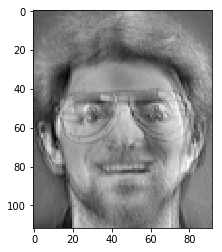

In [13]:
i = 37
im0 = ww0[i,:].reshape(1,1,112,92)
im_train = ww[i,:].reshape(1,1,112,92)
plt.imshow((im_train-im0).squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

real_imgs_size = torch.Size([40,1,112,92])
real_imgs = torch.zeros(real_imgs_size)
for i in range(40):
    im0 = ww0[i,:].reshape(1,1,112,92)
    im_train = ww[i,:].reshape(1,1,112,92)
    real_imgs[i] = im_train-im0

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1524, 1.1523, 1.1523, 1.1518, 1.1528, 1.1517, 1.1526, 1.1528, 1.1519,
        1.1522, 1.1524, 1.1515, 1.1521, 1.1522, 1.1525, 1.1518, 1.1522, 1.1522,
        1.1526, 1.1522, 1.1528, 1.1524, 1.1518, 1.1519, 1.1520, 1.1524, 1.1524,
        1.1526, 1.1522, 1.1518, 1.1523, 1.1523, 1.1523, 1.1522, 1.1521, 1.1522,
        1.1516, 1.1522, 1.1525, 1.1523, 1.1519, 1.1524, 1.1528, 1.1534, 1.1523,
        1.1518, 1.1527, 1.1528, 1.1523, 1.1527, 1.1518, 1.1526, 1.1524, 1.1523,
        1.1518, 1.1524, 1.1519, 1.1526, 1.1520, 1.1521

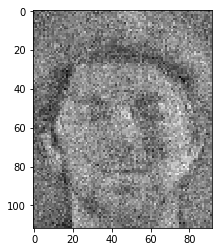


 time for epoch 0 is 22.913702249526978
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1538, 1.1534, 1.1531, 1.1530, 1.1529, 1.1528, 1.1528, 1.1528, 1.1528,
        1.1528, 1.1528, 1.1528, 1.1528, 1.1527, 1.1527, 1.1527, 1.1527, 1.1527,
        1.1527, 1.1527, 1.1530, 1.1524, 1.1527, 1.1530, 1.1520, 1.1528, 1.1522,
        1.1533, 1.1526, 1.1527, 1.1524, 1.1531, 1.1521, 1.1529, 1.1526, 1.1523,
        1.1528, 1.1528, 1.1524, 1.1527, 1.1521, 1.1522, 1.1523, 1.1521, 1.1525,
        1.1531, 1.1522, 1.1526, 1.1526, 1.1524, 1.1528, 1.1522, 1.1526, 1.1529,
        1.152

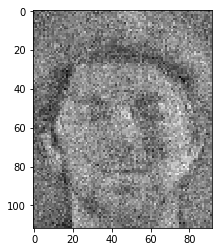


 time for epoch 1 is 23.254790544509888
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1538, 1.1534, 1.1534, 1.1533, 1.1532, 1.1531, 1.1531, 1.1531, 1.1531,
        1.1531, 1.1530, 1.1530, 1.1530, 1.1530, 1.1530, 1.1530, 1.1529, 1.1529,
        1.1529, 1.1529, 1.1526, 1.1529, 1.1528, 1.1530, 1.1526, 1.1527, 1.1530,
        1.1532, 1.1535, 1.1528, 1.1527, 1.1529, 1.1523, 1.1527, 1.1534, 1.1532,
        1.1528, 1.1532, 1.1530, 1.1524, 1.1526, 1.1536, 1.1526, 1.1527, 1.1530,
        1.1527, 1.1526, 1.1528, 1.1523, 1.1528, 1.1523, 1.1527, 1.1532, 1.1526,
        1.152

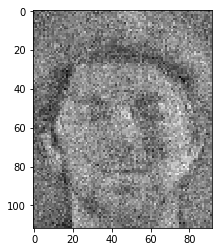


 time for epoch 2 is 22.52674889564514
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1538, 1.1537, 1.1536, 1.1535, 1.1535, 1.1534, 1.1534, 1.1534, 1.1533,
        1.1533, 1.1533, 1.1533, 1.1532, 1.1532, 1.1532, 1.1532, 1.1532, 1.1532,
        1.1531, 1.1531, 1.1537, 1.1527, 1.1535, 1.1533, 1.1534, 1.1529, 1.1531,
        1.1528, 1.1532, 1.1533, 1.1526, 1.1526, 1.1531, 1.1530, 1.1535, 1.1527,
        1.1532, 1.1535, 1.1526, 1.1534, 1.1530, 1.1531, 1.1533, 1.1530, 1.1536,
        1.1528, 1.1533, 1.1533, 1.1533, 1.1525, 1.1529, 1.1534, 1.1529, 1.1528,
        1.1524

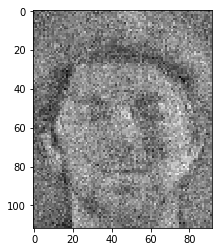


 time for epoch 3 is 23.250800609588623
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1538, 1.1537, 1.1537, 1.1536, 1.1536, 1.1536, 1.1535, 1.1535, 1.1535,
        1.1535, 1.1535, 1.1535, 1.1534, 1.1534, 1.1534, 1.1534, 1.1534, 1.1534,
        1.1534, 1.1534, 1.1529, 1.1538, 1.1536, 1.1535, 1.1528, 1.1530, 1.1531,
        1.1532, 1.1534, 1.1536, 1.1532, 1.1529, 1.1530, 1.1533, 1.1531, 1.1535,
        1.1529, 1.1531, 1.1531, 1.1530, 1.1536, 1.1531, 1.1530, 1.1532, 1.1533,
        1.1529, 1.1535, 1.1532, 1.1531, 1.1534, 1.1537, 1.1536, 1.1536, 1.1527,
        1.153

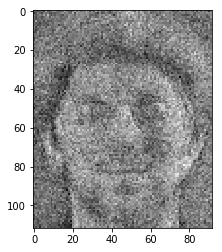


 time for epoch 4 is 22.753130674362183
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1538, 1.1538, 1.1538, 1.1538, 1.1538, 1.1537, 1.1537, 1.1537, 1.1537,
        1.1536, 1.1536, 1.1536, 1.1536, 1.1536, 1.1536, 1.1536, 1.1536, 1.1536,
        1.1536, 1.1536, 1.1536, 1.1534, 1.1533, 1.1537, 1.1538, 1.1531, 1.1535,
        1.1530, 1.1537, 1.1532, 1.1537, 1.1540, 1.1536, 1.1537, 1.1534, 1.1538,
        1.1536, 1.1530, 1.1532, 1.1535, 1.1535, 1.1538, 1.1539, 1.1539, 1.1534,
        1.1535, 1.1535, 1.1535, 1.1537, 1.1530, 1.1538, 1.1537, 1.1534, 1.1532,
        1.153

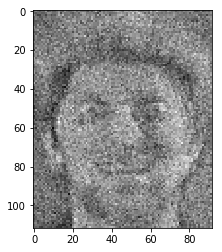


 time for epoch 5 is 23.5570125579834
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1540, 1.1540, 1.1540, 1.1540, 1.1539, 1.1539, 1.1539, 1.1539, 1.1538,
        1.1538, 1.1538, 1.1538, 1.1538, 1.1538, 1.1538, 1.1538, 1.1538, 1.1538,
        1.1538, 1.1538, 1.1539, 1.1537, 1.1540, 1.1534, 1.1535, 1.1532, 1.1539,
        1.1538, 1.1536, 1.1536, 1.1538, 1.1538, 1.1537, 1.1533, 1.1538, 1.1535,
        1.1537, 1.1533, 1.1537, 1.1537, 1.1541, 1.1536, 1.1539, 1.1535, 1.1540,
        1.1535, 1.1538, 1.1535, 1.1536, 1.1538, 1.1537, 1.1535, 1.1540, 1.1535,
        1.1538,

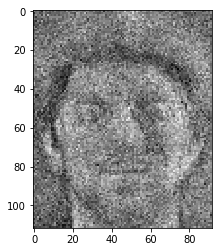


 time for epoch 6 is 23.44425868988037
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1545, 1.1544, 1.1543, 1.1542, 1.1541, 1.1541, 1.1540, 1.1540, 1.1540,
        1.1540, 1.1540, 1.1540, 1.1540, 1.1540, 1.1540, 1.1540, 1.1539, 1.1539,
        1.1539, 1.1539, 1.1533, 1.1537, 1.1536, 1.1540, 1.1544, 1.1541, 1.1540,
        1.1541, 1.1545, 1.1543, 1.1540, 1.1538, 1.1540, 1.1536, 1.1538, 1.1544,
        1.1538, 1.1539, 1.1538, 1.1535, 1.1536, 1.1542, 1.1539, 1.1539, 1.1541,
        1.1536, 1.1535, 1.1538, 1.1537, 1.1536, 1.1541, 1.1545, 1.1536, 1.1538,
        1.1537

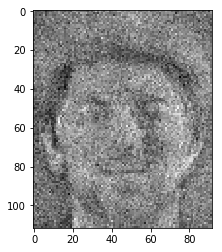


 time for epoch 7 is 24.569273710250854
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1545, 1.1545, 1.1545, 1.1545, 1.1544, 1.1544, 1.1544, 1.1543, 1.1543,
        1.1543, 1.1543, 1.1543, 1.1542, 1.1542, 1.1542, 1.1542, 1.1542, 1.1542,
        1.1541, 1.1541, 1.1539, 1.1539, 1.1544, 1.1543, 1.1537, 1.1543, 1.1545,
        1.1542, 1.1543, 1.1537, 1.1538, 1.1541, 1.1541, 1.1542, 1.1545, 1.1543,
        1.1539, 1.1542, 1.1539, 1.1545, 1.1543, 1.1539, 1.1545, 1.1540, 1.1539,
        1.1541, 1.1542, 1.1542, 1.1541, 1.1540, 1.1539, 1.1539, 1.1542, 1.1544,
        1.153

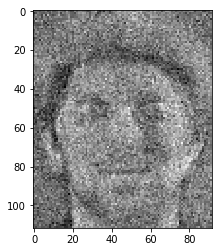


 time for epoch 8 is 23.8581645488739
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1547, 1.1546, 1.1546, 1.1546, 1.1546, 1.1546, 1.1545, 1.1545, 1.1545,
        1.1545, 1.1545, 1.1545, 1.1545, 1.1545, 1.1545, 1.1545, 1.1544, 1.1544,
        1.1544, 1.1544, 1.1543, 1.1542, 1.1543, 1.1543, 1.1545, 1.1542, 1.1543,
        1.1540, 1.1543, 1.1541, 1.1545, 1.1539, 1.1541, 1.1543, 1.1542, 1.1543,
        1.1543, 1.1544, 1.1541, 1.1543, 1.1546, 1.1543, 1.1546, 1.1547, 1.1543,
        1.1541, 1.1547, 1.1543, 1.1545, 1.1544, 1.1544, 1.1544, 1.1543, 1.1542,
        1.1541,

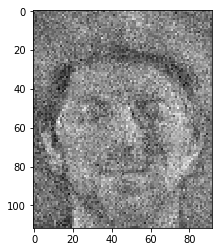


 time for epoch 9 is 23.04834294319153
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1552, 1.1547, 1.1547, 1.1547, 1.1547, 1.1547, 1.1546, 1.1546, 1.1546,
        1.1546, 1.1546, 1.1546, 1.1546, 1.1546, 1.1546, 1.1546, 1.1546, 1.1545,
        1.1545, 1.1545, 1.1546, 1.1546, 1.1547, 1.1543, 1.1546, 1.1550, 1.1544,
        1.1548, 1.1546, 1.1542, 1.1542, 1.1548, 1.1546, 1.1551, 1.1543, 1.1545,
        1.1548, 1.1543, 1.1547, 1.1539, 1.1544, 1.1542, 1.1544, 1.1542, 1.1542,
        1.1549, 1.1541, 1.1541, 1.1544, 1.1543, 1.1546, 1.1543, 1.1547, 1.1542,
        1.1544

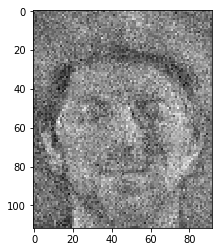


 time for epoch 10 is 22.837904930114746
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1552, 1.1551, 1.1551, 1.1550, 1.1550, 1.1549, 1.1548, 1.1548, 1.1548,
        1.1548, 1.1548, 1.1548, 1.1547, 1.1547, 1.1547, 1.1547, 1.1547, 1.1547,
        1.1547, 1.1547, 1.1546, 1.1549, 1.1548, 1.1547, 1.1546, 1.1546, 1.1546,
        1.1543, 1.1550, 1.1544, 1.1546, 1.1544, 1.1546, 1.1545, 1.1546, 1.1546,
        1.1545, 1.1544, 1.1548, 1.1546, 1.1552, 1.1545, 1.1547, 1.1548, 1.1545,
        1.1548, 1.1545, 1.1544, 1.1546, 1.1546, 1.1546, 1.1542, 1.1544, 1.1549,
        1.15

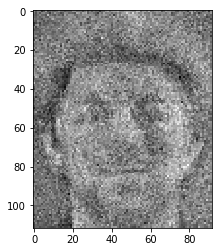


 time for epoch 11 is 23.62180519104004
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1552, 1.1552, 1.1551, 1.1551, 1.1551, 1.1551, 1.1551, 1.1550, 1.1550,
        1.1550, 1.1550, 1.1550, 1.1550, 1.1550, 1.1549, 1.1549, 1.1549, 1.1549,
        1.1549, 1.1549, 1.1552, 1.1548, 1.1548, 1.1551, 1.1551, 1.1550, 1.1550,
        1.1544, 1.1547, 1.1550, 1.1553, 1.1546, 1.1549, 1.1550, 1.1551, 1.1547,
        1.1552, 1.1548, 1.1547, 1.1551, 1.1549, 1.1552, 1.1549, 1.1546, 1.1546,
        1.1549, 1.1549, 1.1547, 1.1546, 1.1553, 1.1549, 1.1544, 1.1544, 1.1545,
        1.155

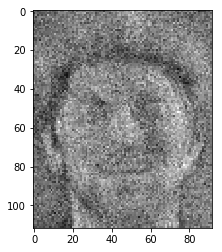


 time for epoch 12 is 22.87879514694214
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1554, 1.1553, 1.1553, 1.1552, 1.1552, 1.1552, 1.1552, 1.1552, 1.1551,
        1.1551, 1.1551, 1.1551, 1.1551, 1.1551, 1.1551, 1.1551, 1.1551, 1.1550,
        1.1550, 1.1550, 1.1547, 1.1545, 1.1546, 1.1547, 1.1551, 1.1550, 1.1546,
        1.1551, 1.1550, 1.1545, 1.1558, 1.1550, 1.1547, 1.1552, 1.1550, 1.1551,
        1.1551, 1.1551, 1.1551, 1.1548, 1.1549, 1.1552, 1.1554, 1.1548, 1.1553,
        1.1549, 1.1551, 1.1549, 1.1553, 1.1551, 1.1550, 1.1554, 1.1550, 1.1551,
        1.155

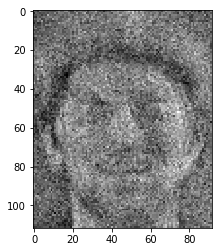


 time for epoch 13 is 23.069316864013672
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1558, 1.1555, 1.1554, 1.1554, 1.1554, 1.1554, 1.1554, 1.1554, 1.1554,
        1.1554, 1.1554, 1.1554, 1.1553, 1.1553, 1.1553, 1.1553, 1.1553, 1.1553,
        1.1553, 1.1553, 1.1551, 1.1557, 1.1551, 1.1550, 1.1549, 1.1558, 1.1551,
        1.1553, 1.1551, 1.1548, 1.1551, 1.1548, 1.1549, 1.1551, 1.1550, 1.1553,
        1.1552, 1.1549, 1.1550, 1.1554, 1.1553, 1.1552, 1.1553, 1.1554, 1.1551,
        1.1553, 1.1551, 1.1554, 1.1550, 1.1555, 1.1550, 1.1551, 1.1553, 1.1550,
        1.15

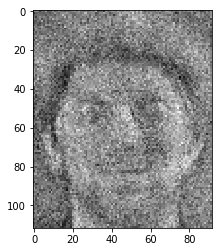


 time for epoch 14 is 22.430025100708008
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1558, 1.1558, 1.1557, 1.1557, 1.1556, 1.1555, 1.1555, 1.1555, 1.1555,
        1.1555, 1.1555, 1.1555, 1.1555, 1.1555, 1.1555, 1.1555, 1.1554, 1.1554,
        1.1554, 1.1554, 1.1553, 1.1552, 1.1556, 1.1553, 1.1549, 1.1554, 1.1554,
        1.1555, 1.1553, 1.1555, 1.1554, 1.1553, 1.1552, 1.1557, 1.1553, 1.1554,
        1.1554, 1.1553, 1.1553, 1.1554, 1.1554, 1.1555, 1.1553, 1.1555, 1.1555,
        1.1555, 1.1553, 1.1552, 1.1554, 1.1553, 1.1554, 1.1552, 1.1554, 1.1554,
        1.15

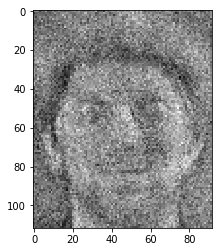


 time for epoch 15 is 22.58955955505371
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1558, 1.1558, 1.1558, 1.1558, 1.1558, 1.1557, 1.1557, 1.1557, 1.1557,
        1.1557, 1.1557, 1.1556, 1.1556, 1.1556, 1.1556, 1.1556, 1.1556, 1.1556,
        1.1555, 1.1555, 1.1555, 1.1556, 1.1556, 1.1560, 1.1556, 1.1555, 1.1559,
        1.1558, 1.1554, 1.1555, 1.1555, 1.1560, 1.1557, 1.1556, 1.1554, 1.1558,
        1.1555, 1.1557, 1.1553, 1.1556, 1.1556, 1.1555, 1.1555, 1.1556, 1.1556,
        1.1556, 1.1555, 1.1557, 1.1553, 1.1553, 1.1554, 1.1558, 1.1556, 1.1556,
        1.155

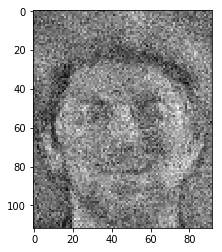


 time for epoch 16 is 22.372150659561157
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1560, 1.1560, 1.1560, 1.1559, 1.1559, 1.1558, 1.1558, 1.1558, 1.1558,
        1.1558, 1.1558, 1.1558, 1.1558, 1.1558, 1.1558, 1.1558, 1.1558, 1.1557,
        1.1557, 1.1557, 1.1559, 1.1554, 1.1560, 1.1557, 1.1556, 1.1559, 1.1560,
        1.1555, 1.1554, 1.1561, 1.1558, 1.1558, 1.1558, 1.1555, 1.1559, 1.1559,
        1.1560, 1.1558, 1.1556, 1.1558, 1.1554, 1.1556, 1.1560, 1.1556, 1.1557,
        1.1560, 1.1561, 1.1560, 1.1557, 1.1556, 1.1560, 1.1558, 1.1556, 1.1556,
        1.15

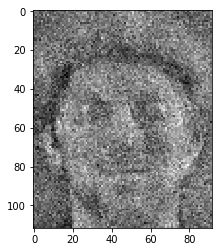


 time for epoch 17 is 22.53374171257019
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1561, 1.1561, 1.1561, 1.1560, 1.1560, 1.1560, 1.1560, 1.1560, 1.1560,
        1.1560, 1.1560, 1.1560, 1.1560, 1.1560, 1.1559, 1.1559, 1.1559, 1.1559,
        1.1559, 1.1559, 1.1559, 1.1557, 1.1557, 1.1556, 1.1560, 1.1558, 1.1562,
        1.1559, 1.1557, 1.1556, 1.1558, 1.1559, 1.1559, 1.1556, 1.1556, 1.1558,
        1.1559, 1.1553, 1.1559, 1.1557, 1.1557, 1.1556, 1.1558, 1.1560, 1.1561,
        1.1559, 1.1558, 1.1562, 1.1557, 1.1559, 1.1557, 1.1559, 1.1557, 1.1557,
        1.155

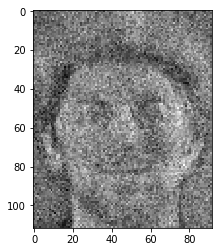


 time for epoch 18 is 22.46088409423828
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1564, 1.1562, 1.1562, 1.1562, 1.1562, 1.1562, 1.1561, 1.1561, 1.1561,
        1.1561, 1.1561, 1.1561, 1.1561, 1.1561, 1.1560, 1.1560, 1.1560, 1.1560,
        1.1560, 1.1560, 1.1561, 1.1561, 1.1561, 1.1556, 1.1553, 1.1562, 1.1560,
        1.1559, 1.1559, 1.1561, 1.1561, 1.1558, 1.1558, 1.1562, 1.1558, 1.1562,
        1.1560, 1.1563, 1.1554, 1.1560, 1.1560, 1.1559, 1.1562, 1.1560, 1.1561,
        1.1562, 1.1563, 1.1563, 1.1556, 1.1560, 1.1560, 1.1560, 1.1561, 1.1559,
        1.156

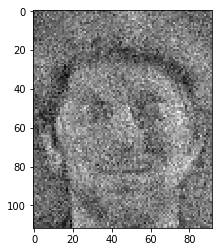


 time for epoch 19 is 22.40907597541809
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1564, 1.1564, 1.1563, 1.1563, 1.1563, 1.1563, 1.1563, 1.1563, 1.1563,
        1.1562, 1.1562, 1.1562, 1.1562, 1.1562, 1.1562, 1.1562, 1.1562, 1.1562,
        1.1562, 1.1562, 1.1561, 1.1561, 1.1559, 1.1562, 1.1563, 1.1560, 1.1559,
        1.1564, 1.1563, 1.1567, 1.1559, 1.1562, 1.1562, 1.1560, 1.1559, 1.1560,
        1.1565, 1.1563, 1.1562, 1.1562, 1.1563, 1.1562, 1.1560, 1.1563, 1.1561,
        1.1563, 1.1559, 1.1563, 1.1563, 1.1563, 1.1561, 1.1562, 1.1563, 1.1562,
        1.155

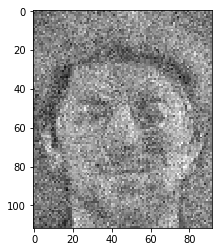


 time for epoch 20 is 23.734490871429443
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1567, 1.1566, 1.1565, 1.1565, 1.1565, 1.1564, 1.1564, 1.1564, 1.1564,
        1.1564, 1.1564, 1.1563, 1.1563, 1.1563, 1.1563, 1.1563, 1.1563, 1.1563,
        1.1563, 1.1563, 1.1562, 1.1566, 1.1563, 1.1563, 1.1560, 1.1562, 1.1562,
        1.1563, 1.1560, 1.1561, 1.1561, 1.1561, 1.1561, 1.1564, 1.1566, 1.1558,
        1.1563, 1.1568, 1.1563, 1.1564, 1.1565, 1.1563, 1.1561, 1.1563, 1.1560,
        1.1562, 1.1562, 1.1566, 1.1563, 1.1561, 1.1560, 1.1566, 1.1561, 1.1563,
        1.15

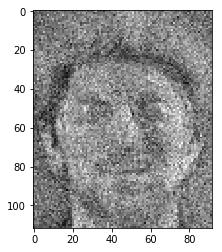


 time for epoch 21 is 22.578621864318848
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1568, 1.1567, 1.1566, 1.1566, 1.1566, 1.1566, 1.1566, 1.1566, 1.1566,
        1.1566, 1.1566, 1.1565, 1.1565, 1.1565, 1.1565, 1.1565, 1.1565, 1.1564,
        1.1564, 1.1564, 1.1564, 1.1564, 1.1564, 1.1559, 1.1563, 1.1562, 1.1568,
        1.1567, 1.1563, 1.1566, 1.1563, 1.1564, 1.1565, 1.1566, 1.1562, 1.1566,
        1.1564, 1.1564, 1.1566, 1.1564, 1.1567, 1.1563, 1.1566, 1.1563, 1.1564,
        1.1565, 1.1567, 1.1563, 1.1565, 1.1564, 1.1567, 1.1570, 1.1563, 1.1564,
        1.15

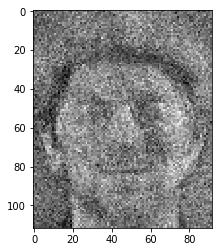


 time for epoch 22 is 23.573739767074585
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1570, 1.1569, 1.1568, 1.1568, 1.1567, 1.1567, 1.1567, 1.1567, 1.1567,
        1.1567, 1.1566, 1.1566, 1.1566, 1.1566, 1.1566, 1.1566, 1.1566, 1.1566,
        1.1566, 1.1566, 1.1567, 1.1569, 1.1565, 1.1568, 1.1565, 1.1567, 1.1567,
        1.1566, 1.1566, 1.1564, 1.1568, 1.1563, 1.1563, 1.1569, 1.1566, 1.1568,
        1.1566, 1.1563, 1.1567, 1.1564, 1.1566, 1.1567, 1.1566, 1.1566, 1.1564,
        1.1566, 1.1568, 1.1564, 1.1566, 1.1569, 1.1567, 1.1569, 1.1567, 1.1562,
        1.15

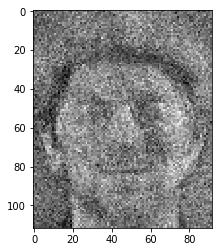


 time for epoch 23 is 25.42097282409668
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1570, 1.1569, 1.1569, 1.1569, 1.1569, 1.1569, 1.1569, 1.1569, 1.1568,
        1.1568, 1.1568, 1.1568, 1.1568, 1.1568, 1.1568, 1.1568, 1.1568, 1.1568,
        1.1568, 1.1568, 1.1569, 1.1569, 1.1571, 1.1569, 1.1569, 1.1566, 1.1568,
        1.1567, 1.1562, 1.1569, 1.1565, 1.1566, 1.1569, 1.1567, 1.1565, 1.1564,
        1.1566, 1.1568, 1.1566, 1.1566, 1.1567, 1.1570, 1.1565, 1.1569, 1.1569,
        1.1569, 1.1568, 1.1567, 1.1568, 1.1567, 1.1569, 1.1570, 1.1565, 1.1570,
        1.156

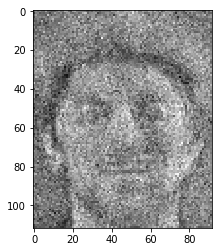


 time for epoch 24 is 24.84951114654541
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1571, 1.1570, 1.1570, 1.1570, 1.1570, 1.1570, 1.1570, 1.1569, 1.1569,
        1.1569, 1.1569, 1.1569, 1.1569, 1.1569, 1.1569, 1.1569, 1.1569, 1.1569,
        1.1569, 1.1569, 1.1570, 1.1567, 1.1567, 1.1569, 1.1566, 1.1567, 1.1567,
        1.1568, 1.1566, 1.1568, 1.1572, 1.1565, 1.1569, 1.1568, 1.1571, 1.1566,
        1.1566, 1.1567, 1.1568, 1.1568, 1.1567, 1.1568, 1.1564, 1.1569, 1.1568,
        1.1567, 1.1568, 1.1573, 1.1568, 1.1568, 1.1569, 1.1568, 1.1568, 1.1567,
        1.156

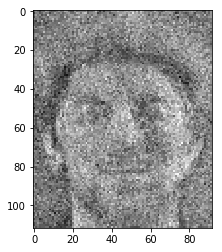


 time for epoch 25 is 24.262096166610718
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1573, 1.1572, 1.1572, 1.1572, 1.1572, 1.1572, 1.1572, 1.1571, 1.1571,
        1.1571, 1.1571, 1.1571, 1.1570, 1.1570, 1.1570, 1.1570, 1.1570, 1.1570,
        1.1570, 1.1570, 1.1571, 1.1568, 1.1567, 1.1572, 1.1570, 1.1567, 1.1568,
        1.1570, 1.1568, 1.1568, 1.1572, 1.1567, 1.1571, 1.1569, 1.1571, 1.1571,
        1.1566, 1.1568, 1.1572, 1.1570, 1.1568, 1.1570, 1.1569, 1.1570, 1.1570,
        1.1573, 1.1568, 1.1574, 1.1571, 1.1573, 1.1572, 1.1571, 1.1570, 1.1568,
        1.15

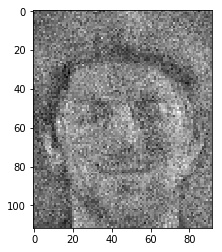


 time for epoch 26 is 22.38715386390686
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1574, 1.1573, 1.1573, 1.1573, 1.1573, 1.1572, 1.1572, 1.1572, 1.1572,
        1.1572, 1.1572, 1.1572, 1.1572, 1.1572, 1.1572, 1.1572, 1.1572, 1.1572,
        1.1572, 1.1571, 1.1568, 1.1574, 1.1567, 1.1570, 1.1569, 1.1568, 1.1571,
        1.1570, 1.1569, 1.1569, 1.1570, 1.1571, 1.1575, 1.1570, 1.1571, 1.1571,
        1.1567, 1.1570, 1.1568, 1.1570, 1.1572, 1.1573, 1.1567, 1.1572, 1.1571,
        1.1571, 1.1570, 1.1571, 1.1572, 1.1571, 1.1573, 1.1571, 1.1575, 1.1571,
        1.156

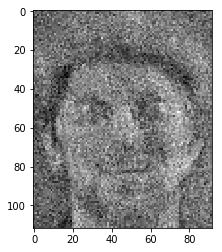


 time for epoch 27 is 23.237872838974
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1576, 1.1575, 1.1575, 1.1575, 1.1575, 1.1574, 1.1574, 1.1573, 1.1573,
        1.1573, 1.1573, 1.1573, 1.1573, 1.1573, 1.1573, 1.1573, 1.1573, 1.1573,
        1.1572, 1.1572, 1.1572, 1.1573, 1.1571, 1.1571, 1.1573, 1.1574, 1.1574,
        1.1571, 1.1572, 1.1576, 1.1573, 1.1573, 1.1569, 1.1576, 1.1571, 1.1572,
        1.1572, 1.1573, 1.1572, 1.1572, 1.1578, 1.1573, 1.1571, 1.1573, 1.1575,
        1.1573, 1.1573, 1.1569, 1.1571, 1.1576, 1.1573, 1.1573, 1.1573, 1.1571,
        1.1572,

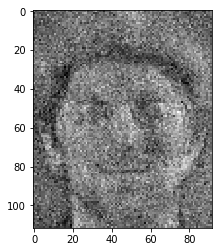


 time for epoch 28 is 22.62546706199646
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1578, 1.1576, 1.1576, 1.1576, 1.1576, 1.1576, 1.1576, 1.1576, 1.1575,
        1.1575, 1.1575, 1.1575, 1.1575, 1.1575, 1.1575, 1.1575, 1.1575, 1.1575,
        1.1575, 1.1574, 1.1573, 1.1575, 1.1574, 1.1574, 1.1575, 1.1574, 1.1571,
        1.1577, 1.1571, 1.1573, 1.1572, 1.1573, 1.1575, 1.1577, 1.1574, 1.1575,
        1.1572, 1.1577, 1.1572, 1.1572, 1.1577, 1.1572, 1.1575, 1.1574, 1.1572,
        1.1578, 1.1576, 1.1575, 1.1573, 1.1571, 1.1574, 1.1570, 1.1573, 1.1575,
        1.157

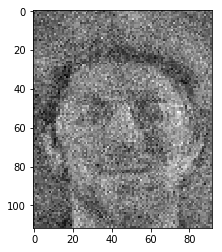


 time for epoch 29 is 22.36216711997986


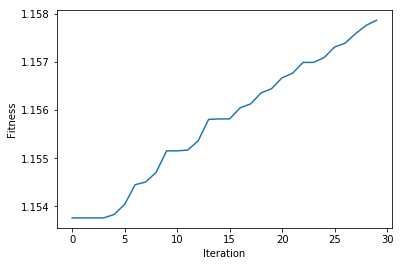

In [21]:
import random
import time
best_outputs = []
num_generations = 30
num_population = 100
num_parents_ratio = 0.2
count = 0
# generate population
ww = net2.hidden1.weight.data[:]
# print(ww[0][0], ww[0][1])
population_shape = torch.Size([num_population]) + ww.shape
noise = 0.01 * torch.randn(population_shape).to(device)
# print(noise.shape)
# print(noise[:,0,0])
# print(noise[0][0][0], noise[1][0][0], noise[2][0][0], noise[3][0][0], noise[4][0][0])
for generation in range(num_generations):
    start_time = time.time()
    # fitness function
    fitnessSize = torch.Size([num_population])
    fitness = torch.zeros(fitnessSize).to(device)
    acc = torch.zeros(fitnessSize).to(device)
    sim = torch.zeros(fitnessSize).to(device)
    testacc = torch.zeros(fitnessSize).to(device)
    
    for i in range(num_population):
        noise_tmp = noise[i]
        net2.hidden1.weight.data[:] = net2.hidden1.weight.data[:] + noise_tmp
        # accuracy = eval_target_net(net2, trainloader)
        accuracy = eval_target_net(net2, trainloader)/100.0
        testacc[i] = eval_target_net(net2, testloader)
        # similarity
        cur_imgs = torch.zeros(real_imgs.shape)
        ww_new = net2.hidden1.weight.data[:]
        similarity = 0
        for k in range(40):
            im0 = ww0[k,:].reshape(1,1,112,92)
            im_train = ww_new[k,:].reshape(1,1,112,92)
            cur_imgs[k] = im_train - im0
            #similarity += torch.sum((cur_imgs[k]-real_imgs[k])**2)
            data = cur_imgs[k]/100.0
            data1 = real_imgs[k]/100.0
            ncc = torch.sum(data*data1)/torch.sqrt(torch.sum(data**2))/torch.sqrt(torch.sum(data1**2))
            similarity += -0.5*(ncc-1)
        similarity = similarity/40
        acc[i] = accuracy
        sim[i] = similarity
        fitness[i] = accuracy + similarity
        net2.hidden1.weight.data[:] = net2.hidden1.weight.data[:] - noise_tmp
    print(acc)
    print(fitness, torch.max(fitness))
#     print(acc)
#     print(sim)

    # pdb.set_trace()
    
    # record best outputs
    best_outputs.append(torch.max(fitness))
    max_fitness_idx = torch.where(fitness == torch.max(fitness))
    max_fitness_idx = max_fitness_idx[0][0]
    print("fitness: {0}, accuracy: {1}, similarity: {2}".format(fitness[max_fitness_idx], acc[max_fitness_idx], sim[max_fitness_idx]))
    print("test accuracy: {0}".format(testacc[max_fitness_idx]))
    # pdb.set_trace()
    best_noise = noise[max_fitness_idx, :]
    ww = net2.hidden1.weight.data[:] + best_noise
    i = 37
    im0 = ww0[i,:].reshape(1,1,112,92)
    im_train = ww[i,:].reshape(1,1,112,92)
    plt.imshow((im_train-im0).squeeze().cpu().detach().numpy(),cmap='gray')
    # plt.imsave('.\\mlp_0_03\\{0}'.format(idx_to_people[i]), (im_train-im0).squeeze().cpu().detach().numpy(),cmap='gray')
    plt.show()
    
    # termination
    if len(best_outputs) >= 2:
        if best_outputs[-1] - best_outputs[-2] < 1e-6:
            count += 1
        else:
            count = 0
        if count == 5:
            print("Stop now! ------------------------")
            break
        
    
    # pdb.set_trace()
    
    # find parents which works best in fitenss function
    num_parents = int(num_parents_ratio*num_population)
    assert num_parents <= num_population, "The number of parents should be smaller than the number of population"
    parents = torch.zeros(torch.Size([num_parents]) + noise.shape[1:]).to(device)
    _, idxseq = torch.sort(fitness, descending=True)
    for i in range(num_parents):
        parents[i] = noise[idxseq[i],:,:]
    # pdb.set_trace()
    
    # crossover between elite and regular parents.
    offspring_size = torch.Size([num_population-num_parents]) + noise.shape[1:]
    offspring = torch.zeros(offspring_size)
    for k in range(offspring_size[0]):
        parent1_idx = random.randint(0,num_parents-1)
        parent2_idx = random.randint(0,num_population-1)
        parent1_p = torch.randint(0,2,offspring_size[1:]).to(device)
        parent2_p = 1 - parent1_p
        #pdb.set_trace()
        offspring[k,:,:] = parent1_p*parents[parent1_idx,:,:]+parent2_p*noise[parent2_idx,:,:]
    
    
#     crossover_point = np.uint8(offspring_size[1]/2)
#     for k in range(offspring_size[0]):
#         parent1_idx = random.randint(0,num_parents-1)
#         parent2_idx = random.randint(0,num_parents-1)
#         offspring[k,0:crossover_point,:] = parents[parent1_idx,0:crossover_point,:]
#         offspring[k, crossover_point:,:] = parents[parent2_idx,crossover_point:,:]
        
#     for k in range(offspring_size[0]):
#         parent1_idx = random.randint(0,num_parents-1)
#         parent2_idx = random.randint(0,num_parents-1)
#         print(k)
#         for xaxis in range(offspring.shape[1]):
#             for yaxis in range(offspring.shape[2]):
#                 if random.randint(0,1) == 0:
#                     offspring[k,xaxis,yaxis] = parents[parent1_idx,xaxis,yaxis]
#                 else:
#                     offspring[k,xaxis,yaxis] = parents[parent2_idx,xaxis,yaxis]
    # print(offspring)
    
    # pdb.set_trace()
    
    # mutation
#     num_mutations = 1000
#     for idx in range(offspring.shape[0]):
#         for mutation_num in range(num_mutations):
#             random_value = np.random.uniform(-1.0, 1.0, 1)
#             gene_idx1 = random.randint(0,offspring.shape[1]-1)
#             gene_idx2 = random.randint(0,offspring.shape[2]-1)
#             offspring[idx, gene_idx1, gene_idx2] = offspring[idx, gene_idx1, gene_idx2] + random_value
    # print(offspring)
    
    # pdb.set_trace()
    
    # create new population
    noise[0:parents.shape[0], :] = parents
    noise[parents.shape[0]:, :] = offspring
    # print(noise)
    
    end_time = time.time()
    print("\n time for epoch {} is {}".format(generation, end_time-start_time))
    
import matplotlib.pyplot
matplotlib.pyplot.plot(best_outputs)
matplotlib.pyplot.xlabel("Iteration")
matplotlib.pyplot.ylabel("Fitness")
matplotlib.pyplot.show()

### crossover only from parents

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1520, 1.1522, 1.1524, 1.1526, 1.1526, 1.1524, 1.1520, 1.1516, 1.1530,
        1.1522, 1.1521, 1.1526, 1.1523, 1.1526, 1.1526, 1.1525, 1.1525, 1.1519,
        1.1525, 1.1517, 1.1526, 1.1523, 1.1520, 1.1521, 1.1520, 1.1525, 1.1519,
        1.1519, 1.1522, 1.1525, 1.1525, 1.1520, 1.1524, 1.1522, 1.1524, 1.1518,
        1.1524, 1.1526, 1.1520, 1.1520, 1.1523, 1.1519, 1.1521, 1.1524, 1.1524,
        1.1521, 1.1521, 1.1525, 1.1522, 1.1524, 1.1527, 1.1528, 1.1517, 1.1523,
        1.1535, 1.1523, 1.1529, 1.1523, 1.1526, 1.1521

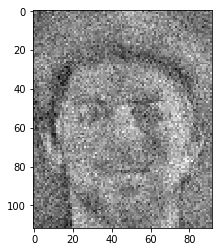


 time for epoch 0 is 23.050320148468018
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1535, 1.1532, 1.1530, 1.1530, 1.1530, 1.1529, 1.1529, 1.1529, 1.1529,
        1.1528, 1.1528, 1.1527, 1.1527, 1.1527, 1.1527, 1.1527, 1.1527, 1.1527,
        1.1526, 1.1526, 1.1529, 1.1528, 1.1534, 1.1529, 1.1523, 1.1529, 1.1526,
        1.1528, 1.1532, 1.1530, 1.1528, 1.1524, 1.1529, 1.1537, 1.1528, 1.1530,
        1.1525, 1.1524, 1.1527, 1.1529, 1.1526, 1.1531, 1.1528, 1.1529, 1.1529,
        1.1532, 1.1527, 1.1529, 1.1530, 1.1534, 1.1535, 1.1528, 1.1529, 1.1527,
        1.153

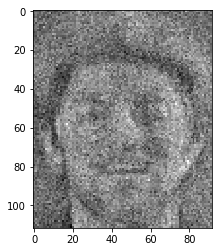


 time for epoch 1 is 22.196576595306396
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1537, 1.1535, 1.1535, 1.1534, 1.1534, 1.1534, 1.1534, 1.1534, 1.1533,
        1.1533, 1.1533, 1.1532, 1.1532, 1.1532, 1.1532, 1.1532, 1.1532, 1.1531,
        1.1531, 1.1531, 1.1532, 1.1535, 1.1530, 1.1534, 1.1530, 1.1531, 1.1535,
        1.1534, 1.1532, 1.1537, 1.1530, 1.1531, 1.1537, 1.1529, 1.1530, 1.1527,
        1.1534, 1.1526, 1.1528, 1.1533, 1.1530, 1.1536, 1.1536, 1.1528, 1.1535,
        1.1532, 1.1534, 1.1530, 1.1533, 1.1534, 1.1535, 1.1532, 1.1534, 1.1533,
        1.153

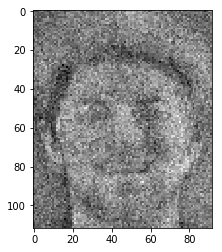


 time for epoch 2 is 22.511799812316895
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1539, 1.1538, 1.1537, 1.1537, 1.1537, 1.1537, 1.1537, 1.1537, 1.1537,
        1.1536, 1.1536, 1.1536, 1.1536, 1.1536, 1.1535, 1.1535, 1.1535, 1.1535,
        1.1535, 1.1535, 1.1539, 1.1532, 1.1538, 1.1534, 1.1541, 1.1537, 1.1537,
        1.1537, 1.1542, 1.1534, 1.1540, 1.1534, 1.1535, 1.1538, 1.1535, 1.1537,
        1.1535, 1.1537, 1.1538, 1.1535, 1.1539, 1.1535, 1.1533, 1.1533, 1.1537,
        1.1536, 1.1537, 1.1538, 1.1534, 1.1532, 1.1535, 1.1538, 1.1534, 1.1536,
        1.153

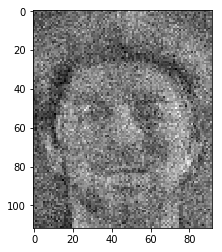


 time for epoch 3 is 23.476172924041748
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1543, 1.1542, 1.1541, 1.1541, 1.1541, 1.1541, 1.1540, 1.1540, 1.1540,
        1.1540, 1.1540, 1.1540, 1.1539, 1.1539, 1.1539, 1.1539, 1.1539, 1.1539,
        1.1539, 1.1539, 1.1539, 1.1539, 1.1540, 1.1540, 1.1541, 1.1533, 1.1540,
        1.1545, 1.1542, 1.1534, 1.1539, 1.1541, 1.1539, 1.1536, 1.1538, 1.1540,
        1.1534, 1.1539, 1.1540, 1.1538, 1.1540, 1.1540, 1.1539, 1.1543, 1.1535,
        1.1541, 1.1543, 1.1545, 1.1536, 1.1542, 1.1538, 1.1537, 1.1541, 1.1540,
        1.154

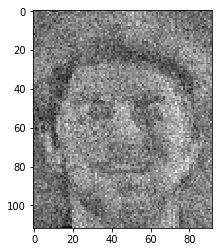


 time for epoch 4 is 23.983839511871338
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1545, 1.1545, 1.1545, 1.1545, 1.1545, 1.1544, 1.1544, 1.1543, 1.1543,
        1.1543, 1.1543, 1.1543, 1.1543, 1.1543, 1.1542, 1.1542, 1.1542, 1.1542,
        1.1542, 1.1542, 1.1543, 1.1543, 1.1545, 1.1544, 1.1543, 1.1542, 1.1541,
        1.1541, 1.1541, 1.1542, 1.1543, 1.1543, 1.1538, 1.1541, 1.1544, 1.1543,
        1.1544, 1.1543, 1.1544, 1.1544, 1.1543, 1.1544, 1.1542, 1.1542, 1.1540,
        1.1544, 1.1542, 1.1542, 1.1542, 1.1543, 1.1544, 1.1546, 1.1544, 1.1541,
        1.154

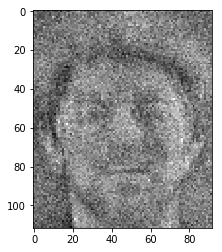


 time for epoch 5 is 22.30237889289856
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1549, 1.1549, 1.1549, 1.1548, 1.1548, 1.1547, 1.1547, 1.1546, 1.1546,
        1.1546, 1.1545, 1.1545, 1.1545, 1.1545, 1.1545, 1.1545, 1.1545, 1.1545,
        1.1545, 1.1545, 1.1545, 1.1546, 1.1544, 1.1547, 1.1547, 1.1546, 1.1547,
        1.1545, 1.1546, 1.1547, 1.1545, 1.1545, 1.1545, 1.1549, 1.1544, 1.1548,
        1.1544, 1.1549, 1.1545, 1.1547, 1.1544, 1.1546, 1.1545, 1.1548, 1.1546,
        1.1540, 1.1546, 1.1548, 1.1546, 1.1546, 1.1545, 1.1550, 1.1543, 1.1547,
        1.1544

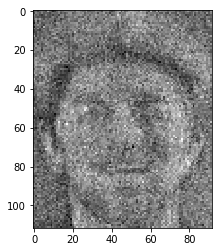


 time for epoch 6 is 24.42362332344055
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1551, 1.1551, 1.1550, 1.1550, 1.1549, 1.1549, 1.1549, 1.1549, 1.1549,
        1.1549, 1.1549, 1.1548, 1.1548, 1.1548, 1.1548, 1.1548, 1.1548, 1.1548,
        1.1548, 1.1548, 1.1550, 1.1551, 1.1549, 1.1548, 1.1550, 1.1552, 1.1548,
        1.1546, 1.1550, 1.1545, 1.1548, 1.1546, 1.1549, 1.1547, 1.1551, 1.1552,
        1.1547, 1.1551, 1.1552, 1.1550, 1.1551, 1.1550, 1.1551, 1.1551, 1.1546,
        1.1548, 1.1550, 1.1553, 1.1547, 1.1547, 1.1551, 1.1549, 1.1550, 1.1553,
        1.1553

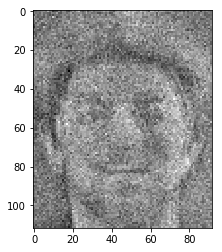


 time for epoch 7 is 23.24381923675537
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1554, 1.1553, 1.1553, 1.1553, 1.1552, 1.1552, 1.1552, 1.1552, 1.1551,
        1.1551, 1.1551, 1.1551, 1.1551, 1.1551, 1.1551, 1.1551, 1.1551, 1.1551,
        1.1551, 1.1551, 1.1555, 1.1553, 1.1552, 1.1553, 1.1548, 1.1552, 1.1552,
        1.1552, 1.1556, 1.1551, 1.1550, 1.1549, 1.1550, 1.1550, 1.1553, 1.1550,
        1.1553, 1.1554, 1.1552, 1.1554, 1.1550, 1.1551, 1.1553, 1.1552, 1.1549,
        1.1552, 1.1549, 1.1550, 1.1553, 1.1550, 1.1553, 1.1551, 1.1554, 1.1548,
        1.1551

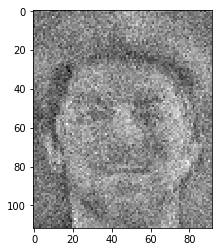


 time for epoch 8 is 22.787010669708252
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1557, 1.1556, 1.1556, 1.1555, 1.1555, 1.1555, 1.1555, 1.1555, 1.1554,
        1.1554, 1.1554, 1.1554, 1.1554, 1.1554, 1.1554, 1.1554, 1.1554, 1.1554,
        1.1554, 1.1554, 1.1554, 1.1558, 1.1555, 1.1554, 1.1553, 1.1554, 1.1553,
        1.1559, 1.1554, 1.1558, 1.1556, 1.1552, 1.1553, 1.1554, 1.1553, 1.1552,
        1.1555, 1.1553, 1.1555, 1.1556, 1.1554, 1.1552, 1.1554, 1.1559, 1.1555,
        1.1556, 1.1552, 1.1555, 1.1553, 1.1552, 1.1556, 1.1556, 1.1557, 1.1555,
        1.155

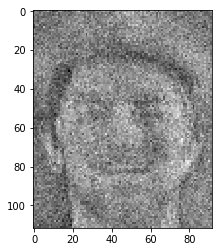


 time for epoch 9 is 22.5436909198761
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1560, 1.1559, 1.1559, 1.1559, 1.1558, 1.1558, 1.1558, 1.1557, 1.1557,
        1.1557, 1.1557, 1.1557, 1.1557, 1.1557, 1.1557, 1.1556, 1.1556, 1.1556,
        1.1556, 1.1556, 1.1557, 1.1557, 1.1560, 1.1554, 1.1559, 1.1557, 1.1556,
        1.1557, 1.1558, 1.1559, 1.1559, 1.1557, 1.1559, 1.1557, 1.1553, 1.1562,
        1.1557, 1.1556, 1.1556, 1.1556, 1.1560, 1.1558, 1.1562, 1.1556, 1.1557,
        1.1557, 1.1554, 1.1559, 1.1562, 1.1556, 1.1558, 1.1560, 1.1556, 1.1561,
        1.1556,

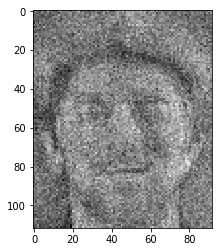


 time for epoch 10 is 22.512797594070435
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1562, 1.1562, 1.1562, 1.1562, 1.1561, 1.1561, 1.1560, 1.1560, 1.1560,
        1.1560, 1.1560, 1.1560, 1.1560, 1.1560, 1.1559, 1.1559, 1.1559, 1.1559,
        1.1559, 1.1559, 1.1561, 1.1561, 1.1557, 1.1559, 1.1562, 1.1559, 1.1559,
        1.1564, 1.1560, 1.1562, 1.1559, 1.1560, 1.1559, 1.1563, 1.1563, 1.1561,
        1.1563, 1.1565, 1.1560, 1.1560, 1.1557, 1.1560, 1.1562, 1.1559, 1.1559,
        1.1560, 1.1557, 1.1559, 1.1559, 1.1562, 1.1560, 1.1559, 1.1558, 1.1561,
        1.15

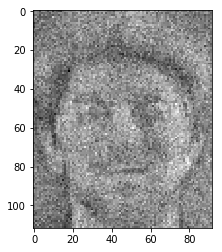


 time for epoch 11 is 23.252793550491333
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1565, 1.1564, 1.1564, 1.1564, 1.1564, 1.1564, 1.1563, 1.1563, 1.1563,
        1.1563, 1.1563, 1.1563, 1.1563, 1.1563, 1.1563, 1.1562, 1.1562, 1.1562,
        1.1562, 1.1562, 1.1563, 1.1563, 1.1563, 1.1564, 1.1564, 1.1562, 1.1565,
        1.1569, 1.1562, 1.1562, 1.1566, 1.1565, 1.1562, 1.1560, 1.1562, 1.1563,
        1.1563, 1.1561, 1.1564, 1.1564, 1.1558, 1.1564, 1.1566, 1.1565, 1.1563,
        1.1556, 1.1563, 1.1561, 1.1567, 1.1565, 1.1562, 1.1563, 1.1560, 1.1563,
        1.15

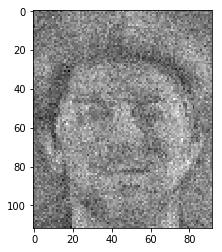


 time for epoch 12 is 22.45692205429077
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1569, 1.1567, 1.1567, 1.1566, 1.1566, 1.1566, 1.1566, 1.1566, 1.1565,
        1.1565, 1.1565, 1.1565, 1.1565, 1.1565, 1.1565, 1.1565, 1.1565, 1.1565,
        1.1565, 1.1565, 1.1569, 1.1564, 1.1565, 1.1564, 1.1567, 1.1569, 1.1568,
        1.1567, 1.1567, 1.1562, 1.1567, 1.1566, 1.1567, 1.1565, 1.1569, 1.1564,
        1.1567, 1.1565, 1.1566, 1.1568, 1.1565, 1.1568, 1.1565, 1.1565, 1.1567,
        1.1567, 1.1564, 1.1564, 1.1567, 1.1567, 1.1566, 1.1564, 1.1566, 1.1564,
        1.156

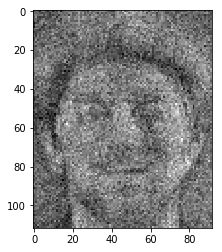


 time for epoch 13 is 24.336880207061768
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1570, 1.1569, 1.1569, 1.1569, 1.1569, 1.1569, 1.1569, 1.1568, 1.1568,
        1.1568, 1.1568, 1.1567, 1.1567, 1.1567, 1.1567, 1.1567, 1.1567, 1.1567,
        1.1567, 1.1567, 1.1569, 1.1567, 1.1571, 1.1564, 1.1570, 1.1567, 1.1569,
        1.1571, 1.1570, 1.1568, 1.1567, 1.1566, 1.1572, 1.1570, 1.1570, 1.1568,
        1.1565, 1.1567, 1.1567, 1.1569, 1.1567, 1.1569, 1.1565, 1.1569, 1.1568,
        1.1571, 1.1567, 1.1567, 1.1570, 1.1569, 1.1570, 1.1568, 1.1567, 1.1571,
        1.15

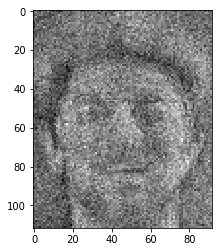


 time for epoch 14 is 23.61679983139038
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1572, 1.1572, 1.1571, 1.1571, 1.1571, 1.1571, 1.1571, 1.1571, 1.1571,
        1.1571, 1.1571, 1.1570, 1.1570, 1.1570, 1.1570, 1.1570, 1.1570, 1.1570,
        1.1570, 1.1570, 1.1568, 1.1571, 1.1571, 1.1569, 1.1568, 1.1569, 1.1572,
        1.1573, 1.1568, 1.1572, 1.1573, 1.1569, 1.1570, 1.1571, 1.1569, 1.1570,
        1.1572, 1.1569, 1.1571, 1.1571, 1.1570, 1.1570, 1.1575, 1.1571, 1.1569,
        1.1572, 1.1570, 1.1571, 1.1570, 1.1570, 1.1570, 1.1574, 1.1570, 1.1570,
        1.157

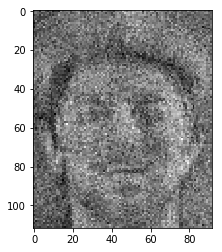


 time for epoch 15 is 22.065003633499146
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1575, 1.1575, 1.1574, 1.1573, 1.1573, 1.1573, 1.1573, 1.1573, 1.1573,
        1.1573, 1.1572, 1.1572, 1.1572, 1.1572, 1.1572, 1.1572, 1.1572, 1.1572,
        1.1572, 1.1572, 1.1574, 1.1571, 1.1573, 1.1569, 1.1574, 1.1573, 1.1567,
        1.1575, 1.1576, 1.1572, 1.1571, 1.1572, 1.1572, 1.1573, 1.1572, 1.1575,
        1.1575, 1.1576, 1.1574, 1.1573, 1.1573, 1.1573, 1.1568, 1.1577, 1.1572,
        1.1574, 1.1572, 1.1576, 1.1572, 1.1573, 1.1572, 1.1573, 1.1575, 1.1573,
        1.15

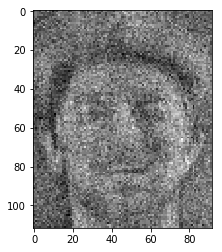


 time for epoch 16 is 22.09786057472229
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1578, 1.1577, 1.1576, 1.1576, 1.1576, 1.1575, 1.1575, 1.1575, 1.1575,
        1.1575, 1.1575, 1.1575, 1.1575, 1.1575, 1.1575, 1.1574, 1.1574, 1.1574,
        1.1574, 1.1574, 1.1575, 1.1571, 1.1575, 1.1572, 1.1576, 1.1574, 1.1575,
        1.1575, 1.1572, 1.1576, 1.1577, 1.1574, 1.1576, 1.1577, 1.1576, 1.1576,
        1.1577, 1.1574, 1.1576, 1.1575, 1.1573, 1.1578, 1.1573, 1.1575, 1.1575,
        1.1575, 1.1573, 1.1578, 1.1575, 1.1573, 1.1578, 1.1575, 1.1576, 1.1575,
        1.157

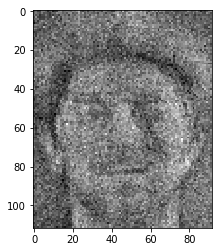


 time for epoch 17 is 22.225518703460693
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1578, 1.1578, 1.1578, 1.1578, 1.1577, 1.1577, 1.1577, 1.1577, 1.1577,
        1.1577, 1.1577, 1.1577, 1.1577, 1.1577, 1.1577, 1.1576, 1.1576, 1.1576,
        1.1576, 1.1576, 1.1578, 1.1578, 1.1573, 1.1572, 1.1576, 1.1577, 1.1577,
        1.1578, 1.1577, 1.1577, 1.1576, 1.1577, 1.1581, 1.1578, 1.1575, 1.1579,
        1.1579, 1.1577, 1.1578, 1.1576, 1.1577, 1.1577, 1.1578, 1.1576, 1.1578,
        1.1576, 1.1578, 1.1574, 1.1578, 1.1574, 1.1579, 1.1577, 1.1580, 1.1578,
        1.15

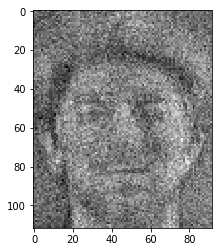


 time for epoch 18 is 23.195945978164673
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1582, 1.1581, 1.1580, 1.1580, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579,
        1.1579, 1.1579, 1.1579, 1.1579, 1.1578, 1.1578, 1.1578, 1.1578, 1.1578,
        1.1578, 1.1578, 1.1579, 1.1579, 1.1580, 1.1579, 1.1578, 1.1579, 1.1578,
        1.1577, 1.1579, 1.1580, 1.1581, 1.1577, 1.1579, 1.1577, 1.1576, 1.1579,
        1.1581, 1.1577, 1.1581, 1.1582, 1.1579, 1.1579, 1.1580, 1.1578, 1.1577,
        1.1579, 1.1579, 1.1579, 1.1577, 1.1576, 1.1577, 1.1581, 1.1580, 1.1579,
        1.15

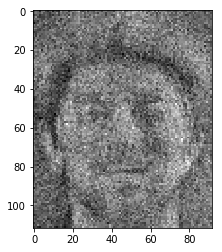


 time for epoch 19 is 24.80962872505188
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1582, 1.1582, 1.1582, 1.1582, 1.1581, 1.1581, 1.1581, 1.1581, 1.1581,
        1.1581, 1.1581, 1.1580, 1.1580, 1.1580, 1.1580, 1.1580, 1.1580, 1.1580,
        1.1580, 1.1580, 1.1579, 1.1581, 1.1580, 1.1583, 1.1579, 1.1581, 1.1581,
        1.1578, 1.1582, 1.1581, 1.1581, 1.1582, 1.1581, 1.1580, 1.1580, 1.1583,
        1.1584, 1.1582, 1.1582, 1.1580, 1.1579, 1.1583, 1.1580, 1.1583, 1.1579,
        1.1582, 1.1580, 1.1582, 1.1582, 1.1580, 1.1580, 1.1578, 1.1580, 1.1582,
        1.158

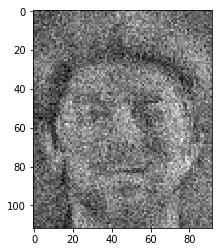


 time for epoch 20 is 25.11281943321228
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1585, 1.1584, 1.1584, 1.1584, 1.1583, 1.1583, 1.1583, 1.1583, 1.1583,
        1.1583, 1.1583, 1.1583, 1.1583, 1.1583, 1.1583, 1.1582, 1.1582, 1.1582,
        1.1582, 1.1582, 1.1581, 1.1584, 1.1583, 1.1582, 1.1584, 1.1583, 1.1587,
        1.1582, 1.1583, 1.1582, 1.1582, 1.1583, 1.1583, 1.1584, 1.1583, 1.1582,
        1.1585, 1.1584, 1.1581, 1.1583, 1.1584, 1.1584, 1.1582, 1.1582, 1.1584,
        1.1583, 1.1581, 1.1585, 1.1586, 1.1582, 1.1583, 1.1585, 1.1582, 1.1585,
        1.158

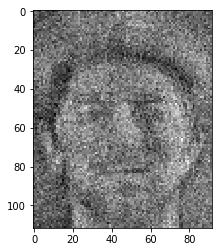


 time for epoch 21 is 23.347537755966187
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1587, 1.1586, 1.1586, 1.1585, 1.1585, 1.1585, 1.1585, 1.1585, 1.1585,
        1.1585, 1.1585, 1.1585, 1.1585, 1.1585, 1.1585, 1.1585, 1.1584, 1.1584,
        1.1584, 1.1584, 1.1585, 1.1587, 1.1585, 1.1584, 1.1586, 1.1583, 1.1584,
        1.1586, 1.1584, 1.1585, 1.1585, 1.1583, 1.1585, 1.1587, 1.1586, 1.1584,
        1.1586, 1.1585, 1.1586, 1.1583, 1.1585, 1.1588, 1.1585, 1.1584, 1.1585,
        1.1586, 1.1583, 1.1585, 1.1586, 1.1582, 1.1588, 1.1585, 1.1585, 1.1585,
        1.15

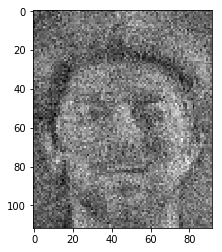


 time for epoch 22 is 22.51274561882019
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1588, 1.1588, 1.1587, 1.1587, 1.1587, 1.1587, 1.1587, 1.1586, 1.1586,
        1.1586, 1.1586, 1.1586, 1.1586, 1.1586, 1.1586, 1.1586, 1.1586, 1.1586,
        1.1586, 1.1586, 1.1585, 1.1584, 1.1586, 1.1584, 1.1589, 1.1588, 1.1586,
        1.1586, 1.1590, 1.1584, 1.1585, 1.1586, 1.1588, 1.1585, 1.1585, 1.1586,
        1.1587, 1.1586, 1.1587, 1.1586, 1.1585, 1.1584, 1.1586, 1.1583, 1.1587,
        1.1587, 1.1589, 1.1589, 1.1589, 1.1587, 1.1586, 1.1586, 1.1585, 1.1586,
        1.158

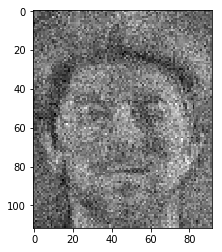


 time for epoch 23 is 23.520079135894775
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1590, 1.1589, 1.1589, 1.1589, 1.1589, 1.1589, 1.1589, 1.1588, 1.1588,
        1.1588, 1.1588, 1.1588, 1.1588, 1.1588, 1.1588, 1.1588, 1.1588, 1.1588,
        1.1587, 1.1587, 1.1587, 1.1588, 1.1589, 1.1589, 1.1588, 1.1589, 1.1588,
        1.1586, 1.1588, 1.1590, 1.1590, 1.1587, 1.1587, 1.1589, 1.1588, 1.1588,
        1.1589, 1.1588, 1.1587, 1.1588, 1.1589, 1.1587, 1.1587, 1.1588, 1.1588,
        1.1591, 1.1590, 1.1587, 1.1585, 1.1588, 1.1588, 1.1589, 1.1588, 1.1586,
        1.15

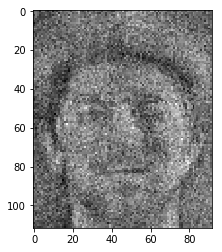


 time for epoch 24 is 23.8182590007782
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1591, 1.1591, 1.1590, 1.1590, 1.1590, 1.1590, 1.1590, 1.1590, 1.1590,
        1.1590, 1.1590, 1.1590, 1.1589, 1.1589, 1.1589, 1.1589, 1.1589, 1.1589,
        1.1589, 1.1589, 1.1590, 1.1590, 1.1588, 1.1590, 1.1590, 1.1589, 1.1590,
        1.1589, 1.1590, 1.1589, 1.1590, 1.1588, 1.1591, 1.1590, 1.1589, 1.1589,
        1.1591, 1.1592, 1.1587, 1.1590, 1.1586, 1.1589, 1.1588, 1.1589, 1.1589,
        1.1589, 1.1589, 1.1587, 1.1589, 1.1587, 1.1590, 1.1590, 1.1591, 1.1588,
        1.1590

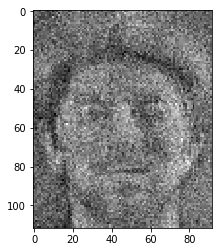


 time for epoch 25 is 23.6746666431427
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1592, 1.1592, 1.1592, 1.1592, 1.1592, 1.1592, 1.1592, 1.1591, 1.1591,
        1.1591, 1.1591, 1.1591, 1.1591, 1.1591, 1.1591, 1.1591, 1.1591, 1.1590,
        1.1590, 1.1590, 1.1591, 1.1592, 1.1590, 1.1592, 1.1591, 1.1590, 1.1593,
        1.1591, 1.1591, 1.1589, 1.1592, 1.1590, 1.1592, 1.1592, 1.1593, 1.1591,
        1.1591, 1.1594, 1.1591, 1.1591, 1.1593, 1.1589, 1.1592, 1.1590, 1.1591,
        1.1592, 1.1591, 1.1592, 1.1591, 1.1593, 1.1591, 1.1592, 1.1592, 1.1591,
        1.1592

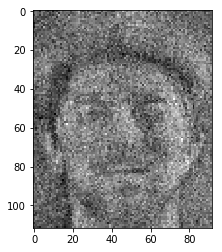


 time for epoch 26 is 23.4991352558136
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1594, 1.1594, 1.1593, 1.1593, 1.1593, 1.1593, 1.1593, 1.1593, 1.1593,
        1.1592, 1.1592, 1.1592, 1.1592, 1.1592, 1.1592, 1.1592, 1.1592, 1.1592,
        1.1592, 1.1592, 1.1592, 1.1593, 1.1593, 1.1593, 1.1593, 1.1594, 1.1595,
        1.1593, 1.1594, 1.1594, 1.1593, 1.1594, 1.1595, 1.1592, 1.1592, 1.1592,
        1.1594, 1.1593, 1.1592, 1.1592, 1.1594, 1.1589, 1.1592, 1.1591, 1.1594,
        1.1591, 1.1593, 1.1591, 1.1591, 1.1592, 1.1593, 1.1594, 1.1591, 1.1593,
        1.1592

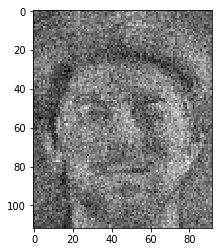


 time for epoch 27 is 23.19495701789856
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1598, 1.1595, 1.1595, 1.1595, 1.1595, 1.1595, 1.1595, 1.1595, 1.1594,
        1.1594, 1.1594, 1.1594, 1.1594, 1.1594, 1.1594, 1.1594, 1.1594, 1.1594,
        1.1594, 1.1594, 1.1594, 1.1596, 1.1594, 1.1594, 1.1595, 1.1593, 1.1595,
        1.1594, 1.1595, 1.1593, 1.1594, 1.1592, 1.1595, 1.1594, 1.1593, 1.1596,
        1.1594, 1.1594, 1.1594, 1.1594, 1.1597, 1.1596, 1.1597, 1.1594, 1.1595,
        1.1596, 1.1595, 1.1597, 1.1594, 1.1593, 1.1596, 1.1595, 1.1594, 1.1594,
        1.159

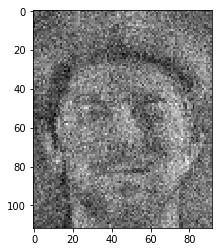


 time for epoch 28 is 23.215924978256226
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1.1598, 1.1598, 1.1598, 1.1597, 1.1597, 1.1597, 1.1597, 1.1597, 1.1597,
        1.1596, 1.1596, 1.1596, 1.1596, 1.1596, 1.1596, 1.1596, 1.1595, 1.1595,
        1.1595, 1.1595, 1.1597, 1.1596, 1.1599, 1.1596, 1.1596, 1.1598, 1.1594,
        1.1598, 1.1596, 1.1597, 1.1597, 1.1597, 1.1596, 1.1597, 1.1597, 1.1595,
        1.1596, 1.1595, 1.1596, 1.1597, 1.1598, 1.1597, 1.1596, 1.1595, 1.1598,
        1.1597, 1.1598, 1.1595, 1.1596, 1.1596, 1.1597, 1.1596, 1.1595, 1.1597,
        1.15

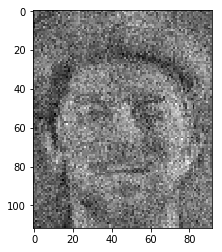


 time for epoch 29 is 25.34818935394287


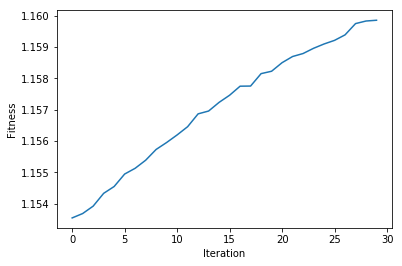

In [23]:
import random
import time
best_outputs = []
num_generations = 30
num_population = 100
num_parents_ratio = 0.2
count = 0
# generate population
ww = net2.hidden1.weight.data[:]
# print(ww[0][0], ww[0][1])
population_shape = torch.Size([num_population]) + ww.shape
noise = 0.01 * torch.randn(population_shape).to(device)
# print(noise.shape)
# print(noise[:,0,0])
# print(noise[0][0][0], noise[1][0][0], noise[2][0][0], noise[3][0][0], noise[4][0][0])
for generation in range(num_generations):
    start_time = time.time()
    # fitness function
    fitnessSize = torch.Size([num_population])
    fitness = torch.zeros(fitnessSize).to(device)
    acc = torch.zeros(fitnessSize).to(device)
    sim = torch.zeros(fitnessSize).to(device)
    testacc = torch.zeros(fitnessSize).to(device)
    
    for i in range(num_population):
        noise_tmp = noise[i]
        net2.hidden1.weight.data[:] = net2.hidden1.weight.data[:] + noise_tmp
        # accuracy = eval_target_net(net2, trainloader)
        accuracy = eval_target_net(net2, trainloader)/100.0
        testacc[i] = eval_target_net(net2, testloader)
        # similarity
        cur_imgs = torch.zeros(real_imgs.shape)
        ww_new = net2.hidden1.weight.data[:]
        similarity = 0
        for k in range(40):
            im0 = ww0[k,:].reshape(1,1,112,92)
            im_train = ww_new[k,:].reshape(1,1,112,92)
            cur_imgs[k] = im_train - im0
            #similarity += torch.sum((cur_imgs[k]-real_imgs[k])**2)
            data = cur_imgs[k]/100.0
            data1 = real_imgs[k]/100.0
            ncc = torch.sum(data*data1)/torch.sqrt(torch.sum(data**2))/torch.sqrt(torch.sum(data1**2))
            similarity += -0.5*(ncc-1)
        similarity = similarity/40
        acc[i] = accuracy
        sim[i] = similarity
        fitness[i] = accuracy + similarity
        net2.hidden1.weight.data[:] = net2.hidden1.weight.data[:] - noise_tmp
    print(acc)
    print(fitness, torch.max(fitness))
#     print(acc)
#     print(sim)

    # pdb.set_trace()
    
    # record best outputs
    best_outputs.append(torch.max(fitness))
    max_fitness_idx = torch.where(fitness == torch.max(fitness))
    max_fitness_idx = max_fitness_idx[0][0]
    print("fitness: {0}, accuracy: {1}, similarity: {2}".format(fitness[max_fitness_idx], acc[max_fitness_idx], sim[max_fitness_idx]))
    print("test accuracy: {0}".format(testacc[max_fitness_idx]))
    # pdb.set_trace()
    best_noise = noise[max_fitness_idx, :]
    ww = net2.hidden1.weight.data[:] + best_noise
    i = 37
    im0 = ww0[i,:].reshape(1,1,112,92)
    im_train = ww[i,:].reshape(1,1,112,92)
    plt.imshow((im_train-im0).squeeze().cpu().detach().numpy(),cmap='gray')
    # plt.imsave('.\\mlp_0_03\\{0}'.format(idx_to_people[i]), (im_train-im0).squeeze().cpu().detach().numpy(),cmap='gray')
    plt.show()
    
    # termination
    if len(best_outputs) >= 2:
        if best_outputs[-1] - best_outputs[-2] < 1e-6:
            count += 1
        else:
            count = 0
        if count == 5:
            print("Stop now! ------------------------")
            break
        
    
    # pdb.set_trace()
    
    # find parents which works best in fitenss function
    num_parents = int(num_parents_ratio*num_population)
    assert num_parents <= num_population, "The number of parents should be smaller than the number of population"
    parents = torch.zeros(torch.Size([num_parents]) + noise.shape[1:]).to(device)
    _, idxseq = torch.sort(fitness, descending=True)
    for i in range(num_parents):
        parents[i] = noise[idxseq[i],:,:]
    # pdb.set_trace()
    
    # crossover between elite and regular parents.
    offspring_size = torch.Size([num_population-num_parents]) + noise.shape[1:]
    offspring = torch.zeros(offspring_size)
    for k in range(offspring_size[0]):
        parent1_idx = random.randint(0,num_parents-1)
        parent2_idx = random.randint(0,num_parents-1)
        parent1_p = torch.randint(0,2,offspring_size[1:]).to(device)
        parent2_p = 1 - parent1_p
        #pdb.set_trace()
        offspring[k,:,:] = parent1_p*parents[parent1_idx,:,:]+parent2_p*parents[parent2_idx,:,:]
    
    
#     crossover_point = np.uint8(offspring_size[1]/2)
#     for k in range(offspring_size[0]):
#         parent1_idx = random.randint(0,num_parents-1)
#         parent2_idx = random.randint(0,num_parents-1)
#         offspring[k,0:crossover_point,:] = parents[parent1_idx,0:crossover_point,:]
#         offspring[k, crossover_point:,:] = parents[parent2_idx,crossover_point:,:]
        
#     for k in range(offspring_size[0]):
#         parent1_idx = random.randint(0,num_parents-1)
#         parent2_idx = random.randint(0,num_parents-1)
#         print(k)
#         for xaxis in range(offspring.shape[1]):
#             for yaxis in range(offspring.shape[2]):
#                 if random.randint(0,1) == 0:
#                     offspring[k,xaxis,yaxis] = parents[parent1_idx,xaxis,yaxis]
#                 else:
#                     offspring[k,xaxis,yaxis] = parents[parent2_idx,xaxis,yaxis]
    # print(offspring)
    
    # pdb.set_trace()
    
    # mutation
#     num_mutations = 1000
#     for idx in range(offspring.shape[0]):
#         for mutation_num in range(num_mutations):
#             random_value = np.random.uniform(-1.0, 1.0, 1)
#             gene_idx1 = random.randint(0,offspring.shape[1]-1)
#             gene_idx2 = random.randint(0,offspring.shape[2]-1)
#             offspring[idx, gene_idx1, gene_idx2] = offspring[idx, gene_idx1, gene_idx2] + random_value
    # print(offspring)
    
    # pdb.set_trace()
    
    # create new population
    noise[0:parents.shape[0], :] = parents
    noise[parents.shape[0]:, :] = offspring
    # print(noise)
    
    end_time = time.time()
    print("\n time for epoch {} is {}".format(generation, end_time-start_time))
    
import matplotlib.pyplot
matplotlib.pyplot.plot(best_outputs)
matplotlib.pyplot.xlabel("Iteration")
matplotlib.pyplot.ylabel("Fitness")
matplotlib.pyplot.show()

In [23]:
noisev = 0.03
noise = noisev * torch.randn(ww.shape).to(device)
print(type(noise))
print(noise.max())
print(noise.min())
print(noise.shape)
ww = ww + noise
net2.hidden1.weight.data[:] = net2.hidden1.weight.data[:] + noise
print(ww)
print(net2.hidden1.weight.data[:])
print(ww == net2.hidden1.weight.data[:])

<class 'torch.Tensor'>
tensor(0.1457, device='cuda:0')
tensor(-0.1398, device='cuda:0')
torch.Size([40, 10304])
tensor([[-0.0814, -0.0084,  0.0446,  ...,  0.0275, -0.0209,  0.0198],
        [ 0.0135,  0.0135,  0.0305,  ..., -0.0154,  0.0228, -0.0329],
        [-0.0264, -0.0227, -0.0117,  ..., -0.0031, -0.0522,  0.0130],
        ...,
        [ 0.0466,  0.0147,  0.0210,  ..., -0.0012, -0.0632, -0.0328],
        [-0.0050,  0.0232,  0.0407,  ...,  0.0142, -0.0115, -0.0179],
        [-0.0026, -0.0237, -0.0180,  ..., -0.0115, -0.0032,  0.0220]],
       device='cuda:0')
tensor([[-0.0814, -0.0084,  0.0446,  ...,  0.0275, -0.0209,  0.0198],
        [ 0.0135,  0.0135,  0.0305,  ..., -0.0154,  0.0228, -0.0329],
        [-0.0264, -0.0227, -0.0117,  ..., -0.0031, -0.0522,  0.0130],
        ...,
        [ 0.0466,  0.0147,  0.0210,  ..., -0.0012, -0.0632, -0.0328],
        [-0.0050,  0.0232,  0.0407,  ...,  0.0142, -0.0115, -0.0179],
        [-0.0026, -0.0237, -0.0180,  ..., -0.0115, -0.0032,  0.0220

torch.Size([40, 1, 112, 92])
tensor([[-0.0814, -0.0084,  0.0446,  ...,  0.0275, -0.0209,  0.0198],
        [ 0.0135,  0.0135,  0.0305,  ..., -0.0154,  0.0228, -0.0329],
        [-0.0264, -0.0227, -0.0117,  ..., -0.0031, -0.0522,  0.0130],
        ...,
        [ 0.0466,  0.0147,  0.0210,  ..., -0.0012, -0.0632, -0.0328],
        [-0.0050,  0.0232,  0.0407,  ...,  0.0142, -0.0115, -0.0179],
        [-0.0026, -0.0237, -0.0180,  ..., -0.0115, -0.0032,  0.0220]],
       device='cuda:0') tensor(-0.1552, device='cuda:0') tensor(0.1551, device='cuda:0') torch.Size([40, 10304])


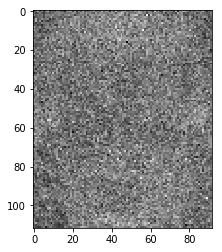

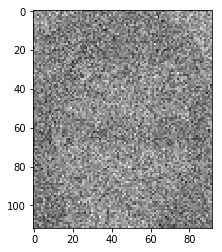

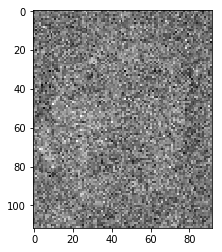

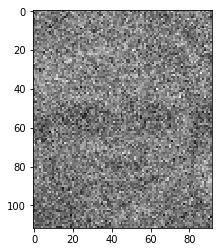

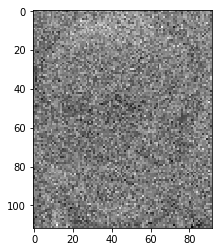

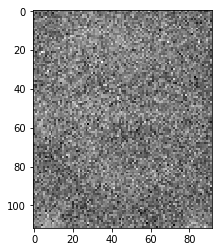

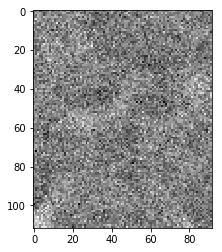

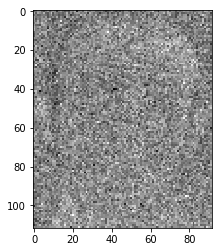

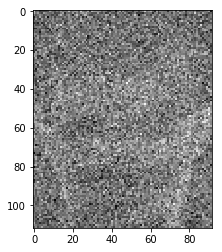

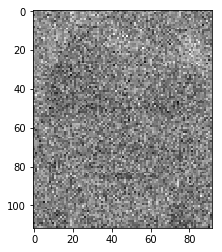

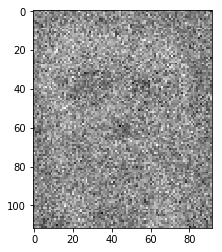

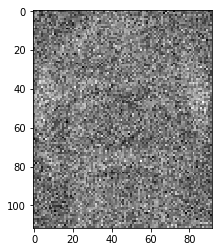

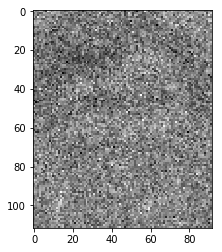

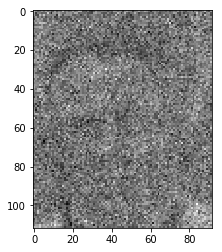

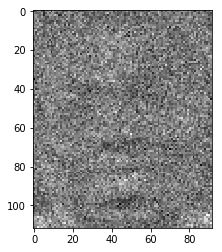

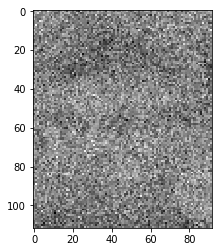

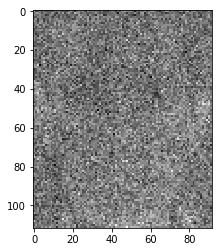

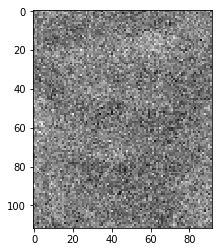

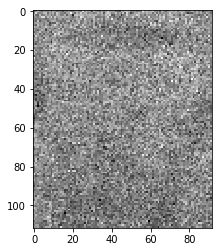

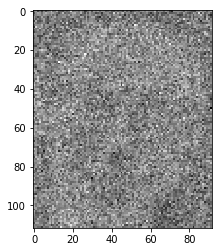

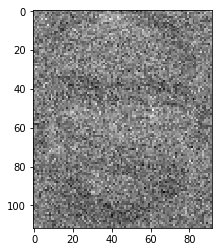

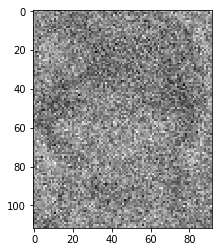

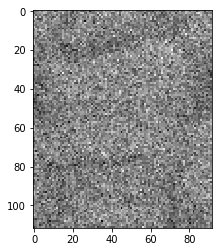

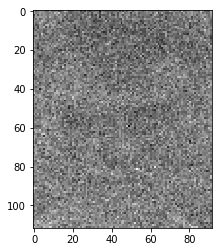

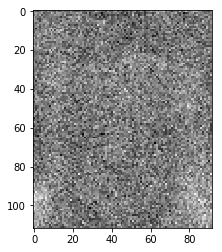

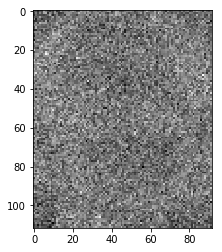

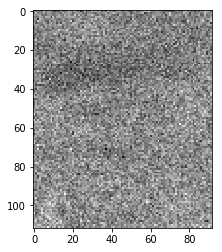

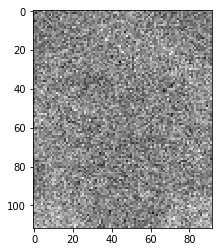

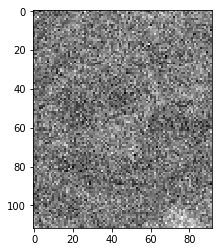

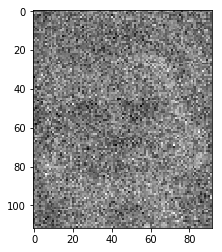

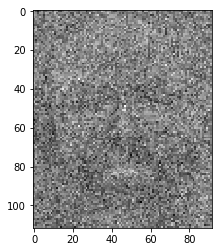

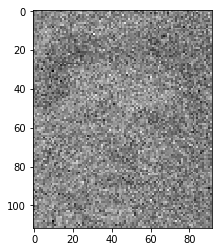

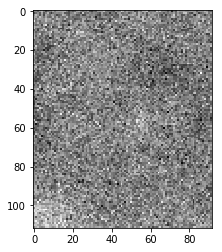

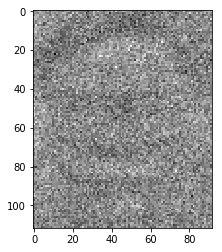

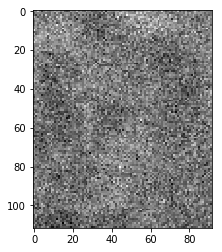

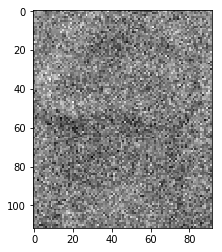

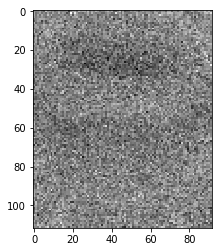

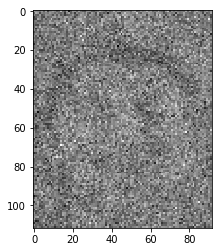

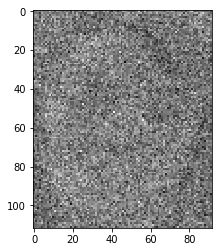

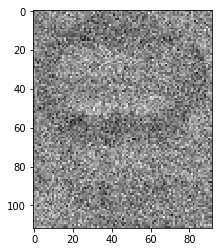

In [25]:
print(imgs.shape)
ww = net2.hidden1.weight.data[:]
bb = net2.hidden1.bias.data[:]

print(ww, ww.min(),ww.max(),ww.shape)

for i in range(40):
    im0 = ww0[i,:].reshape(1,1,112,92)
    im_train = ww[i,:].reshape(1,1,112,92)
    plt.imshow((im_train-im0).squeeze().cpu().detach().numpy(),cmap='gray')
    plt.imsave('.\\mlp_0_03\\{0}'.format(idx_to_people[i]), (im_train-im0).squeeze().cpu().detach().numpy(),cmap='gray')
    plt.show()

    

# im_train = ww[34,:].squeeze().cpu().detach().numpy().reshape(112,92)
# plt.imshow(im0.squeeze().cpu().detach().numpy(),cmap='gray')
# plt.show()

# plt.imshow(im_train,cmap='gray')
# plt.show()

# plt.imshow(im_train-im0.squeeze().cpu().detach().numpy(),cmap='gray')
# plt.show()

# plt.imshow(im_train-torch.randn(im_train.shape)/100,cmap='gray')
# plt.show()
# # print(torch.sum())

In [26]:
eval_target_net(net2, testloader)
print(net2.hidden1.weight.data[:])


Accuracy = 87.50 %


tensor([[-0.0814, -0.0084,  0.0446,  ...,  0.0275, -0.0209,  0.0198],
        [ 0.0135,  0.0135,  0.0305,  ..., -0.0154,  0.0228, -0.0329],
        [-0.0264, -0.0227, -0.0117,  ..., -0.0031, -0.0522,  0.0130],
        ...,
        [ 0.0466,  0.0147,  0.0210,  ..., -0.0012, -0.0632, -0.0328],
        [-0.0050,  0.0232,  0.0407,  ...,  0.0142, -0.0115, -0.0179],
        [-0.0026, -0.0237, -0.0180,  ..., -0.0115, -0.0032,  0.0220]],
       device='cuda:0')


<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> torch.Size([4, 572, 754])
<class 'numpy.ndarray'> (4, 572, 754)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39])
tensor(0.)
tensor(1.)
torch.Size([40, 4, 112, 92])


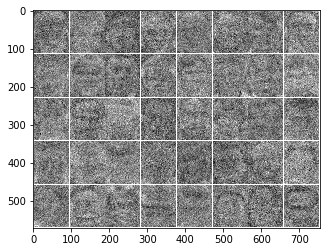

In [106]:
class MLPdataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    def __getitem__(self, idx): 
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        data = np.asarray(img)
        label = people_to_idx[img_path.split('\\')[-1].split('.')[-2]]
        if self.transform is not None: 
            img = self.transform(img)
        
        return img, label

mlp_dir = ".\\mlp\\"

mlp_paths = []
for p in os.listdir(mlp_dir): 
    mlp_paths.append(os.path.join(mlp_dir,p))
        
mlpset = MLPdataset(mlp_paths, people_to_idx, transform=torchvision.transforms.ToTensor())
mlploader = torch.utils.data.DataLoader(mlpset, batch_size=40, shuffle=False, num_workers=0)

mlp_imgs,labels = iter(mlploader).next()
print(type(mlp_imgs), type(torchvision.utils.make_grid(mlp_imgs)))
imshow(torchvision.utils.make_grid(mlp_imgs), 'after') 
print(labels)
print(mlp_imgs.min())
print(mlp_imgs.max())
print(mlp_imgs.shape)

In [27]:
ww = ww - noise
net2.hidden1.weight.data[:] = net2.hidden1.weight.data[:] - noise
print(ww, net2.hidden1.weight.data[:])

tensor([[-0.0383, -0.0217, -0.0246,  ...,  0.0152, -0.0200, -0.0203],
        [ 0.0366,  0.0102,  0.0115,  ..., -0.0111, -0.0036, -0.0198],
        [-0.0008, -0.0358, -0.0125,  ..., -0.0358, -0.0219, -0.0016],
        ...,
        [ 0.0012, -0.0184, -0.0037,  ...,  0.0117, -0.0267, -0.0249],
        [ 0.0161,  0.0381,  0.0310,  ..., -0.0126,  0.0148,  0.0027],
        [ 0.0199, -0.0134, -0.0053,  ..., -0.0138, -0.0060,  0.0129]],
       device='cuda:0') tensor([[-0.0383, -0.0217, -0.0246,  ...,  0.0152, -0.0200, -0.0203],
        [ 0.0366,  0.0102,  0.0115,  ..., -0.0111, -0.0036, -0.0198],
        [-0.0008, -0.0358, -0.0125,  ..., -0.0358, -0.0219, -0.0016],
        ...,
        [ 0.0012, -0.0184, -0.0037,  ...,  0.0117, -0.0267, -0.0249],
        [ 0.0161,  0.0381,  0.0310,  ..., -0.0126,  0.0148,  0.0027],
        [ 0.0199, -0.0134, -0.0053,  ..., -0.0138, -0.0060,  0.0129]],
       device='cuda:0')


In [28]:
print(ww.max(), ww.min())

tensor(0.0870, device='cuda:0') tensor(-0.0796, device='cuda:0')


## Gradient Ascent

In [18]:
from torch.autograd import Variable

def ga(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses = []
    grad0 = np.zeros((112,92))
    for j in range(iterations):
        for i in range(1):

            net.zero_grad()
            
#             out = nn.functional.softmax(net(input), dim=1)
            out = net(input)
            loss= -out.take(category)#+reg_alpha
            
            loss.backward()
            input.data = input.data - lr * input.grad.data
            input.grad.zero_()
        losses.append(loss.data)
#         print(j)
        grad0=input.grad.data.squeeze().cpu().detach().numpy()
        input.grad.data = input.grad.data - input.grad.data
#         plt.imsave(f"Results/2Fred {j}.png",input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1,format='png')
    plt.plot(losses)
    plt.show()

    
    return input

In [19]:
from torch.autograd import Variable
def ga_adam(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses=[]

    v_x = torch.tensor(np.zeros((112,92))).unsqueeze(0).float().cuda()
    m_x = torch.tensor(np.zeros((112,92))).unsqueeze(0).float().cuda()
    beta1 = torch.tensor(0.9).cuda()
    beta2 = torch.tensor(0.99).cuda()
    eps = torch.tensor(1e-6).cuda()
    
    for j in range(iterations):
        for i in range(1):

            net.zero_grad()
            out = nn.functional.softmax(net(input), dim=1)
            loss= -out.take(category)#+reg_alpha
            
            loss.backward()
            
            m_x = beta1 *m_x + (1-beta1) * input.grad.data       
            v_x = beta2 *v_x + (1-beta2) * input.grad.data**2
            input.data = input.data - lr * m_x / torch.sqrt(v_x+eps)
            input.grad.zero_()
#             input.data = input.data - lr * input.grad.data
        print(j)
        print(loss.data)
        print(-out.take(category))
        losses.append(loss.data)
        plt.imshow(input.squeeze().cpu().detach().numpy(),cmap = 'gray')
        plt.show()
#         plt.imsave(f"Results/2Fred {j}.png",input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1,format='png')
    plt.plot(losses)
    plt.show()

    
    return input

In [ ]:
# import os
# import imageio

# png_dir = 'png/'
# images = []
# # for file_name in os.listdir(png_dir):
# for i in range(100):
#     filename = f"Results/2Fred {i}.png" 
# #     if file_name.endswith('dog_dream_%i.png' %(i)):
# #     file_path = os.path.join(png_dir, file_name)
#     images.append(imageio.imread(filename))
        
# kargs = { 'duration': 0.1 }
# imageio.mimsave('movie.gif', images,**kargs)

## Overfitted model

Gradient Ascent optimizes an input image to maximize the posterior of a particular category. 

Gradient Ascent reconstructs the memorized image within the parameters. If the model is well generalized with a lower learning rate and higher testing accuracy the method is not as effective. Although new results show that if the initial model parameters are subtracted from the reconstruction an accurate reconstruction will be generated.

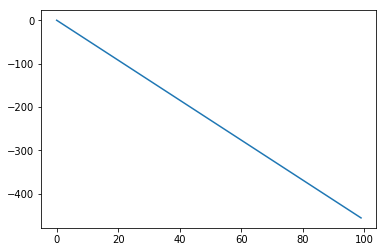

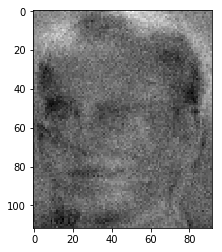

In [20]:

# np_page=np.random.random((112,92))
np_page=np.zeros((112,92))

dream_ga=ga(torch.Tensor((np_page)),net,100,1e-1,34)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')

## More generalized model

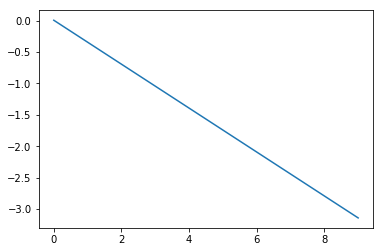

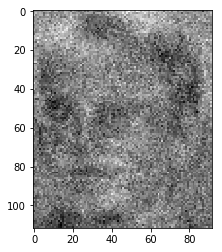

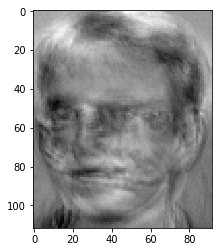

In [22]:
# np_page=np.random.random((112,92))
np_page=np.zeros((112,92))

dream_ga=ga(torch.Tensor((np_page)),net2,10,1e-1,34)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()
# plt.imsave("noisy.png",dream_ga.squeeze().cpu().detach().numpy(),cmap = 'gray',format='png')
# plt.imsave("noise.png",im0,cmap = 'gray',format='png')
# plt.imsave("noisy-noise.png",dream_ga.squeeze().cpu().detach().numpy()-im0,cmap = 'gray',format='png')
plt.imshow(dream_ga.squeeze().cpu().detach().numpy()-im0.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

In [ ]:
# # plt.imshow(dream_ga.squeeze().cpu().detach().numpy()-im0*.2253,cmap='gray')
# plt.imshow(dream_ga.mean().cpu().detach().numpy()-im_train*.2253,cmap='gray')
# print((dream_ga/im0).mean())
# # print((im0*dream_ga.mean().cpu().detach().numpy()/im0.mean()).mean())
# # print(dream_ga.squeeze().cpu().detach().numpy().mean())
# # print((dream_ga.mean().cpu().detach().numpy()/im_train).mean())
# plt.show()
# plt.imshow((dream_ga/im0).squeeze().cpu().detach().numpy(),vmin=100,vmax=1000)
# plt.show()

## Regularization

In [23]:
alpha_reg_alpha = 6
def alpha_norm(input_matrix, alpha):
        """
            Converts matrix to vector then calculates the alpha norm
        """
        alpha_norm = ((input_matrix.view(-1))**alpha).sum()
        return alpha_norm


def ga_norm(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses=[]

    for j in range(iterations):
        for i in range(1):

            net.zero_grad()
            out = nn.functional.softmax(net(input), dim=1)
            reg_alpha = alpha_norm(input, alpha_reg_alpha)/1000
            loss= -out.take(category)+reg_alpha
            
            loss.backward()
            input.data = input.data - lr * input.grad.data
            input.grad.zero_()
        print(j)
        print(loss.data)
        print(-out.take(category))
        losses.append(loss.data)
        plt.imshow(input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1)
        plt.show()
#         plt.imsave(f"Results/2Fred {j}.png",input.squeeze().cpu().detach().numpy(),cmap = 'gray',vmin =-1 , vmax = 1,format='png')
    plt.plot(losses)
    plt.show()

    
    return input

0
tensor([-0.0248], device='cuda:0')
tensor([-0.0248], device='cuda:0', grad_fn=<NegBackward>)


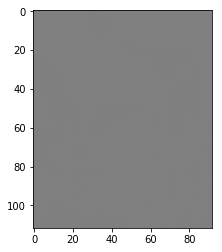

1
tensor([-0.0250], device='cuda:0')
tensor([-0.0250], device='cuda:0', grad_fn=<NegBackward>)


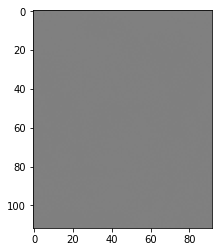

2
tensor([-0.0253], device='cuda:0')
tensor([-0.0253], device='cuda:0', grad_fn=<NegBackward>)


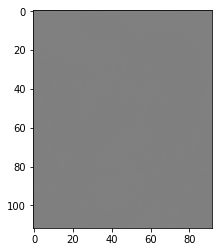

3
tensor([-0.0255], device='cuda:0')
tensor([-0.0255], device='cuda:0', grad_fn=<NegBackward>)


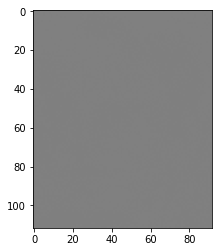

4
tensor([-0.0257], device='cuda:0')
tensor([-0.0257], device='cuda:0', grad_fn=<NegBackward>)


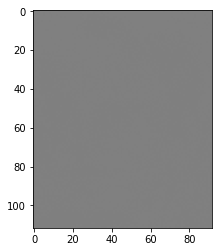

5
tensor([-0.0259], device='cuda:0')
tensor([-0.0259], device='cuda:0', grad_fn=<NegBackward>)


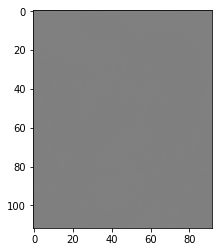

6
tensor([-0.0262], device='cuda:0')
tensor([-0.0262], device='cuda:0', grad_fn=<NegBackward>)


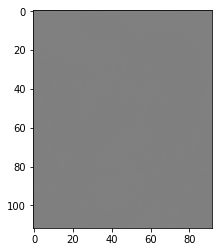

7
tensor([-0.0264], device='cuda:0')
tensor([-0.0264], device='cuda:0', grad_fn=<NegBackward>)


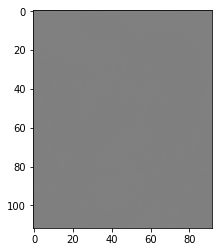

8
tensor([-0.0266], device='cuda:0')
tensor([-0.0266], device='cuda:0', grad_fn=<NegBackward>)


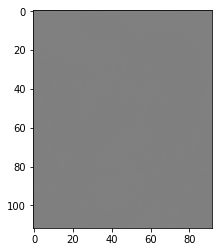

9
tensor([-0.0269], device='cuda:0')
tensor([-0.0269], device='cuda:0', grad_fn=<NegBackward>)


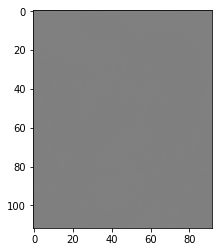

10
tensor([-0.0271], device='cuda:0')
tensor([-0.0271], device='cuda:0', grad_fn=<NegBackward>)


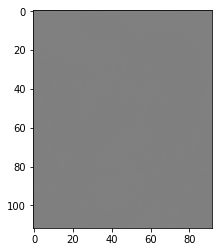

11
tensor([-0.0274], device='cuda:0')
tensor([-0.0274], device='cuda:0', grad_fn=<NegBackward>)


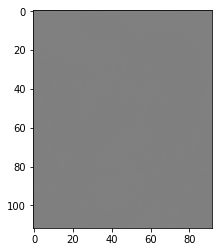

12
tensor([-0.0277], device='cuda:0')
tensor([-0.0277], device='cuda:0', grad_fn=<NegBackward>)


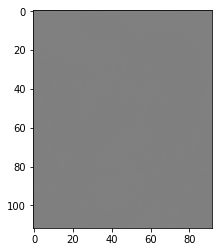

13
tensor([-0.0279], device='cuda:0')
tensor([-0.0279], device='cuda:0', grad_fn=<NegBackward>)


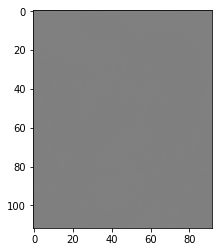

14
tensor([-0.0282], device='cuda:0')
tensor([-0.0282], device='cuda:0', grad_fn=<NegBackward>)


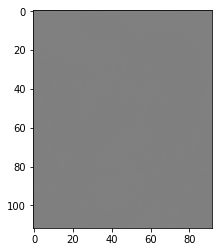

15
tensor([-0.0285], device='cuda:0')
tensor([-0.0285], device='cuda:0', grad_fn=<NegBackward>)


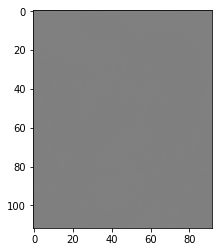

16
tensor([-0.0287], device='cuda:0')
tensor([-0.0287], device='cuda:0', grad_fn=<NegBackward>)


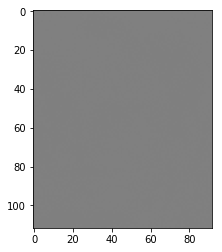

17
tensor([-0.0290], device='cuda:0')
tensor([-0.0290], device='cuda:0', grad_fn=<NegBackward>)


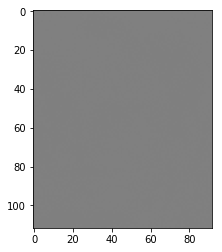

18
tensor([-0.0293], device='cuda:0')
tensor([-0.0293], device='cuda:0', grad_fn=<NegBackward>)


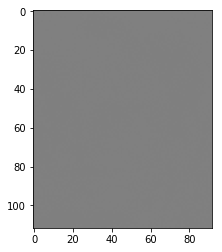

19
tensor([-0.0296], device='cuda:0')
tensor([-0.0296], device='cuda:0', grad_fn=<NegBackward>)


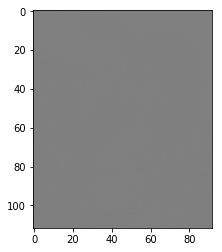

20
tensor([-0.0299], device='cuda:0')
tensor([-0.0299], device='cuda:0', grad_fn=<NegBackward>)


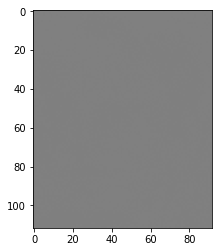

21
tensor([-0.0302], device='cuda:0')
tensor([-0.0302], device='cuda:0', grad_fn=<NegBackward>)


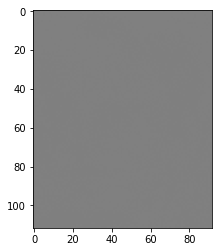

22
tensor([-0.0305], device='cuda:0')
tensor([-0.0305], device='cuda:0', grad_fn=<NegBackward>)


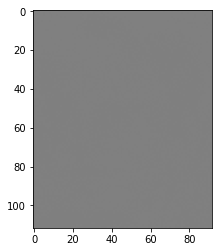

23
tensor([-0.0309], device='cuda:0')
tensor([-0.0309], device='cuda:0', grad_fn=<NegBackward>)


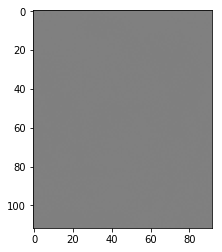

24
tensor([-0.0312], device='cuda:0')
tensor([-0.0312], device='cuda:0', grad_fn=<NegBackward>)


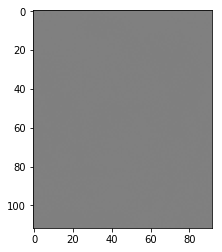

25
tensor([-0.0315], device='cuda:0')
tensor([-0.0315], device='cuda:0', grad_fn=<NegBackward>)


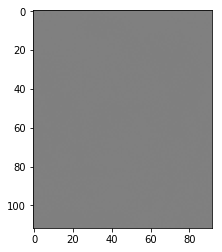

26
tensor([-0.0319], device='cuda:0')
tensor([-0.0319], device='cuda:0', grad_fn=<NegBackward>)


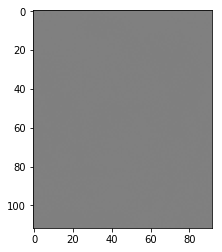

27
tensor([-0.0322], device='cuda:0')
tensor([-0.0322], device='cuda:0', grad_fn=<NegBackward>)


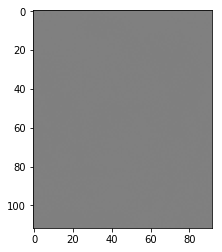

28
tensor([-0.0326], device='cuda:0')
tensor([-0.0326], device='cuda:0', grad_fn=<NegBackward>)


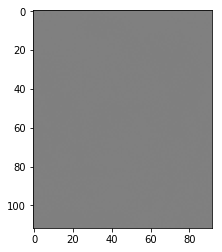

29
tensor([-0.0329], device='cuda:0')
tensor([-0.0329], device='cuda:0', grad_fn=<NegBackward>)


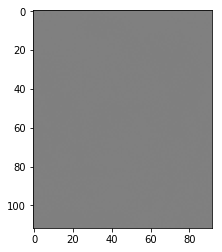

30
tensor([-0.0333], device='cuda:0')
tensor([-0.0333], device='cuda:0', grad_fn=<NegBackward>)


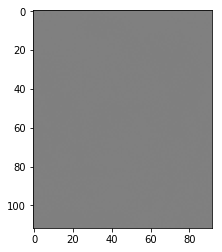

31
tensor([-0.0337], device='cuda:0')
tensor([-0.0337], device='cuda:0', grad_fn=<NegBackward>)


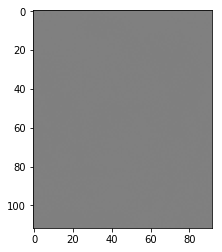

32
tensor([-0.0340], device='cuda:0')
tensor([-0.0340], device='cuda:0', grad_fn=<NegBackward>)


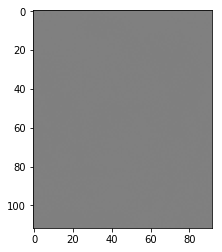

33
tensor([-0.0344], device='cuda:0')
tensor([-0.0344], device='cuda:0', grad_fn=<NegBackward>)


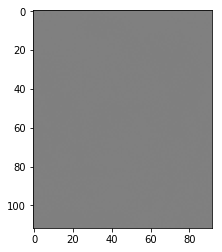

34
tensor([-0.0348], device='cuda:0')
tensor([-0.0348], device='cuda:0', grad_fn=<NegBackward>)


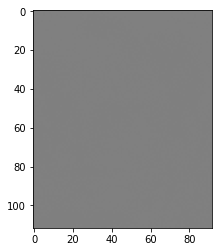

35
tensor([-0.0353], device='cuda:0')
tensor([-0.0353], device='cuda:0', grad_fn=<NegBackward>)


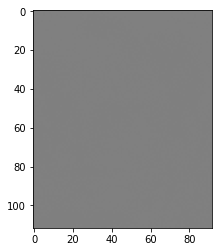

36
tensor([-0.0357], device='cuda:0')
tensor([-0.0357], device='cuda:0', grad_fn=<NegBackward>)


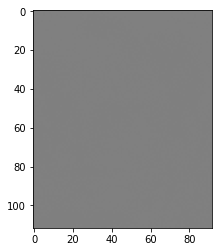

37
tensor([-0.0361], device='cuda:0')
tensor([-0.0361], device='cuda:0', grad_fn=<NegBackward>)


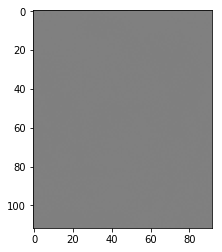

38
tensor([-0.0366], device='cuda:0')
tensor([-0.0366], device='cuda:0', grad_fn=<NegBackward>)


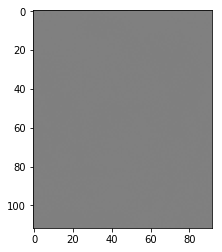

39
tensor([-0.0370], device='cuda:0')
tensor([-0.0370], device='cuda:0', grad_fn=<NegBackward>)


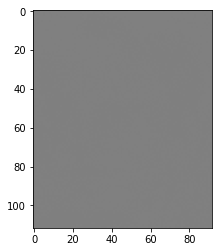

40
tensor([-0.0375], device='cuda:0')
tensor([-0.0375], device='cuda:0', grad_fn=<NegBackward>)


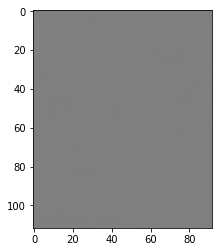

41
tensor([-0.0379], device='cuda:0')
tensor([-0.0379], device='cuda:0', grad_fn=<NegBackward>)


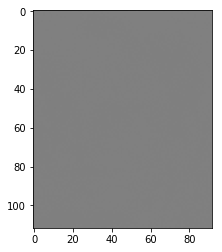

42
tensor([-0.0384], device='cuda:0')
tensor([-0.0384], device='cuda:0', grad_fn=<NegBackward>)


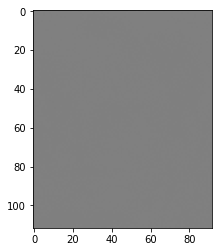

43
tensor([-0.0389], device='cuda:0')
tensor([-0.0389], device='cuda:0', grad_fn=<NegBackward>)


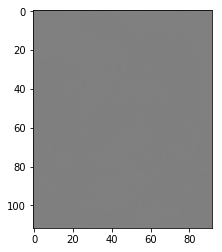

44
tensor([-0.0394], device='cuda:0')
tensor([-0.0394], device='cuda:0', grad_fn=<NegBackward>)


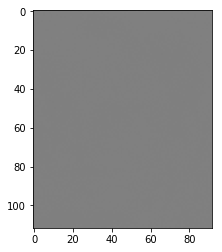

45
tensor([-0.0400], device='cuda:0')
tensor([-0.0400], device='cuda:0', grad_fn=<NegBackward>)


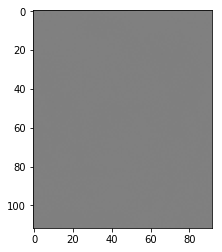

46
tensor([-0.0405], device='cuda:0')
tensor([-0.0405], device='cuda:0', grad_fn=<NegBackward>)


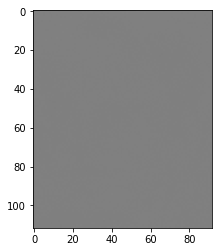

47
tensor([-0.0411], device='cuda:0')
tensor([-0.0411], device='cuda:0', grad_fn=<NegBackward>)


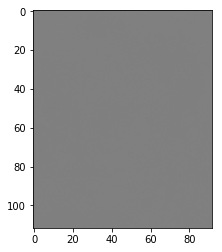

48
tensor([-0.0416], device='cuda:0')
tensor([-0.0416], device='cuda:0', grad_fn=<NegBackward>)


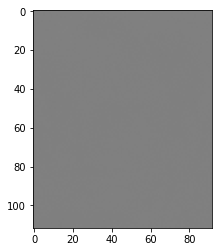

49
tensor([-0.0422], device='cuda:0')
tensor([-0.0422], device='cuda:0', grad_fn=<NegBackward>)


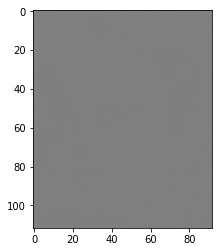

50
tensor([-0.0428], device='cuda:0')
tensor([-0.0428], device='cuda:0', grad_fn=<NegBackward>)


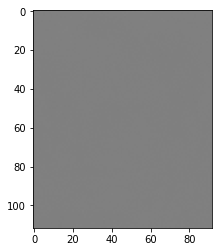

51
tensor([-0.0434], device='cuda:0')
tensor([-0.0434], device='cuda:0', grad_fn=<NegBackward>)


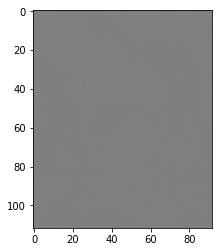

52
tensor([-0.0440], device='cuda:0')
tensor([-0.0440], device='cuda:0', grad_fn=<NegBackward>)


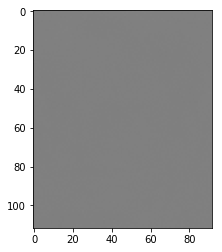

53
tensor([-0.0447], device='cuda:0')
tensor([-0.0447], device='cuda:0', grad_fn=<NegBackward>)


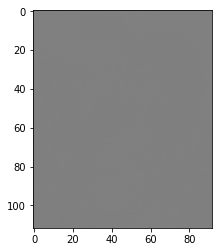

54
tensor([-0.0454], device='cuda:0')
tensor([-0.0454], device='cuda:0', grad_fn=<NegBackward>)


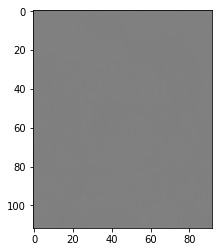

55
tensor([-0.0460], device='cuda:0')
tensor([-0.0460], device='cuda:0', grad_fn=<NegBackward>)


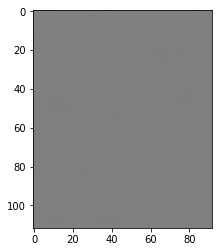

56
tensor([-0.0467], device='cuda:0')
tensor([-0.0467], device='cuda:0', grad_fn=<NegBackward>)


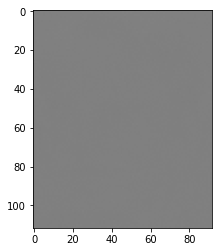

57
tensor([-0.0475], device='cuda:0')
tensor([-0.0475], device='cuda:0', grad_fn=<NegBackward>)


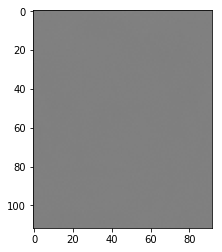

58
tensor([-0.0482], device='cuda:0')
tensor([-0.0482], device='cuda:0', grad_fn=<NegBackward>)


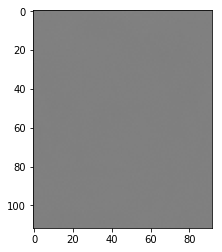

59
tensor([-0.0490], device='cuda:0')
tensor([-0.0490], device='cuda:0', grad_fn=<NegBackward>)


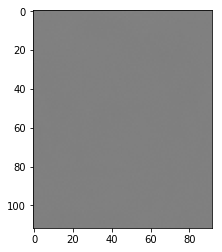

60
tensor([-0.0498], device='cuda:0')
tensor([-0.0498], device='cuda:0', grad_fn=<NegBackward>)


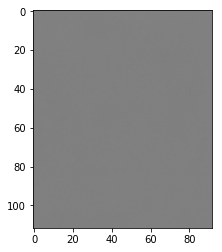

61
tensor([-0.0506], device='cuda:0')
tensor([-0.0506], device='cuda:0', grad_fn=<NegBackward>)


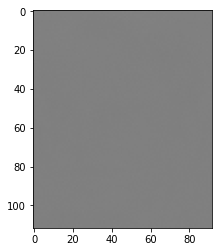

62
tensor([-0.0514], device='cuda:0')
tensor([-0.0514], device='cuda:0', grad_fn=<NegBackward>)


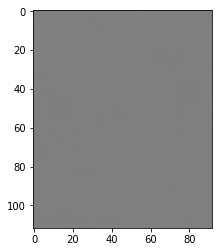

63
tensor([-0.0523], device='cuda:0')
tensor([-0.0523], device='cuda:0', grad_fn=<NegBackward>)


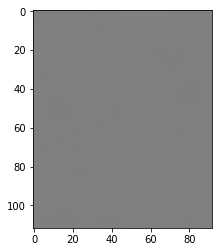

64
tensor([-0.0532], device='cuda:0')
tensor([-0.0532], device='cuda:0', grad_fn=<NegBackward>)


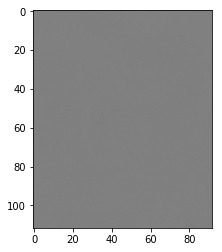

65
tensor([-0.0541], device='cuda:0')
tensor([-0.0541], device='cuda:0', grad_fn=<NegBackward>)


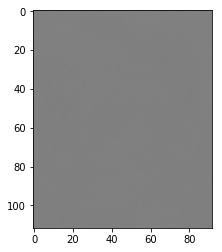

66
tensor([-0.0551], device='cuda:0')
tensor([-0.0551], device='cuda:0', grad_fn=<NegBackward>)


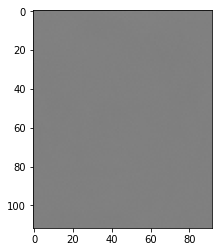

67
tensor([-0.0561], device='cuda:0')
tensor([-0.0561], device='cuda:0', grad_fn=<NegBackward>)


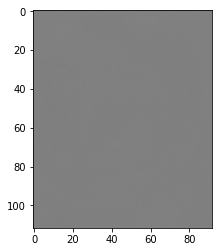

68
tensor([-0.0571], device='cuda:0')
tensor([-0.0571], device='cuda:0', grad_fn=<NegBackward>)


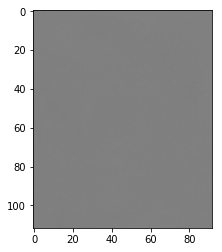

69
tensor([-0.0581], device='cuda:0')
tensor([-0.0581], device='cuda:0', grad_fn=<NegBackward>)


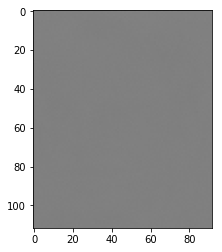

70
tensor([-0.0592], device='cuda:0')
tensor([-0.0592], device='cuda:0', grad_fn=<NegBackward>)


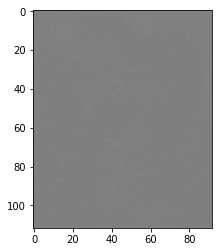

71
tensor([-0.0604], device='cuda:0')
tensor([-0.0604], device='cuda:0', grad_fn=<NegBackward>)


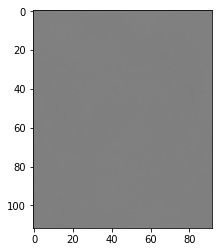

72
tensor([-0.0615], device='cuda:0')
tensor([-0.0615], device='cuda:0', grad_fn=<NegBackward>)


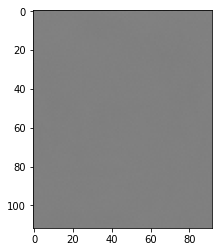

73
tensor([-0.0628], device='cuda:0')
tensor([-0.0628], device='cuda:0', grad_fn=<NegBackward>)


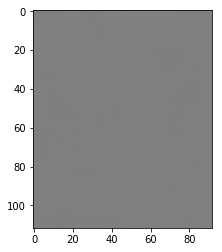

74
tensor([-0.0640], device='cuda:0')
tensor([-0.0640], device='cuda:0', grad_fn=<NegBackward>)


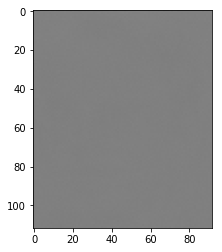

75
tensor([-0.0653], device='cuda:0')
tensor([-0.0653], device='cuda:0', grad_fn=<NegBackward>)


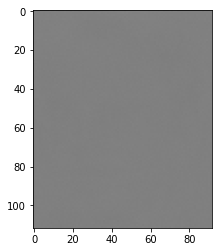

76
tensor([-0.0667], device='cuda:0')
tensor([-0.0667], device='cuda:0', grad_fn=<NegBackward>)


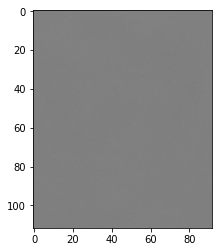

77
tensor([-0.0681], device='cuda:0')
tensor([-0.0681], device='cuda:0', grad_fn=<NegBackward>)


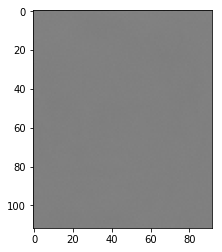

78
tensor([-0.0696], device='cuda:0')
tensor([-0.0696], device='cuda:0', grad_fn=<NegBackward>)


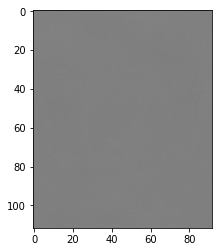

79
tensor([-0.0711], device='cuda:0')
tensor([-0.0711], device='cuda:0', grad_fn=<NegBackward>)


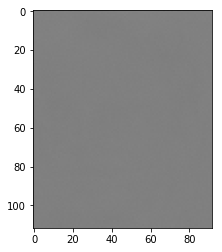

80
tensor([-0.0727], device='cuda:0')
tensor([-0.0727], device='cuda:0', grad_fn=<NegBackward>)


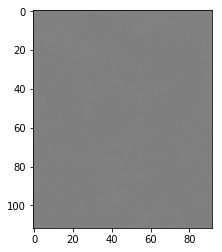

81
tensor([-0.0743], device='cuda:0')
tensor([-0.0743], device='cuda:0', grad_fn=<NegBackward>)


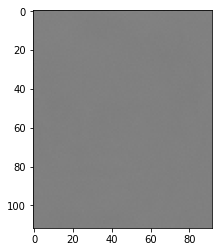

82
tensor([-0.0761], device='cuda:0')
tensor([-0.0761], device='cuda:0', grad_fn=<NegBackward>)


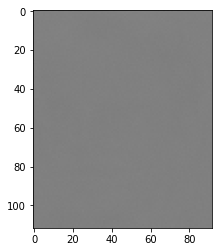

83
tensor([-0.0779], device='cuda:0')
tensor([-0.0779], device='cuda:0', grad_fn=<NegBackward>)


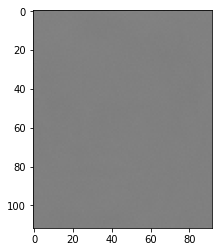

84
tensor([-0.0798], device='cuda:0')
tensor([-0.0798], device='cuda:0', grad_fn=<NegBackward>)


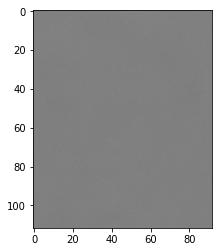

85
tensor([-0.0817], device='cuda:0')
tensor([-0.0817], device='cuda:0', grad_fn=<NegBackward>)


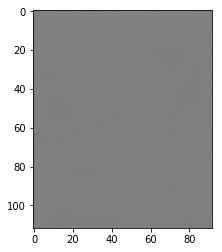

86
tensor([-0.0838], device='cuda:0')
tensor([-0.0838], device='cuda:0', grad_fn=<NegBackward>)


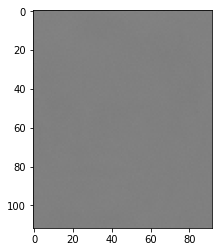

87
tensor([-0.0859], device='cuda:0')
tensor([-0.0859], device='cuda:0', grad_fn=<NegBackward>)


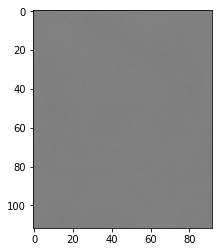

88
tensor([-0.0882], device='cuda:0')
tensor([-0.0882], device='cuda:0', grad_fn=<NegBackward>)


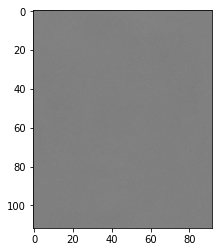

89
tensor([-0.0905], device='cuda:0')
tensor([-0.0905], device='cuda:0', grad_fn=<NegBackward>)


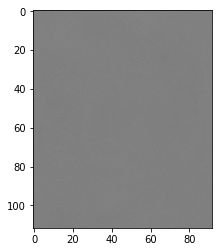

90
tensor([-0.0930], device='cuda:0')
tensor([-0.0930], device='cuda:0', grad_fn=<NegBackward>)


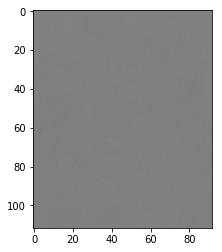

91
tensor([-0.0956], device='cuda:0')
tensor([-0.0956], device='cuda:0', grad_fn=<NegBackward>)


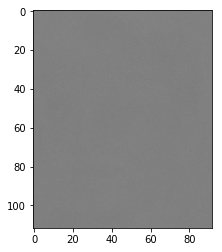

92
tensor([-0.0983], device='cuda:0')
tensor([-0.0983], device='cuda:0', grad_fn=<NegBackward>)


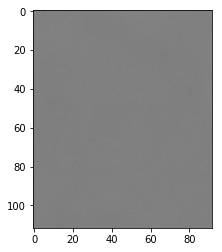

93
tensor([-0.1012], device='cuda:0')
tensor([-0.1012], device='cuda:0', grad_fn=<NegBackward>)


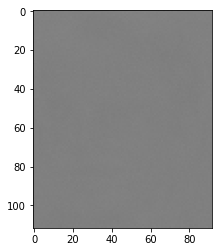

94
tensor([-0.1042], device='cuda:0')
tensor([-0.1042], device='cuda:0', grad_fn=<NegBackward>)


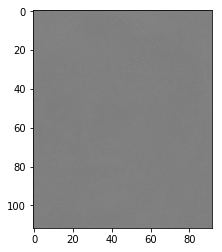

95
tensor([-0.1074], device='cuda:0')
tensor([-0.1074], device='cuda:0', grad_fn=<NegBackward>)


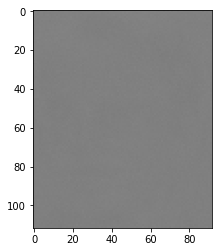

96
tensor([-0.1108], device='cuda:0')
tensor([-0.1108], device='cuda:0', grad_fn=<NegBackward>)


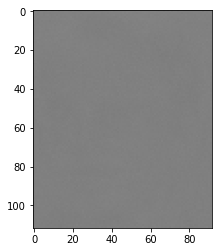

97
tensor([-0.1143], device='cuda:0')
tensor([-0.1143], device='cuda:0', grad_fn=<NegBackward>)


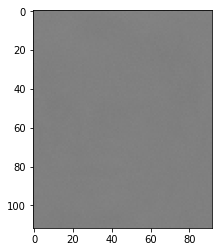

98
tensor([-0.1181], device='cuda:0')
tensor([-0.1181], device='cuda:0', grad_fn=<NegBackward>)


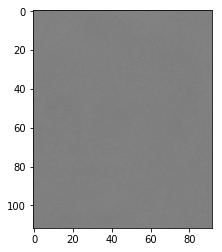

99
tensor([-0.1220], device='cuda:0')
tensor([-0.1220], device='cuda:0', grad_fn=<NegBackward>)


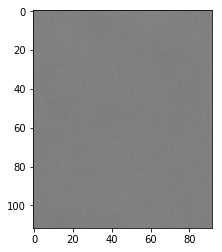

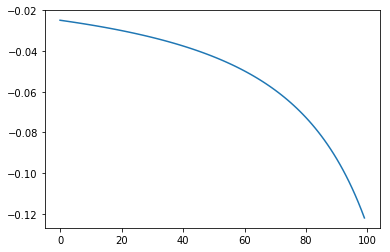

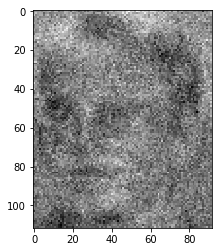

In [24]:
np_page=np.zeros((112,92))

dream_ga=ga_norm(torch.Tensor((np_page)),net2,100,1e-1,34)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')

## Auto-Encoder

Auto-encoder uses the target model as the encoder and inverts it to create the decoder. Overall reconstructs the same thing as GA but does it in 1 pass.

TODO: train decoder with shadow images.

In [81]:
print(ww.max(), ww.min())
noise = 0.01 * torch.randn(ww.shape).to(device) + 0.05
print(type(noise))
print(noise.max())
print(noise.min())
print(noise.shape)
ww = ww + noise
net2.hidden1.weight.data[:] = net2.hidden1.weight.data[:] + noise
print(ww)
print(net2.hidden1.weight.data[:])
print(ww == net2.hidden1.weight.data[:])

tensor(0.0991, device='cuda:0') tensor(-0.0813, device='cuda:0')
<class 'torch.Tensor'>
tensor(0.0971, device='cuda:0')
tensor(0.0046, device='cuda:0')
torch.Size([40, 10304])
tensor([[0.0154, 0.0369, 0.0436,  ..., 0.0307, 0.0349, 0.0619],
        [0.0706, 0.0534, 0.0587,  ..., 0.0363, 0.0275, 0.0406],
        [0.0388, 0.0326, 0.0167,  ..., 0.0239, 0.0662, 0.0272],
        ...,
        [0.0427, 0.0722, 0.0363,  ..., 0.0591, 0.0810, 0.0422],
        [0.0845, 0.0478, 0.0611,  ..., 0.0595, 0.0599, 0.0374],
        [0.0559, 0.0567, 0.0778,  ..., 0.0332, 0.0621, 0.0489]],
       device='cuda:0')
tensor([[0.0154, 0.0369, 0.0436,  ..., 0.0307, 0.0349, 0.0619],
        [0.0706, 0.0534, 0.0587,  ..., 0.0363, 0.0275, 0.0406],
        [0.0388, 0.0326, 0.0167,  ..., 0.0239, 0.0662, 0.0272],
        ...,
        [0.0427, 0.0722, 0.0363,  ..., 0.0591, 0.0810, 0.0422],
        [0.0845, 0.0478, 0.0611,  ..., 0.0595, 0.0599, 0.0374],
        [0.0559, 0.0567, 0.0778,  ..., 0.0332, 0.0621, 0.0489]],
    

In [82]:
class ae(nn.Module): 
    def __init__(self, n_in=112*92, n_out=40, n_hidden=3000): 
        super(ae, self).__init__()
        
        self.hidden1 = nn.Linear(n_in, n_out)        
        self.hidden2 = nn.Linear(n_out, n_in)
    def forward(self, x):
        x = x.view(-1,112*92)

        x = self.hidden1(x)
        out = self.hidden2(x)
        
        return out
    
class de(nn.Module): 
    def __init__(self, n_in=40, n_out=112*92, n_hidden=3000): 
        super(de, self).__init__()
        self.hidden1 = nn.Linear(n_in, n_out)        
        
    def forward(self, x):
        x = x.view(-1,40)
        out = self.hidden1(x)
        
        return out

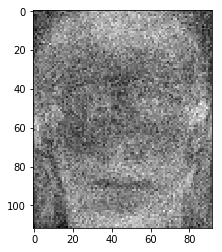

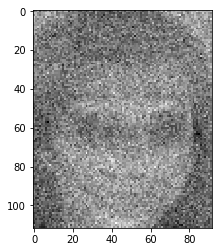

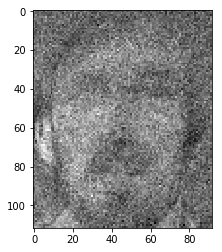

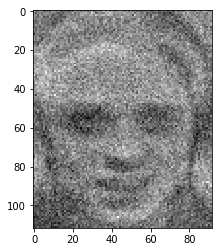

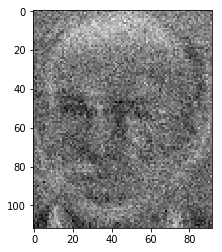

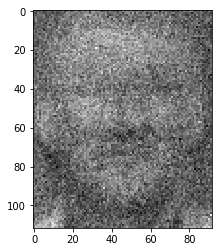

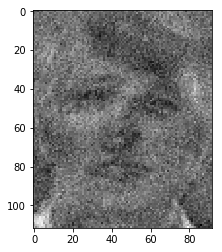

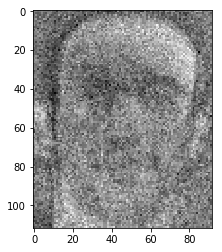

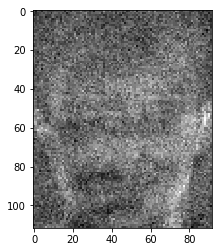

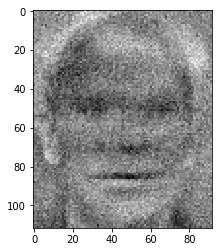

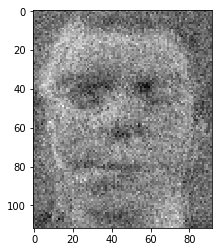

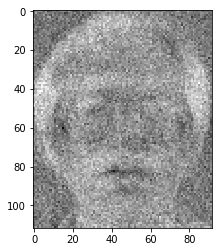

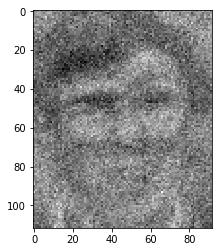

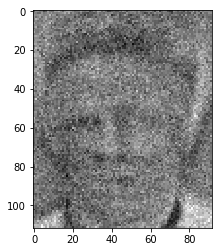

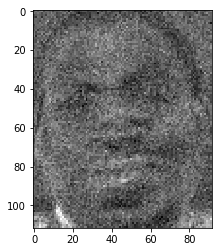

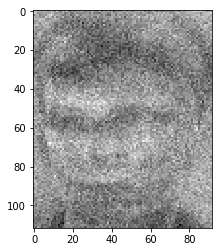

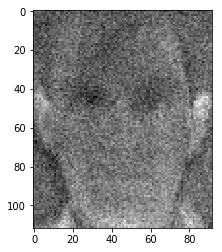

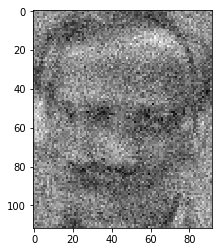

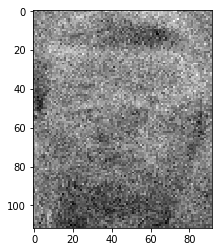

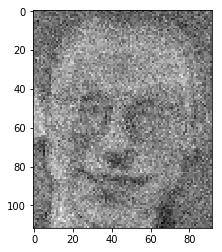

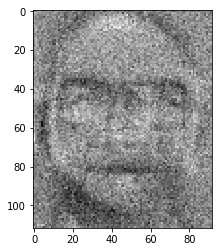

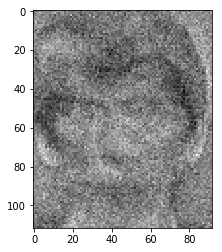

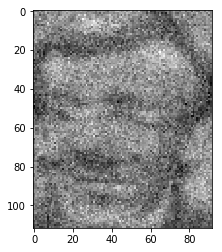

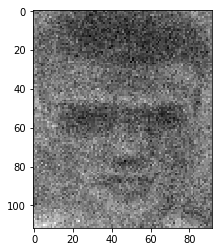

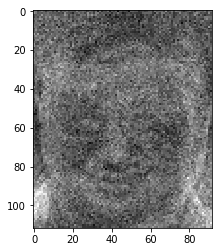

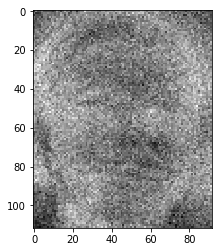

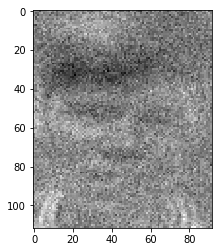

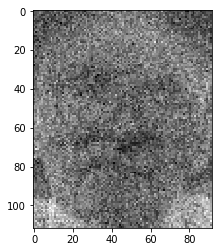

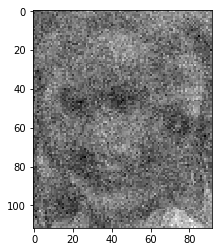

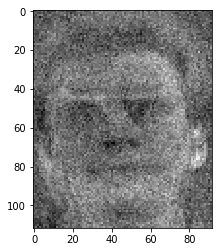

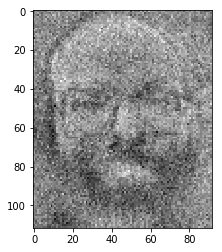

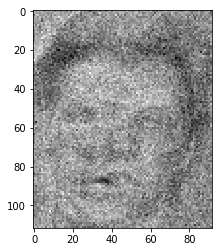

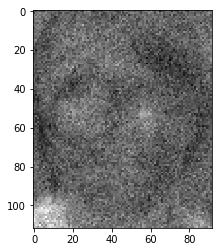

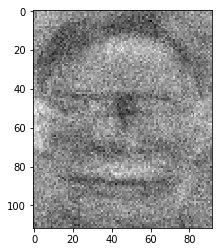

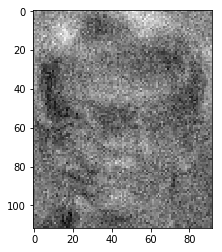

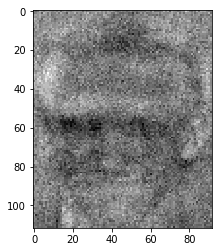

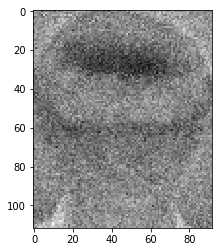

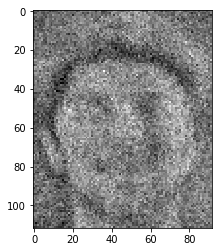

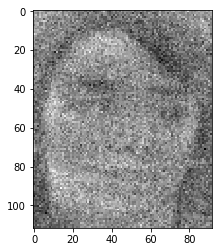

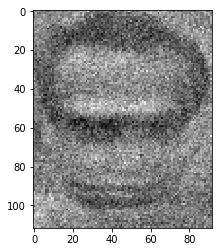

In [83]:
netAE = ae().to(device)
netDE = de().to(device)
ainv = np.linalg.pinv(net2.hidden1.weight.data.squeeze().cpu().detach().numpy())

netAE.hidden1.weight.data = net2.hidden1.weight.data
netAE.hidden2.weight.data = torch.tensor(ainv).to(device)
netDE.hidden1.weight.data = torch.tensor(ainv).to(device)

netAE.hidden1.bias.data = torch.tensor(0.0).to(device)
netAE.hidden2.bias.data = torch.tensor(0.0).to(device)
netDE.hidden1.bias.data = torch.tensor(0.0).to(device)

ww = net2.hidden1.weight.data
bb = net2.hidden1.bias.data

for i in range(40):
    im = ww[i,:].squeeze().cpu().detach().numpy().reshape(112,92)
    imAE = netAE(ww[i,:].to(device))
    label = torch.zeros(40)
    label[i]=1
    imDE = netDE(label.to(device))
#     plt.imshow(imDE.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
#     plt.show()
    tmp = imAE.squeeze().cpu().detach().numpy().reshape(112,92)-ww0[i,:].squeeze().cpu().detach().numpy().reshape(112,92)
    plt.imshow(tmp,cmap='gray')
    plt.imsave('.\\ae\\{0}'.format(idx_to_people[i]), tmp,cmap='gray')
    plt.show()


<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> torch.Size([4, 572, 754])
<class 'numpy.ndarray'> (4, 572, 754)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39])
tensor(0.)
tensor(1.)
torch.Size([40, 4, 112, 92])


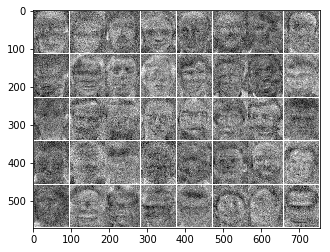

In [84]:
class MLPdataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    def __getitem__(self, idx): 
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        data = np.asarray(img)
        label = people_to_idx[img_path.split('\\')[-1].split('.')[-2]]
        if self.transform is not None: 
            img = self.transform(img)
        
        return img, label

mlp_dir = ".\\ae\\"

mlp_paths = []
for p in os.listdir(mlp_dir): 
    mlp_paths.append(os.path.join(mlp_dir,p))
        
mlpset = MLPdataset(mlp_paths, people_to_idx, transform=torchvision.transforms.ToTensor())
mlploader = torch.utils.data.DataLoader(mlpset, batch_size=40, shuffle=False, num_workers=0)

mlp_imgs,labels = iter(mlploader).next()
print(type(mlp_imgs), type(torchvision.utils.make_grid(mlp_imgs)))
imshow(torchvision.utils.make_grid(mlp_imgs), 'ae') 
print(labels)
print(mlp_imgs.min())
print(mlp_imgs.max())
print(mlp_imgs.shape)

In [85]:
ww = ww - noise
net2.hidden1.weight.data[:] = net2.hidden1.weight.data[:] - noise
print(ww, net2.hidden1.weight.data[:])

tensor([[-0.0306, -0.0153, -0.0047,  ..., -0.0318, -0.0105,  0.0056],
        [ 0.0348,  0.0121,  0.0042,  ..., -0.0196, -0.0135, -0.0074],
        [-0.0310, -0.0172, -0.0275,  ..., -0.0156,  0.0093, -0.0286],
        ...,
        [-0.0070,  0.0233, -0.0040,  ...,  0.0165,  0.0338,  0.0016],
        [ 0.0267, -0.0057,  0.0103,  ...,  0.0135,  0.0132, -0.0075],
        [-0.0029,  0.0039,  0.0154,  ..., -0.0047,  0.0081,  0.0048]],
       device='cuda:0') tensor([[-0.0306, -0.0153, -0.0047,  ..., -0.0318, -0.0105,  0.0056],
        [ 0.0348,  0.0121,  0.0042,  ..., -0.0196, -0.0135, -0.0074],
        [-0.0310, -0.0172, -0.0275,  ..., -0.0156,  0.0093, -0.0286],
        ...,
        [-0.0070,  0.0233, -0.0040,  ...,  0.0165,  0.0338,  0.0016],
        [ 0.0267, -0.0057,  0.0103,  ...,  0.0135,  0.0132, -0.0075],
        [-0.0029,  0.0039,  0.0154,  ..., -0.0047,  0.0081,  0.0048]],
       device='cuda:0')


## Posterior Averaging

Posterior averaging works by taking a weighted average of a sample of images weghing it by the posterior activation of a particular category. 
Works well but depends on the information that you already have in your sample images

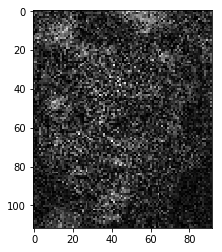

In [28]:
out_sum = torch.cuda.FloatTensor(np.zeros((1,112,92)))
n = torch.cuda.FloatTensor(np.zeros((1)))
# for j in range(100):
for i, batch in enumerate(testloader):
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)

    out = nn.functional.softmax(net2(imgs), dim = 1 )
    out_im=(imgs*torch.tensor(np.abs(im)).to(device))

    out_sum =  (out_sum * n + torch.sum(out_im*out[:,34].view(-1,1,1,1),dim=0)) / (n + (imgs.size()[0]))
    n = n + (imgs.size()[0])
plt.imshow(out_sum.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

You can also just use the weighted average of the sample images weighted by the posterior probablity and not including the activation weighting. This works better for good sample images.

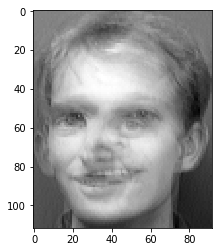

In [29]:

out_sum = torch.cuda.FloatTensor(np.zeros((1,112,92)))
n = torch.cuda.FloatTensor(np.zeros((1)))
# for j in range(100):
for i, batch in enumerate(testloader):
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)

    out = nn.functional.softmax(net2(imgs), dim = 1 )
    out_im=(imgs).to(device)

    out_sum =  (out_sum * n + torch.sum(out_im*out[:,34].view(-1,1,1,1),dim=0)) / (n + (imgs.size()[0]))
    n = n + (imgs.size()[0])
plt.imshow(out_sum.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

## Student-teacher

In [30]:
student = mlp().to(device)
student.apply(models.weights_init)

ww_student = copy.deepcopy(student.hidden1.weight.data)
bb_student = copy.deepcopy(student.hidden1.bias.data[:])
im_student = ww_student[34].reshape(112,92)

criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer_student = optim.Adam(student.parameters(), lr=lr/10)

In [31]:
def train_student(student, teacher, data_loader, optimizer, criterion, n_epochs, classes=None, verbose=False):
    losses = []
    train_accuracy = []
        
    for epoch in range(n_epochs):
        student.train()
        teacher.eval()
        net2.hidden1.weight.requires_grad=False
        total = 0
        correct = 0
        for i, batch in enumerate(data_loader):

            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)
            
#             imgs = torch.randn(imgs.size()).to(device)
#             im = torch.zeros(imgs.size())
#             for i in range(imgs.size(0)):
#                 imgs[i,0,:,:] = tensorBlur(imgs[i,:,:,:].squeeze(),15)
            optimizer.zero_grad()

            outputs = student(imgs)
            output_teacher = teacher(imgs).detach()
            
            ## accuracy calc
            predicted = outputs.argmax(dim=1)
            total += imgs.size(0)
            correct += predicted.eq(labels).sum().item()
            ##

#             loss = criterion(outputs, labels)
            loss = criterion(outputs, output_teacher)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if verbose:
                print("[%d/%d][%d/%d] loss = %f" % (epoch, n_epochs, i, len(data_loader), loss.item()))

        # evaluate performance on testset at the end of each epoch
        print("[%d/%d]" %(epoch, n_epochs))
#         train_accuracy.append(eval_target_net(net, data_loader, classes=classes))
        train_accuracy.append(correct/total*100)
#         test_accuracy.append(eval_target_net(net, test_loader, classes=classes))
        print("Train Accuracy %f" %(correct/total*100))
#         print(train_accuracy)
#         plt.plot(train_accuracy,'bo-',label="train accuracy")
        plt.plot(losses,'bo-',label="losses")
#         plt.plot(test_accuracy,'ro-',label="validation accuracy")
        
        # Place a legend to the right of this smaller subplot.
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        plt.show()

[0/100]
Train Accuracy 5.000000


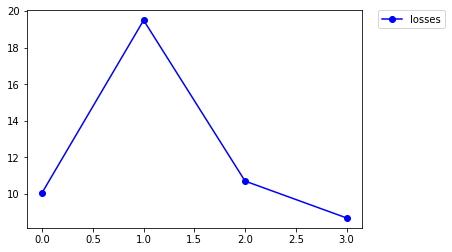

[1/100]
Train Accuracy 6.666667


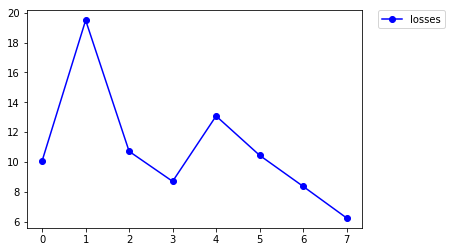

[2/100]
Train Accuracy 15.833333


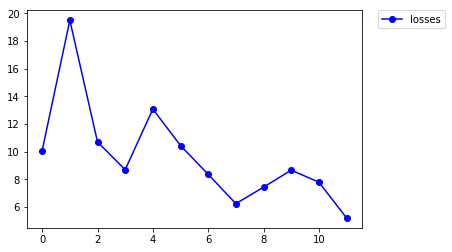

[3/100]
Train Accuracy 29.166667


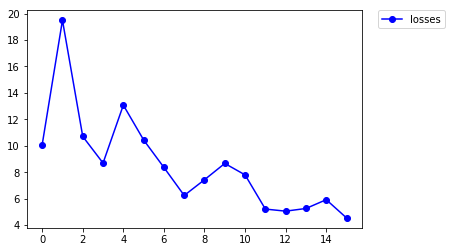

[4/100]
Train Accuracy 35.833333


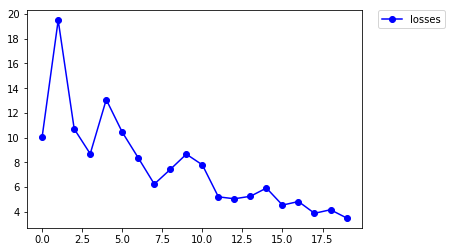

[5/100]
Train Accuracy 55.000000


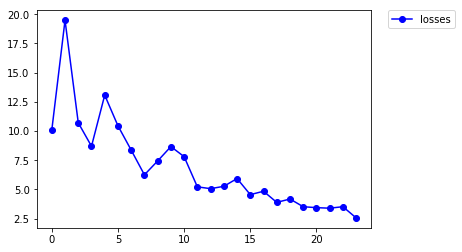

[6/100]
Train Accuracy 46.666667


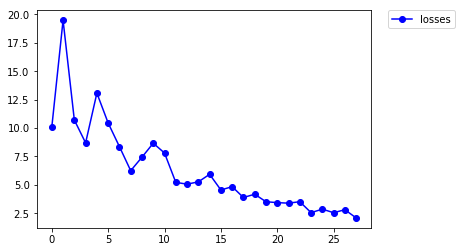

[7/100]
Train Accuracy 62.500000


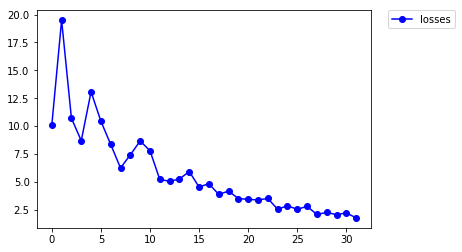

[8/100]
Train Accuracy 66.666667


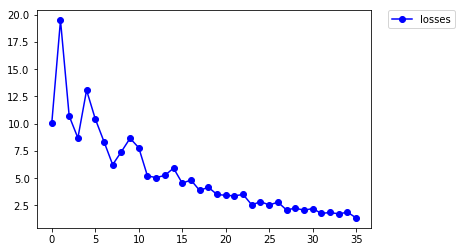

[9/100]
Train Accuracy 70.833333


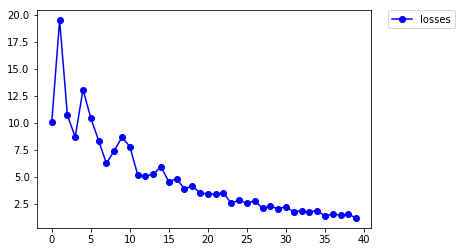

[10/100]
Train Accuracy 80.833333


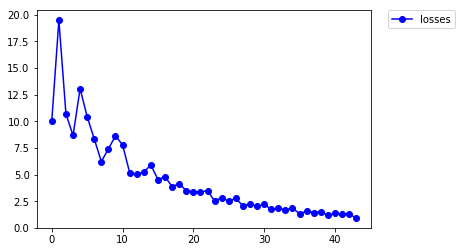

[11/100]
Train Accuracy 80.833333


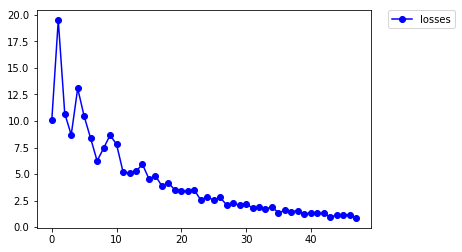

[12/100]
Train Accuracy 82.500000


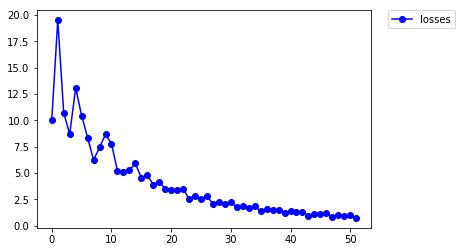

[13/100]
Train Accuracy 84.166667


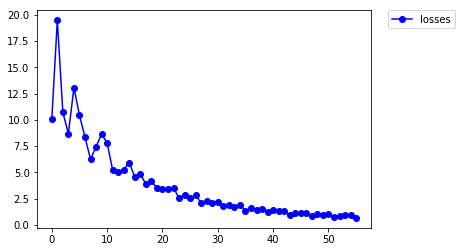

[14/100]
Train Accuracy 87.500000


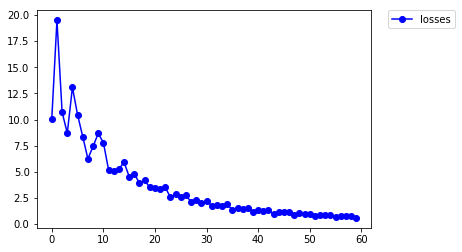

[15/100]
Train Accuracy 90.000000


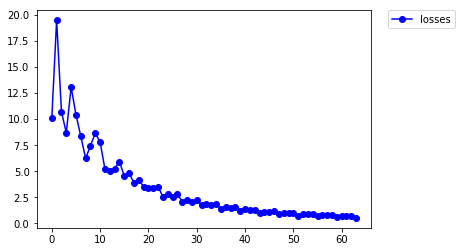

[16/100]
Train Accuracy 92.500000


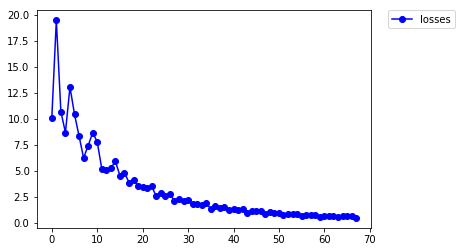

[17/100]
Train Accuracy 93.333333


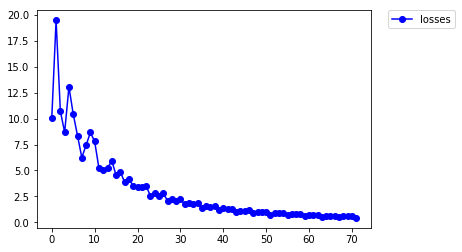

[18/100]
Train Accuracy 93.333333


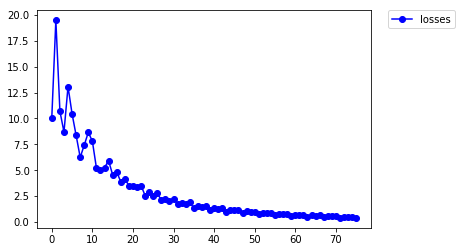

[19/100]
Train Accuracy 94.166667


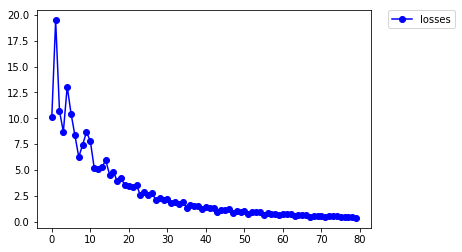

[20/100]
Train Accuracy 94.166667


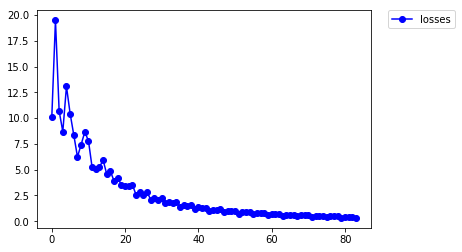

[21/100]
Train Accuracy 94.166667


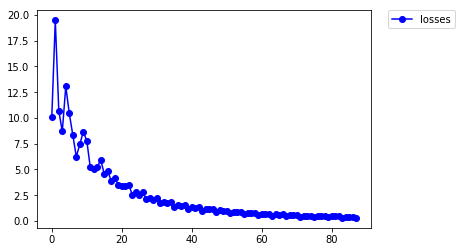

[22/100]
Train Accuracy 94.166667


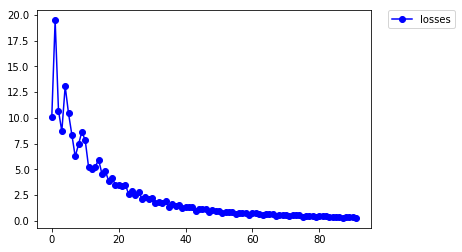

[23/100]
Train Accuracy 94.166667


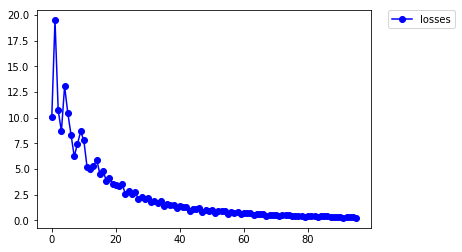

[24/100]
Train Accuracy 94.166667


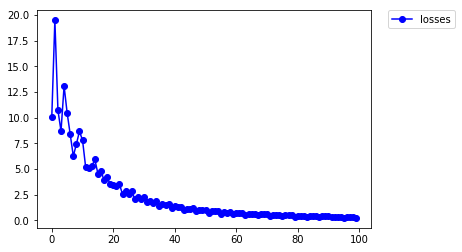

[25/100]
Train Accuracy 94.166667


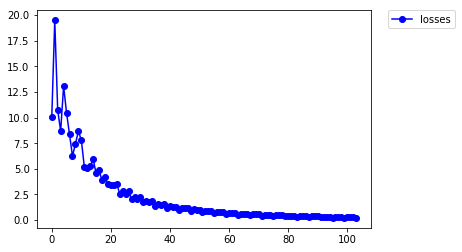

[26/100]
Train Accuracy 94.166667


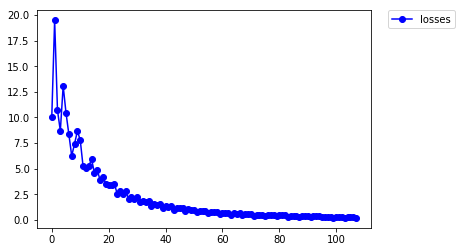

[27/100]
Train Accuracy 95.000000


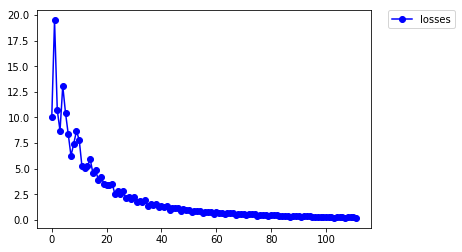

[28/100]
Train Accuracy 95.000000


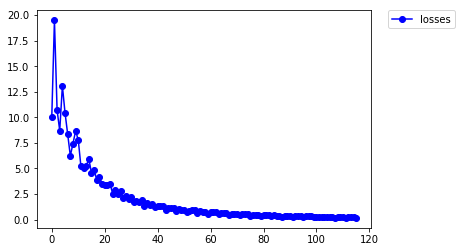

[29/100]
Train Accuracy 95.000000


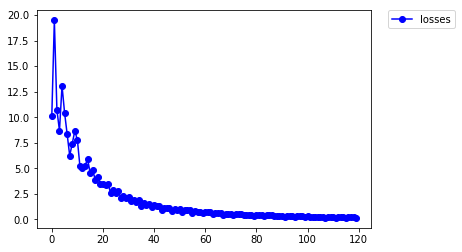

[30/100]
Train Accuracy 95.000000


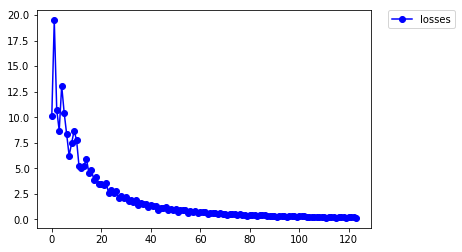

[31/100]
Train Accuracy 95.000000


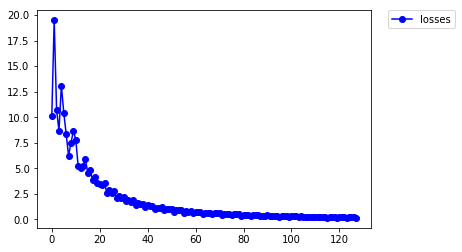

[32/100]
Train Accuracy 95.000000


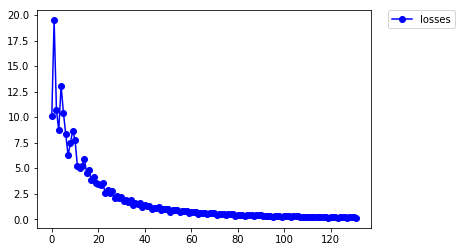

[33/100]
Train Accuracy 95.000000


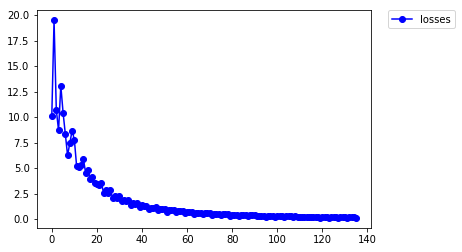

[34/100]
Train Accuracy 95.000000


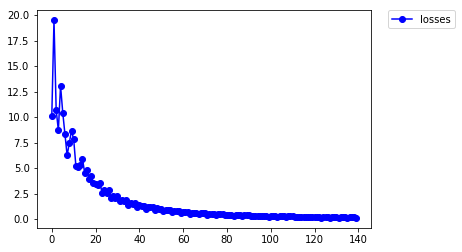

[35/100]
Train Accuracy 95.000000


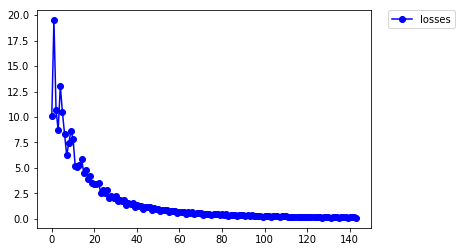

[36/100]
Train Accuracy 95.000000


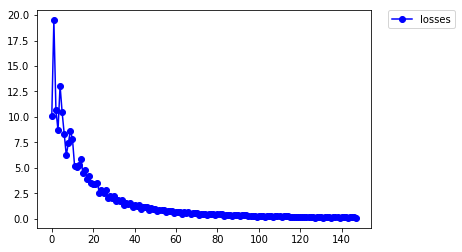

[37/100]
Train Accuracy 95.000000


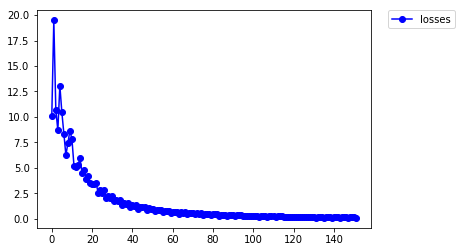

[38/100]
Train Accuracy 95.000000


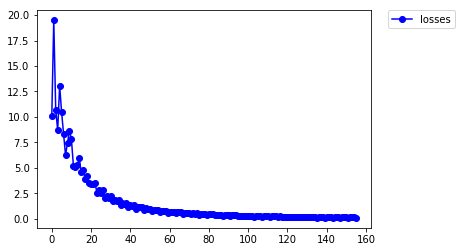

[39/100]
Train Accuracy 95.000000


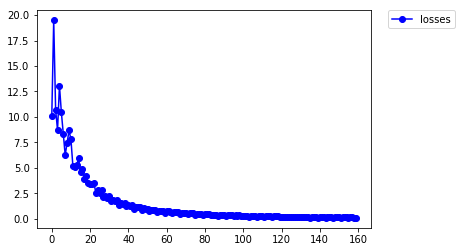

[40/100]
Train Accuracy 95.833333


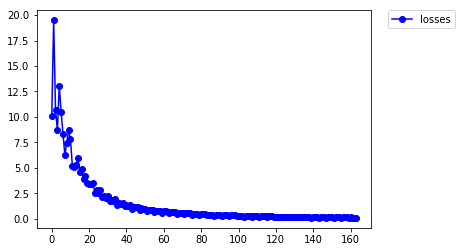

[41/100]
Train Accuracy 95.833333


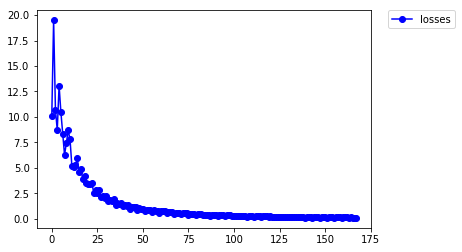

[42/100]
Train Accuracy 95.833333


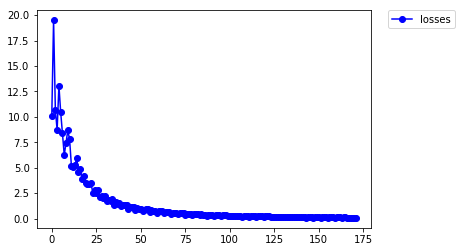

[43/100]
Train Accuracy 95.833333


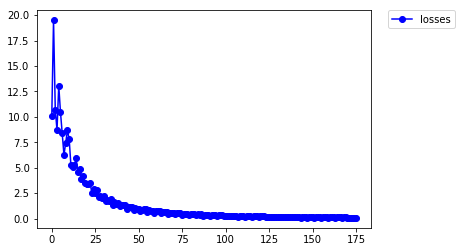

[44/100]
Train Accuracy 95.833333


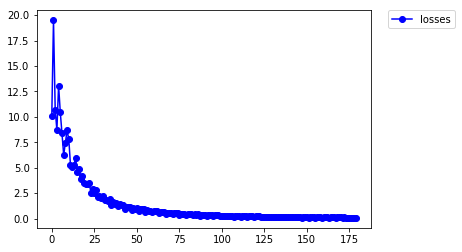

[45/100]
Train Accuracy 95.833333


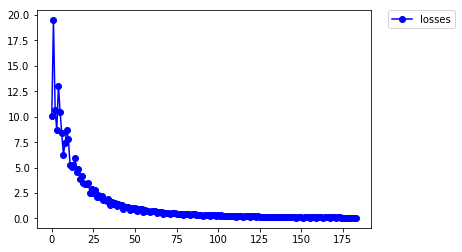

[46/100]
Train Accuracy 95.833333


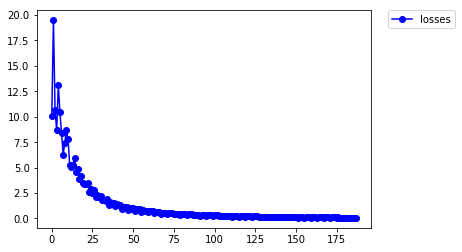

[47/100]
Train Accuracy 95.833333


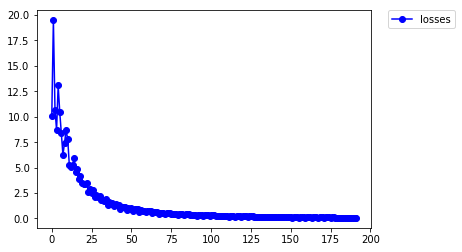

[48/100]
Train Accuracy 95.833333


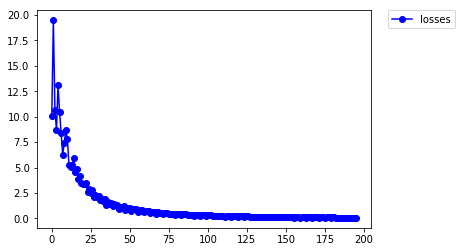

[49/100]
Train Accuracy 95.833333


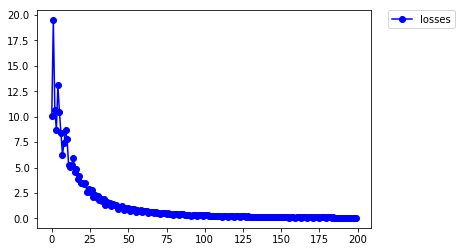

[50/100]
Train Accuracy 95.833333


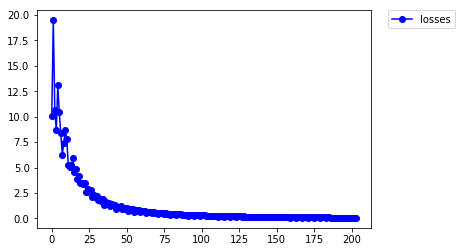

[51/100]
Train Accuracy 95.833333


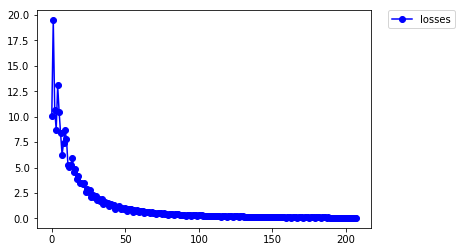

[52/100]
Train Accuracy 95.833333


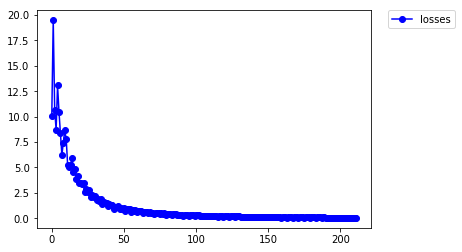

[53/100]
Train Accuracy 95.833333


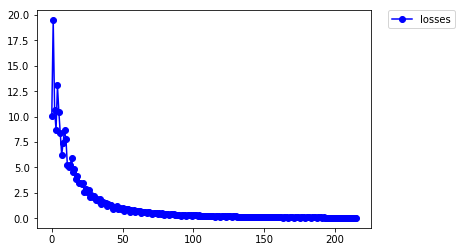

[54/100]
Train Accuracy 95.833333


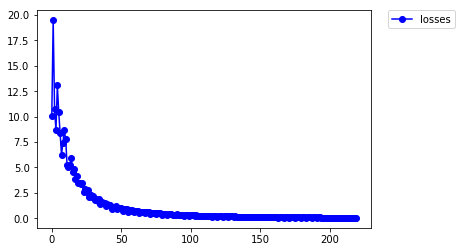

[55/100]
Train Accuracy 95.833333


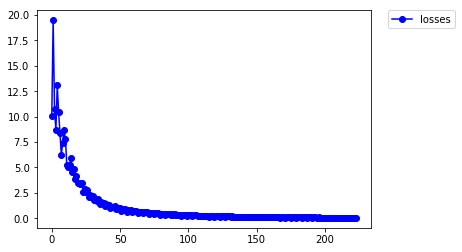

[56/100]
Train Accuracy 95.833333


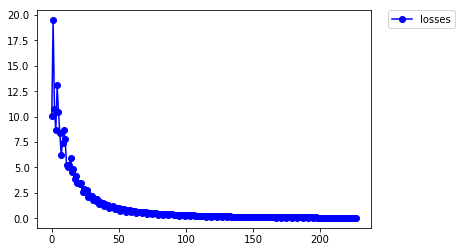

[57/100]
Train Accuracy 95.833333


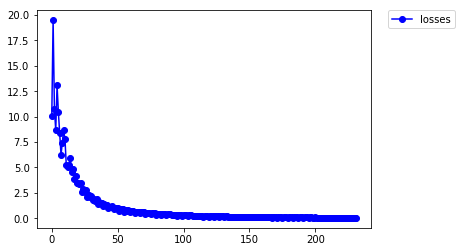

[58/100]
Train Accuracy 95.833333


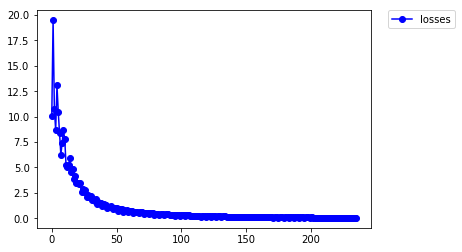

[59/100]
Train Accuracy 95.833333


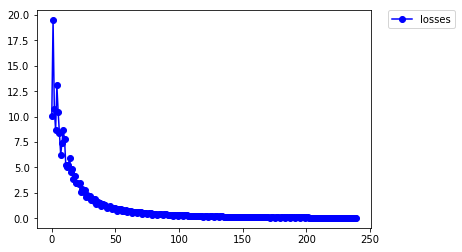

[60/100]
Train Accuracy 95.833333


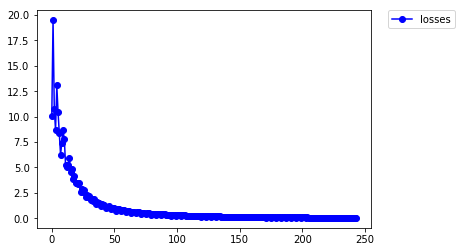

[61/100]
Train Accuracy 95.833333


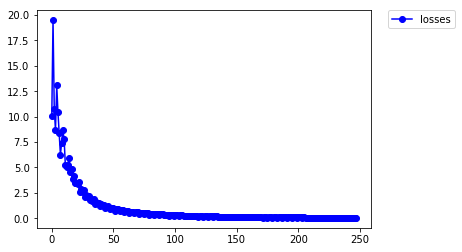

[62/100]
Train Accuracy 95.833333


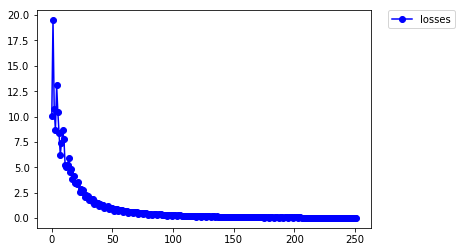

[63/100]
Train Accuracy 95.833333


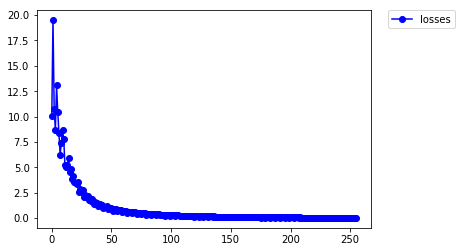

[64/100]
Train Accuracy 95.833333


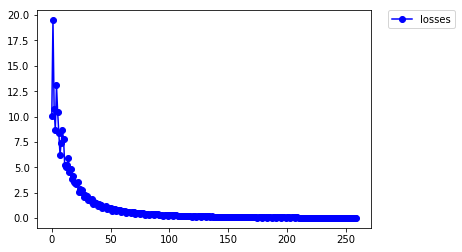

[65/100]
Train Accuracy 95.833333


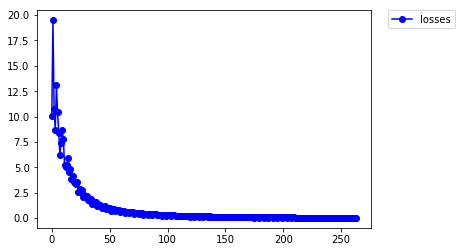

[66/100]
Train Accuracy 95.833333


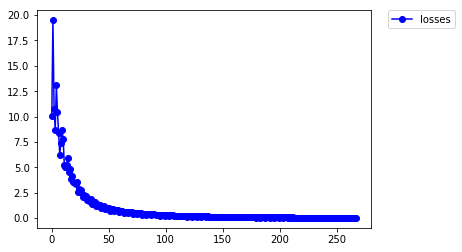

[67/100]
Train Accuracy 95.833333


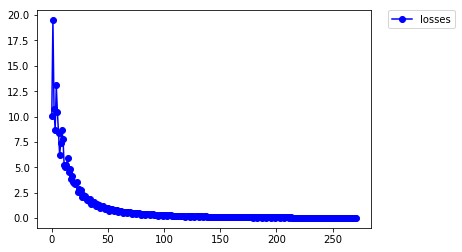

[68/100]
Train Accuracy 95.833333


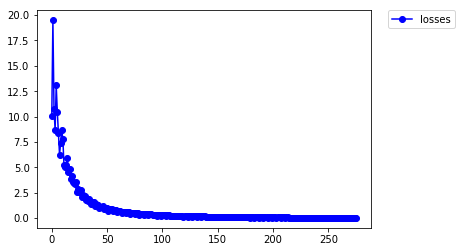

[69/100]
Train Accuracy 95.833333


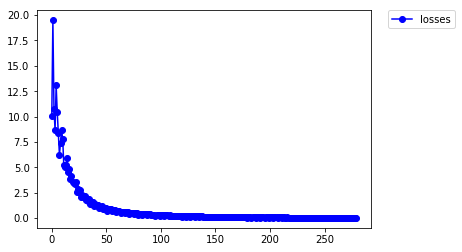

[70/100]
Train Accuracy 95.833333


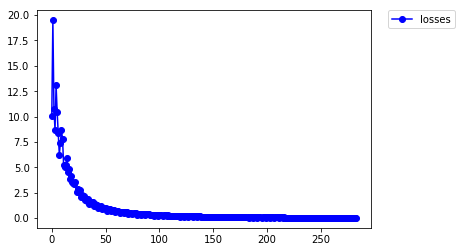

[71/100]
Train Accuracy 95.833333


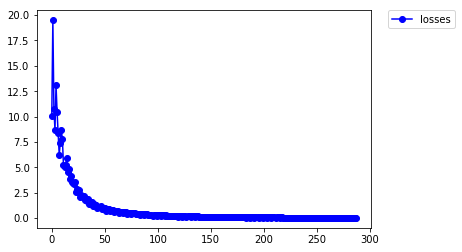

[72/100]
Train Accuracy 95.833333


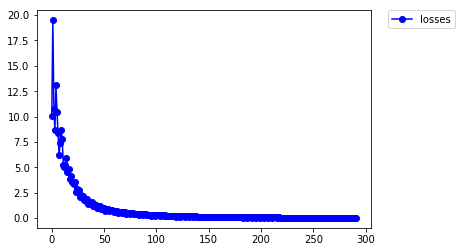

[73/100]
Train Accuracy 95.833333


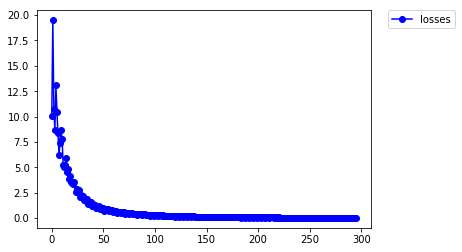

[74/100]
Train Accuracy 95.833333


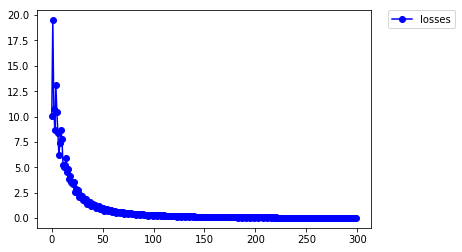

[75/100]
Train Accuracy 95.833333


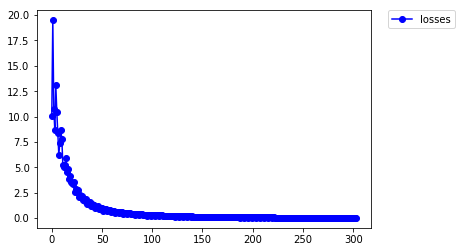

[76/100]
Train Accuracy 95.833333


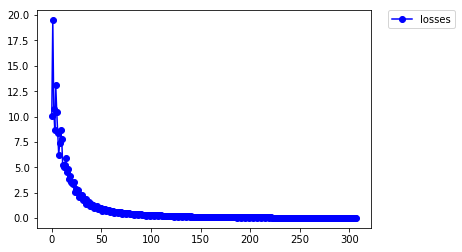

[77/100]
Train Accuracy 95.833333


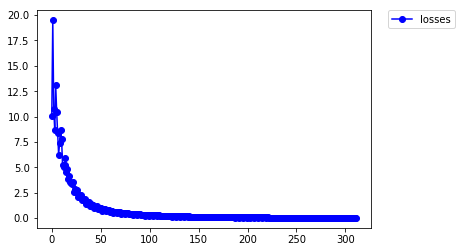

[78/100]
Train Accuracy 95.833333


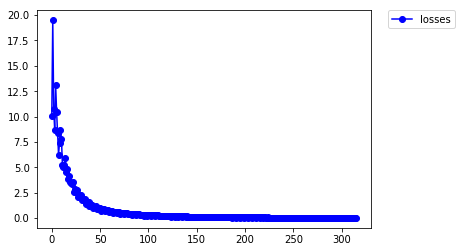

[79/100]
Train Accuracy 95.833333


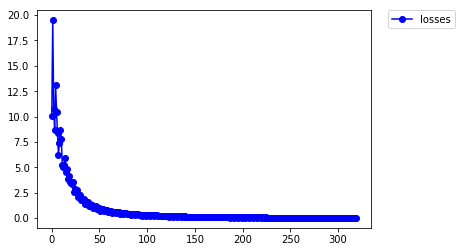

[80/100]
Train Accuracy 95.833333


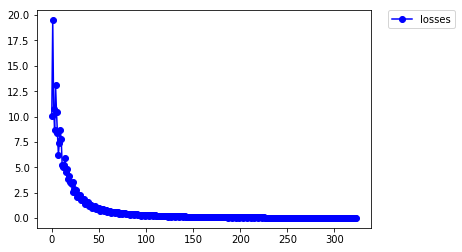

[81/100]
Train Accuracy 95.833333


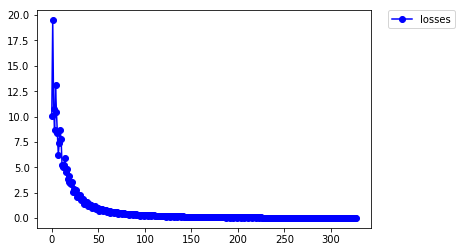

[82/100]
Train Accuracy 95.833333


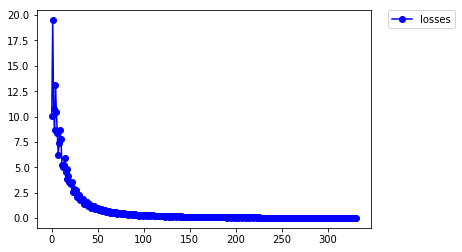

[83/100]
Train Accuracy 95.833333


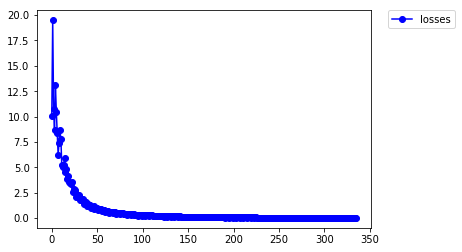

[84/100]
Train Accuracy 95.833333


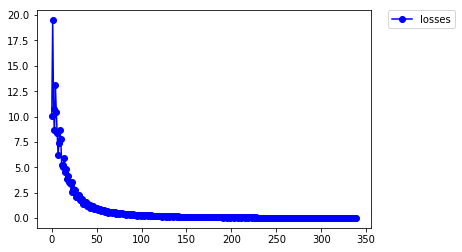

[85/100]
Train Accuracy 95.833333


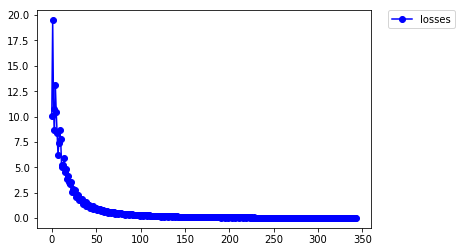

[86/100]
Train Accuracy 95.833333


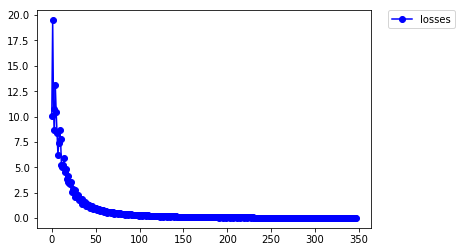

[87/100]
Train Accuracy 95.833333


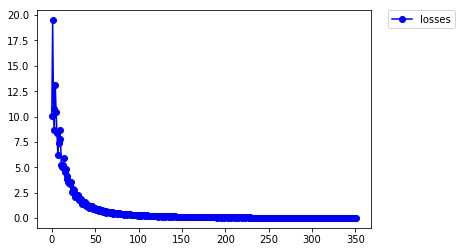

[88/100]
Train Accuracy 95.833333


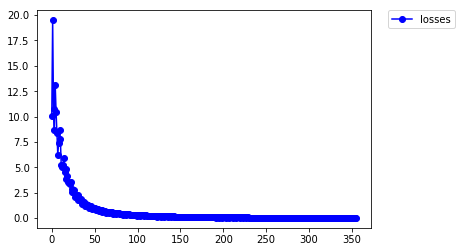

[89/100]
Train Accuracy 95.833333


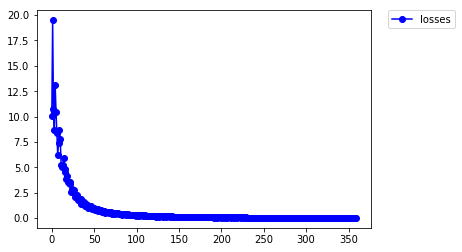

[90/100]
Train Accuracy 95.833333


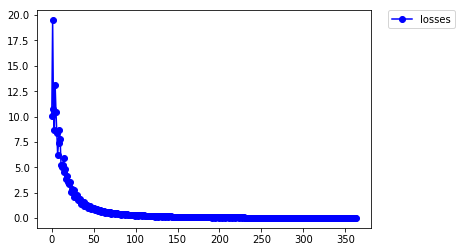

[91/100]
Train Accuracy 95.833333


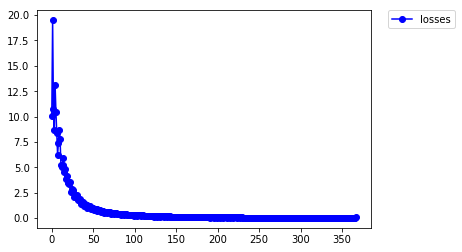

[92/100]
Train Accuracy 95.833333


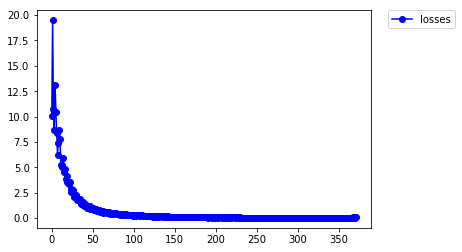

[93/100]
Train Accuracy 95.833333


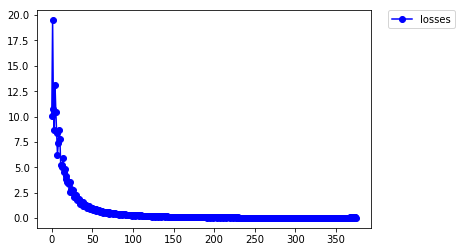

[94/100]
Train Accuracy 95.833333


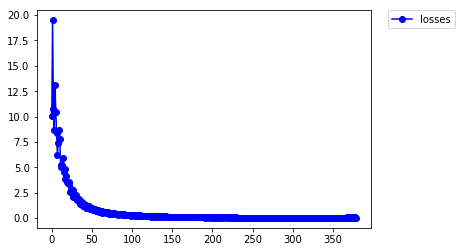

[95/100]
Train Accuracy 95.833333


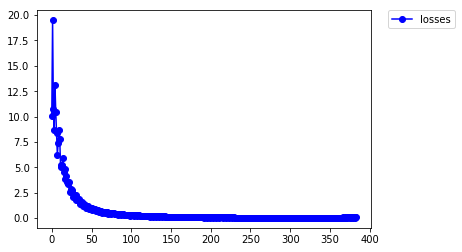

[96/100]
Train Accuracy 95.833333


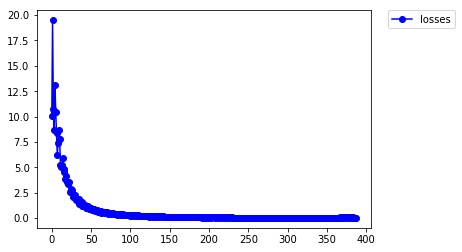

[97/100]
Train Accuracy 95.833333


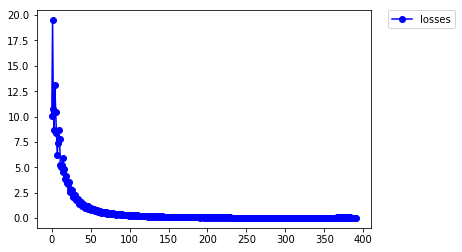

[98/100]
Train Accuracy 95.833333


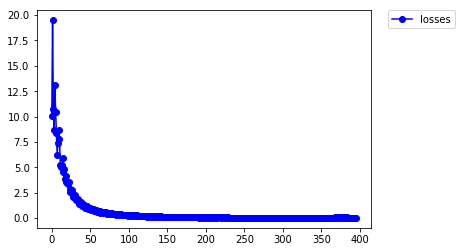

[99/100]
Train Accuracy 95.833333


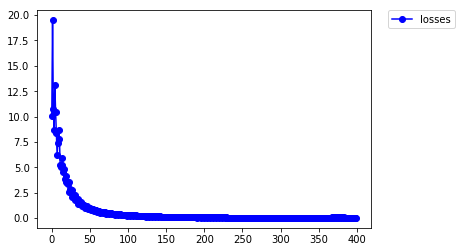

In [32]:
train_student(student, net2, testloader, optimizer_student, criterion, n_epochs=100, verbose=False)

Attack student with an attack we know works well on the student training/architecture. In this case we will use gradient ascent.


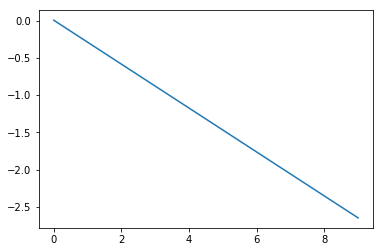

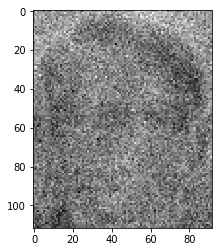

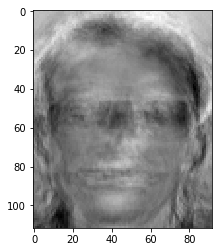

In [34]:
np_page=np.zeros((112,92))

dream_ga=ga(torch.Tensor((np_page)),student,10,1e-1,34)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

plt.imshow(dream_ga.squeeze().cpu().detach().numpy()-im_student.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

In [35]:
eval_target_net(net, testloader)


Accuracy = 92.50 %




92.5

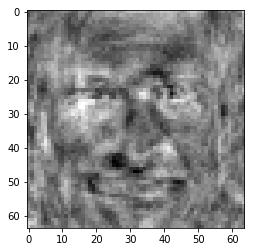

In [30]:
# net2.hidden1.weight.data = ww - ww0
net2.hidden1.bias.data = torch.tensor(0.0).to(device)
ww_net = copy.deepcopy(net2.hidden1.weight.data)
# bb_net = copy.deepcopy(net.hidden1.bias.data[:])x
im_net = ww_net[0].reshape(64,64)
plt.imshow(im_net.squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

In [31]:
print(labels.eq(0).sum())
print(out[:,0].sum())

tensor(0, device='cuda:0')
tensor(0.1203, device='cuda:0', grad_fn=<SumBackward0>)


<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', dtype=torch.float64)
torch.Size([24])
tensor([3.4658], device='cuda:0', grad_fn=<AddBackward0>)


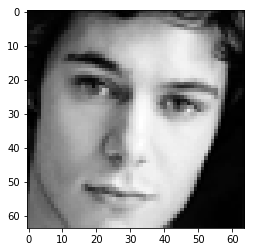

In [45]:
# testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)
out_sum = torch.cuda.FloatTensor(np.zeros((24)))
n = torch.cuda.FloatTensor(np.zeros((1)))
category = 1
for i, batch in enumerate(trainloader):

    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)
    
    out = nn.functional.softmax(net2(imgs), dim = 1 )    
    outputs = net2(imgs)
    out_sum = out_sum + ((out[:,category]>.5).float().view(-1,1)*outputs).sum(0)
    n = n + out[:,category].sum()

    if i ==0:
        break
# for i, batch in enumerate(testloader):

#     imgs, labels = batch
#     imgs, labels = imgs.to(device), labels.to(device)
    
#     out = nn.functional.softmax(net2(imgs), dim = 1 )    
#     outputs = net2(imgs)
#     out_sum = out_sum + ((out[:,category]>.5).float().view(-1,1)*outputs).sum(0)
#     n = n + out[:,category].sum()
print(type(labels==category))
print(type((labels==category).double()))
tmpt = (labels==category).double()
print(tmpt)
plt.imshow(imgs[tmpt.argmax(),:,:].squeeze().cpu(),cmap = 'gray')
outputs.argmax(1)
print(out_sum.size())
print(n)

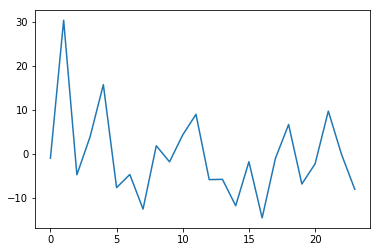

In [46]:
plt.plot(out_sum.cpu().detach().numpy())
plt.show()

In [47]:
def tensorRight(im):
    
    pad_filter = nn.ReflectionPad2d(1)
    gaussian_filter = nn.Conv2d(1, 1, 3,
                                stride = 1, bias=False, padding= 0)

    gaussian_filter.weight.data = torch.tensor([[0.0, 0.0, 0.0],[0.0, 0.0, 1.0], [0.0, 0.0, 0.0]]).cuda().view(1,1,kernel_size,kernel_size)
    
    gaussian_filter.to(device)
    pad_filter.to(device)
    
    out = gaussian_filter(pad_filter(im))
    return out

def tensorDown(im):
    pad_filter = nn.ReflectionPad2d(1)
    gaussian_filter = nn.Conv2d(1, 1, 3,
                                stride = 1, bias=False, padding= 0)

    gaussian_filter.weight.data = torch.tensor([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0], [0.0, 1.0, 0.0]]).cuda().view(1,1,kernel_size,kernel_size)
    
    gaussian_filter.to(device)
    pad_filter.to(device)

    out = gaussian_filter(pad_filter(im))
    return out
def TV(im):
    im_right = tensorRight(im)
    im_down = tensorDown(im)
    TV_fd = (im - im_right)**2 + (im - im_down)**2
    return TV_fd.sum()

In [48]:
from torch.autograd import Variable
def ga_feature(image, net, iterations, lr,category,discriminator,alpha):        
#     category = Variable(torch.cuda([category]))
    category = torch.tensor(category).to(device).detach().unsqueeze(0)
    loss_fn = nn.MSELoss()
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses = []
    loss = 20
    for j in range(iterations):
        for i in range(1):

            net.zero_grad()
            discriminator.zero_grad()
            out = net(input)
#             print(input.size())
            out2 = discriminator(input.unsqueeze(0))
#             print(input.size())
            loss = loss_fn(out, category) + out2*alpha#+ TV(input.unsqueeze(0))*1/(1+j/alpha)
            
            loss.backward()
            input.data = input.data - lr * input.grad.data
            input.grad.zero_()
        losses.append(loss.data)
#     plt.plot(losses)
#     plt.show()
    input = input.detach()
    return input



def ga2(image, net, iterations, lr,category):        
    category = Variable(torch.cuda.LongTensor([category]))
    input = Variable(image.unsqueeze(0).cuda(), requires_grad=True)
    losses = []
    
    for j in range(iterations):
        for i in range(1):
            net.zero_grad()           
            out = net(input)
            loss= -out.take(category)            
            loss.backward()
            input.data = input.data - lr * input.grad.data
            input.grad.zero_()
        losses.append(loss.data)
        

    plt.plot(losses)
    plt.show()
    return input

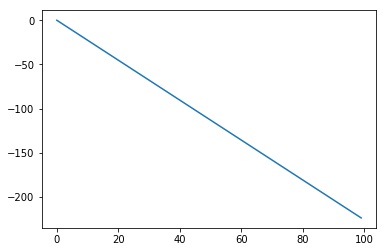

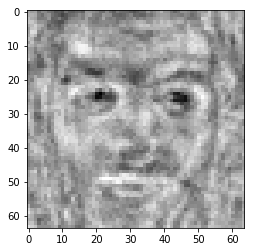

In [49]:
np_page=np.zeros((64,64))
dream_ga=ga2(torch.Tensor((np_page)),net2,100,1e-1,category)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')

In [51]:
# np_page=torch.rand((112,92))
np_page=torch.zeros((64,64))
# im00 = imgs[(labels==0).argmax(),:,:].squeeze().cpu()
# np_page = torch.tensor(im00)

dream_ga=ga_feature(np_page,net2,1000,1e-1,out_sum/n,1)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')


TypeError: ga_feature() missing 1 required positional argument: 'alpha'

In [52]:
class disc_model(nn.Module):    
    def __init__(self, n_out = 1):
        super(disc_model,self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), 
            nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.full_connected = nn.Sequential(
            nn.Linear(64*28*23,200),
            nn.LeakyReLU(),
            nn.Linear(200, n_out),
#             nn.Softmax()
        )
    def forward(self, x):
        b_size = x.shape[0]
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
#         print(x.size())
        x = self.full_connected(x.view(b_size,64*28*23))
        x = F.sigmoid(x)
        return x
    
# class disc_model(nn.Module):
#     def __init__(self,num_classes = 10):
#         super(disc_model, self).__init__()
        
#         # Convolution 1
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 16, 3, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.5, inplace=False),
#         )
#         # Convolution 2
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(16, 32, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.5, inplace=False),
#         )
#         # Convolution 3
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(32, 64, 3, 2, 1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.5, inplace=False),
#         )
#         # Convolution 4
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(64, 128, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.5, inplace=False),
#         )
#         # Convolution 5
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(128, 256, 3, 2, 1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.5, inplace=False),
#         )
#         # Convolution 6
#         self.conv6 = nn.Sequential(
#             nn.Conv2d(256, 512, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.5, inplace=False),
#         )
#         # discriminator fc
#         self.fc_dis = nn.Sequential(
#              nn.Linear(14*12*512, 512),
#              nn.LeakyReLU(0.2, inplace=True))
        
#         self.fc_dis2 = nn.Sequential(
#              nn.Linear(512, 1),
#              nn.LeakyReLU(0.2, inplace=True))
#         # softmax and sigmoid
        
#         self.sigmoid = nn.Sigmoid()

               
        
#     def forward(self, x):
       
#         conv1 = self.conv1(x)
#         conv2 = self.conv2(conv1)
#         conv3 = self.conv3(conv2)
#         conv4 = self.conv4(conv3)
#         conv5 = self.conv5(conv4)
#         conv6 = self.conv6(conv5)
# #         print(conv6.size())
#         flat6 = conv6.view(-1, 14*12*512)
# #         print(flat6.size())
#         fc_dis = self.fc_dis(flat6) 
# #         print(fc_dis.size())
#         fc_dis2 = self.fc_dis2(fc_dis) 
        
#         realfake = self.sigmoid(fc_dis2).view(-1, 1).squeeze(1)

#         return realfake
        

discriminator = disc_model().to(device)
discriminator.apply(models.weights_init)


disc_model(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (full_connected): Sequential(
    (0): Linear(in_features=41216, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [ ]:
# def train_denoise(student, data_loader, optimizer, criterion, n_epochs, classes=None, verbose=False):
losses = []
losses_fake = []
train_accuracy = []
criterion = nn.BCELoss() 
real_accuracy = []
fake_accuracy = []
num_epochs = 30
# d_optimizer = optim.Adam(discriminator.parameters(), lr = lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002, betas=(0.5, 0.999))

for epoch in range(num_epochs):
    for i, batch in enumerate(testloader):

        real_correct = 0
        fake_correct = 0  
        total = 1

        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        
        d_optimizer.zero_grad()

        outputs = net(imgs.detach())
            
        #  2A: Train D on real
        d_real_decision = discriminator(imgs.detach())
        d_real_error = criterion(d_real_decision, torch.zeros(imgs.size(0)).to(device).unsqueeze(1))  
        d_real_error.backward() # compute/store gradients, but don't change params
        
        
        imgs_fake = torch.zeros(imgs.size())
        #  2B: Train D on fake 
        for jj in range(outputs.size(0)):
            np_page=torch.zeros((112,92))
            dream_ga=ga_feature(np_page,net,20,1e-1,outputs[jj,:],discriminator,0).detach()
            net.zero_grad()
            imgs_fake[jj,:,:,:] = dream_ga.data.detach()
        
        d_fake_decision = discriminator(imgs_fake.to(device))
        d_fake_error = criterion(d_fake_decision, torch.ones(imgs.size(0)).to(device).unsqueeze(1))  # ones = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()                      
        losses.append(d_real_error)
        losses_fake.append(d_fake_error)
    ## accuracy calc
        real_correct += (1-torch.round(d_real_decision)).sum()
        fake_correct += ((torch.round(d_fake_decision))).sum()
        
        total += imgs.size(0)

    real_accuracy.append(real_correct/total*100)
    fake_accuracy.append(fake_correct/total*100)

    plt.plot(real_accuracy,'bo-',label="train accuracy")
    plt.plot(fake_accuracy,'ro-',label="train accuracy")

    plt.show()
    plt.plot(losses,'bo-',label="train accuracy")
    plt.plot(losses_fake,'ro-',label="train accuracy")
    
    plt.show()
    plt.imshow(imgs_fake[0,:,:,:].squeeze().cpu().detach().numpy(),cmap='gray')
    plt.show()

        

In [ ]:
plt.imshow(imgs[0,:,:,:].squeeze().cpu().detach().numpy(),cmap='gray')
plt.show()

In [ ]:
dream_ga=ga_feature(np_page,net,20,1e-1,outputs[jj,:],discriminator).detach()

In [ ]:
d_real_decision

In [ ]:
d_real_decision = F.sigmoid(discriminator(imgs))

In [ ]:
dream_ga=ga_feature(dream_ga.squeeze(),net2,10000,1e-1,out_sum/n,0)
plt.imshow(dream_ga.squeeze().cpu().detach().numpy(),cmap='gray')

In [ ]:
plt.imshow(imgs[(labels==0).argmax(),:,:].squeeze(),cmap = 'gray')
plt.show()
imAE2 = netAE(imgs[(labels==0).argmax(),:,:]).reshape((112,92))
plt.imshow(imAE2.squeeze().cpu().detach().numpy(),cmap = 'gray')
plt.show()

In [ ]:
netDE = de().to(device)
ainv = np.linalg.pinv(net.hidden1.weight.data)
netDE.hidden1.weight.data = torch.tensor(ainv).to(device)
netDE.hidden1.bias.data = torch.tensor(0.0).to(device)

imDE = netDE((out_sum*100).to(device))
plt.imshow(imDE.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()

plt.plot(out_sum.cpu().detach().numpy())
plt.show()

plt.plot(net(imDE).squeeze().cpu().detach().numpy()/out_sum.cpu().detach().numpy())
plt.show()

In [ ]:
code = net(ww[0,:])

imcode = netDE(code.to(device))
plt.imshow(imcode.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()

plt.plot(net(ww[0,:]).squeeze().cpu().detach().numpy())
plt.show()

In [ ]:
net(imDE)

## Generator

In [ ]:
ww_trained = copy.deepcopy(net2.hidden1.weight.data)

generator = de().to(device)
generator.apply(models.weights_init)

ww_gen0 = copy.deepcopy(generator.hidden1.weight.data)
im_gen0 = ww_gen0[:,34].squeeze().cpu().detach().numpy().reshape(112,92)
    
label = torch.zeros(40)
label[34]=1
gen = generator(label.to(device))

criterion_class = nn.CrossEntropyLoss()
g_optimizer = optim.SGD(generator.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

plt.imshow(gen.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()

In [ ]:
num_epochs = 500
vec_size=40

G_loss=[]
accuracy = []
net2.eval()
loss_val = []
for epoch in range(num_epochs):
    total = 0
    correct = 0
    for ii, batch in enumerate(trainloader):

        # 2. Train G on D's response (but DO NOT train D on these labels)
        generator.zero_grad()

        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)

#         d_gen_input = torch.randn(imgs.size(0), vec_size)
        d_gen_input = torch.zeros(imgs.size(0), vec_size)
        for j in range(imgs.size(0)):
            d_gen_input[j,labels[j]]=d_gen_input[j,labels[j]]+1
        a = torch.max(d_gen_input,1)
        labels =  a[1].to(device)   
        
#         d_gen_input = torch.zeros(imgs.size(0), vec_size)
#         for j in range(imgs.size(0)):
#             d_gen_input[j,labels[j]]=d_gen_input[j,labels[j]]+1
        

        d_fake_data = generator(d_gen_input.to(device))

        ## Optimize for target network


        outputs = net2(d_fake_data)
        loss = criterion_class(outputs, labels)


        loss.backward()
        g_optimizer.step()  # Only optimizes G's parameters

        ## accuracy calc
        predicted = outputs.argmax(dim=1)
        total += imgs.size(0)
        correct += predicted.eq(labels).sum().item()
        generator.hidden1.bias.data=torch.zeros(generator.hidden1.bias.data.size()).to(device)

    accuracy.append(correct/total*100)         
    loss_val.append(loss.item())


    d_gen_input0 = torch.zeros(1, vec_size)
    d_gen_input0[:,34]=d_gen_input0[:,34]+1
    
    d_fake_data0 = generator(d_gen_input0.to(device))
    plt.plot(loss_val,'go-')
    plt.show()
    
    plt.plot(accuracy,'ko-',label="train accuracy")
    plt.show()

    plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92)-im_gen0,cmap='gray')
    plt.show()


In [ ]:
generator

In [ ]:

generator.hidden1.weight.data = generator.hidden1.weight.data - ww_gen0 

ww_gen1 = copy.deepcopy(generator.hidden1.weight.data)
bb_gen1 = copy.deepcopy(generator.hidden1.bias.data)
im_gen1 = ww_gen1[:,34].squeeze().cpu().detach().numpy().reshape(112,92)
plt.imshow(im_gen1,cmap = 'gray')
plt.show()
# print(d_gen_input0)
d_fake_data0 = generator(d_gen_input0.to(device))

plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()
plt.imshow(bb_gen1.squeeze().cpu().detach().numpy().reshape(112,92),cmap = 'gray')
plt.show()
# bb_gen1.size()

## GANs, GANs, GANs

Start with a generator based on the student model from the previous attack

In [ ]:
# ww_trained = copy.deepcopy(net2.hidden1.weight.data)
# generator.hidden1.weight.data = ww_gen1 
generator = de().to(device)
generator.apply(models.weights_init)

# ainv = np.linalg.pinv(ww_trained-ww0)

# generator.hidden1.weight.data = torch.tensor(ainv).to(device)
# generator.hidden1.bias.data = torch.tensor(0.0).to(device)


# criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
# optimizer_student = optim.Adam(student.parameters(), lr=lr/10)

label = torch.zeros(40)
label[34]=1
gen = generator(label.to(device))

ww_gen0 = copy.deepcopy(generator.hidden1.weight.data)
im_gen0 = ww_gen0[:,34].squeeze().cpu().detach().numpy().reshape(112,92)
im_gen00 = ww_gen0[:,1].squeeze().cpu().detach().numpy().reshape(112,92)
   

plt.imshow(gen.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()

In [ ]:
class gen_model(nn.Module):
    def __init__(self, n_in=40):
        super(gen_model,self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.ConvTranspose2d(n_in, 128, kernel_size=9, stride=2, padding=0), 
#             nn.BatchNorm2d(256), 
            nn.LeakyReLU()
        )
        self.conv_block_2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=9, stride=2, padding=0), #paper stride =2, padding =1
#             nn.BatchNorm2d(128), 
            nn.LeakyReLU()
        )
        self.conv_block_3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=9, stride=2, padding=0), 
#             nn.BatchNorm2d(64), 
            nn.LeakyReLU()
        )
        self.conv_block_4 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=16, stride=2, padding=0),  
            nn.LeakyReLU()
        
        )
#         self.full_conn = nn.Sequential(
#             nn.Linear(in_features = 9*9*64, out_features = 10304)
#         )
    
    def forward(self, x):
#         x = x.view(-1,40)
#         print(x.size())
        x = self.conv_block_1(x)     
#         print(x.size())
        x = self.conv_block_2(x)        
#         print(x.size())
        x = self.conv_block_3(x)        
#         print(x.size())
        x = self.conv_block_4(x)
#         print(x.size())
#         x = x.view(-1,9*9*64)
#         x = self.full_conn(x)
#         x = x.view(-1,1,112,92)
        return x
    

class disc_model(nn.Module):    
    def __init__(self, n_out = 1):
        super(disc_model,self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),  
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2), 
            nn.LeakyReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.full_connected = nn.Sequential(
            nn.Linear(128*128*4,200),
            nn.LeakyReLU(),
            nn.Linear(200, n_out),
#             nn.Softmax()
        )
    def forward(self, x):
        
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
#         print(x.size())
        x = self.full_connected(x.view(x.shape[0],128*128*4))
        return x

n_in=40
generator = gen_model(n_in).to(device)
generator.apply(models.weights_init)


label = torch.randn(1, n_in, 1, 1, device=device)
label[0,34,0,0]=1
gen = generator(label) 

plt.imshow(gen.squeeze().cpu().detach().numpy().reshape(128,128),cmap='gray')
plt.show()

# discriminator = mlp(n_out=1).to(device)
discriminator = disc_model().to(device)
discriminator.apply(models.weights_init)
print(F.sigmoid(discriminator(gen)))
print(gen.size())

In [ ]:
# class mlp_disc(nn.Module): 
#     def __init__(self, n_in=112*92, n_out=40, n_hidden=50): 
#         super(mlp_disc, self).__init__()
        
# #         self.hidden1 = nn.Linear(n_in, n_hidden)
        
#         self.dense_block_1 = nn.Sequential(
#             nn.Linear(n_in, n_hidden), 
#             nn.ReLU(inplace=True)
#         ) 
        
        
#         self.hidden2 = nn.Linear(n_hidden, n_out)

#     def forward(self, x):

#         x = x.view(-1,112*92)
#         x = self.dense_block_1(x)
#         out = (self.hidden2(x))
        
#         return out

# discriminator = mlp(n_out=1).to(device)
# discriminator.apply(models.weights_init)


# d_optimizer = optim.SGD(discriminator.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
d_optimizer = optim.Adam(discriminator.parameters(), lr = lr/100)
# g_optimizer = optim.SGD(generator.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
g_optimizer = optim.Adam(generator.parameters(), lr = lr/100)
criterion = nn.BCELoss() 

criterion_class = nn.CrossEntropyLoss()

# ww_dis0 = copy.deepcopy(discriminator.hidden1.weight.data)
# bb_dis0 = copy.deepcopy(discriminator.hidden1.bias.data[:])
# im_dis0 = ww_dis0.reshape(112,92)
# plt.imshow(im_dis0,cmap='gray')
# plt.show()

In [ ]:
num_epochs = 500
vec_size=n_in
label_size =40
D_loss=[]
G_loss=[]
real_accuracy = []
fake_accuracy = []
fool_accuracy = []
d_steps = 10
g_steps = 10
# net2.eval()
# net.eval()
loss_fake = []
loss_real = []
loss_fool =[]
cat_accuracy = []    
d_gen_input00 = torch.randn(1, vec_size,1,1)

for epoch in range(num_epochs):
    for d_index in range(d_steps):
        total = 0
        total2 = 0
        real_correct = 0
        fake_correct = 0
        fool_correct = 0

        for i, batch in enumerate(trainloader):


            discriminator.zero_grad()
            generator.zero_grad()
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)

            # 1 Train Generator
            d_gen_input = torch.randn(imgs.size(0), vec_size,1,1)
            d_fake_data = generator(d_gen_input.to(device))
            dg_fake_decision = F.sigmoid(discriminator(d_fake_data))            
            g_error = criterion(dg_fake_decision, torch.zeros(imgs.size(0)).to(device).unsqueeze(1)) 
            g_error.backward()
            g_optimizer.step()  
            
            
            #  2A: Train D on real
            d_real_decision = F.sigmoid(discriminator(imgs))
            d_real_error = criterion(d_real_decision, torch.zeros(imgs.size(0)).to(device).unsqueeze(1))  
            d_real_error.backward() # compute/store gradients, but don't change params

            #  2B: Train D on fake         
            d_fake_data = generator(d_gen_input.to(device)).detach()
            d_fake_decision = F.sigmoid(discriminator(d_fake_data))
            d_fake_error = criterion(d_fake_decision, torch.ones(imgs.size(0)).to(device).unsqueeze(1))  # ones = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()                      
            
            ## accuracy calc
            real_correct += (1-torch.round(d_real_decision)).sum()
            fake_correct += ((torch.round(d_fake_decision))).sum()
            fool_correct += ((torch.round(dg_fake_decision))).sum()
            total += imgs.size(0)

        real_accuracy.append(real_correct/total*100)
        fake_accuracy.append(fake_correct/total*100)
        fool_accuracy.append(fool_correct/total*100)
        plt.plot(real_accuracy,'bo-',label="train accuracy")
        plt.plot(fake_accuracy,'ro-',label="train accuracy")
        plt.plot(fool_accuracy,'ko-',label="train accuracy")
        plt.show()
        loss_fool.append(g_error.item())
        loss_fake.append(d_fake_error.item())
        loss_real.append(d_real_error.item())
    
    ## plot image of category 34
    d_gen_input0 = torch.zeros(1, vec_size,1,1)
    d_gen_input0[:,34,:,:]=d_gen_input0[:,34,:,:]+1    
    d_fake_data0 = generator(d_gen_input0.to(device))         
    plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(imgs.size(2),imgs.size(3)),cmap='gray')
    plt.show()
    ## plot random image
    d_fake_data0 = generator(d_gen_input00.to(device))         
    plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(imgs.size(2),imgs.size(3)),cmap='gray')
    plt.show()
    plt.plot(loss_fool,'ko-')
    plt.plot(loss_fake,'ro-')
    plt.plot(loss_real,'bo-')

    plt.show()
    plt.plot(real_accuracy,'bo-',label="train accuracy")
    plt.plot(fake_accuracy,'ro-',label="train accuracy")
    plt.plot(fool_accuracy,'ko-',label="train accuracy")
    plt.show()

In [ ]:
print(imgs.size())

In [ ]:
num_epochs = 500
vec_size=n_in
label_size =40
D_loss=[]
G_loss=[]
real_accuracy = []
fake_accuracy = []
fool_accuracy = []
d_steps = 10
g_steps = 10
net2.eval()
loss_cat = []
loss_fool =[]
cat_accuracy = []    
d_gen_input00 = torch.randn(1, vec_size,1,1)

for epoch in range(num_epochs):
    for d_index in range(d_steps):
        total = 0
        total2 = 0
        real_correct = 0
        fake_correct = 0
        fool_correct = 0

        for i, batch in enumerate(trainloader):


            discriminator.zero_grad()
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)

    #         print(imgs.mean())    
            #  1A: Train D on real
            d_real_decision = F.sigmoid(discriminator(imgs))

            d_real_error = criterion(d_real_decision, torch.zeros(imgs.size(0)).to(device).unsqueeze(1))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            
            d_gen_input = torch.randn(imgs.size(0), vec_size,1,1)
#             d_gen_input = torch.zeros(imgs.size(0), vec_size)
#             for j in range(imgs.size(0)):
#                 d_gen_input[j,labels[j]]=d_gen_input[j,labels[j]]+1

            d_fake_data = generator(d_gen_input.to(device)).detach()

            d_fake_decision = F.sigmoid(discriminator(d_fake_data))

            d_fake_error = criterion(d_fake_decision, torch.ones(imgs.size(0)).to(device).unsqueeze(1))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
            D_loss.append(d_real_error.item()+d_fake_error.item())
    #         print(d_fake_decision.size())
    #         plt.plot((discriminator(imgs)).squeeze().cpu().detach().numpy(),'bo-',label="real")
    #         plt.plot((discriminator(d_fake_data)).squeeze().cpu().detach().numpy(),'ro-',label="fake")

    #         plt.show()

    #         plt.imshow(d_fake_data[3,:].squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
    #         plt.show()

            ## accuracy calc
            real_correct += (1-torch.round(d_real_decision)).sum()
            fake_correct += ((torch.round(d_fake_decision))).sum()

            total += imgs.size(0)

        real_accuracy.append(real_correct/total*100)
        fake_accuracy.append(fake_correct/total*100)

        plt.plot(real_accuracy,'bo-',label="train accuracy")
        plt.plot(fake_accuracy,'ro-',label="train accuracy")
        plt.show()
    for g_index in range(g_steps):

        total2 = 0
        fool_correct = 0
        correct = 0
        for ii, batch in enumerate(testloader):

            # 2. Train G on D's response (but DO NOT train D on these labels)
            generator.zero_grad()

            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)

#             d_ran_input = torch.randn(imgs.size(0), vec_size)
            d_ran_input = torch.randn(imgs.size(0), vec_size,1,1)
#             d_gen_input = torch.zeros(imgs.size(0), vec_size)
#             for j in range(imgs.size(0)):
#                 d_gen_input[j,labels[j]]=d_gen_input[j,labels[j]]+1
            a = torch.max(d_ran_input[:,:label_size,:,:],1)
            labels =  a[1].to(device).squeeze()   

            ## Optimize for category
            d_ran_data = generator(d_ran_input.to(device))
            outputs = net(d_ran_data)
            loss = criterion_class(outputs, labels)
#             loss.backward()
#             g_optimizer.step()
            
#             generator.zero_grad()
            
            ## fake discriminator
#             d_fake_data = generator(d_gen_input.to(device))           
            dg_fake_decision = F.sigmoid(discriminator(d_ran_data))
            
            ## Optimize for realistic
            
            g_error = criterion(dg_fake_decision, torch.zeros(imgs.size(0)).to(device).unsqueeze(1))# + loss
            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            
            ## fooled accuracy

            fool_correct += (1-(torch.round(dg_fake_decision))).sum()
            total2 += imgs.size(0)
#             generator.hidden1.bias.data=torch.zeros(generator.hidden1.bias.data.size()).to(device)
            ## accuracy calc
            predicted = outputs.argmax(dim=1)
#             total += d_fake_data.size(0)
            correct += predicted.eq(labels).sum().item()
            
        loss_fool.append(g_error.item())    
        loss_cat.append(loss.item())
        
        fool_accuracy.append(fool_correct/total2*100)         
        cat_accuracy.append(correct/total2*100)         



        plt.plot(fool_accuracy,'ro-',label="train accuracy")
        plt.plot(cat_accuracy,'ko-',label="train accuracy")
        plt.show()
        
    d_gen_input0 = torch.zeros(1, vec_size,1,1)
    d_gen_input0[:,34,:,:]=d_gen_input0[:,34,:,:]+1
    
    d_fake_data0 = generator(d_gen_input0.to(device))      
   
    plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
    plt.show()
#     plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92)-im_gen0,cmap='gray')
#     plt.show()
    
#     d_gen_input0 = torch.randn(1, vec_size)
#     d_gen_input0[:,1]=d_gen_input0[:,1]+1
    
    d_fake_data0 = generator(d_gen_input00.to(device))      
   
    plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
    plt.show()
#     plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92)-im_gen00,cmap='gray')
#     plt.show()
    
    plt.plot(loss_fool,'ro-')
#     plt.plot(loss_cat,'bo-')
    plt.show()
    plt.plot(real_accuracy,'bo-',label="train accuracy")
    plt.plot(cat_accuracy,'go-',label="train accuracy")
    plt.plot(fake_accuracy,'ro-',label="train accuracy")
    plt.plot(fool_accuracy,'ko-',label="train accuracy")
    plt.show()

In [ ]:
# d_gen_input00 = torch.randn(1, vec_size,1,1)
# d_fake_data0 = generator(d_gen_input00.to(device))      
   
# plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
# plt.show()

d_gen_input0 = torch.zeros(1, vec_size,1,1)
d_gen_input0[:,3,:,:]=d_gen_input0[:,3,:,:]+1

d_fake_data0 = generator(d_gen_input0.to(device))      

plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()


In [ ]:
ww_dis = copy.deepcopy(discriminator.hidden1.weight.data)
bb_dis = copy.deepcopy(discriminator.hidden1.bias.data[:])
im_dis = ww_dis.reshape(112,92)
plt.imshow(im_dis-im_dis0,cmap='gray')
plt.show()

In [ ]:
target_num = 1
im_gen0 = ww_gen0[:,target_num].squeeze().cpu().detach().numpy().reshape(112,92)
ww_gen1 = copy.deepcopy(generator.hidden1.weight.data)
im_gen1 = ww_gen1[:,target_num].squeeze().cpu().detach().numpy().reshape(112,92)
   

plt.imshow(im_gen1.squeeze().reshape(112,92)-im_gen0,cmap='gray')
plt.show()



d_gen_input0 = torch.zeros(1, vec_size)
d_gen_input0[:,target_num]=d_gen_input0[:,target_num]+1

d_fake_data0 = generator(d_gen_input0.to(device))      

plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92),cmap='gray')
plt.show()
plt.imshow(d_fake_data0.squeeze().cpu().detach().numpy().reshape(112,92)-im_gen0,cmap='gray')
plt.show()

In [ ]:

plt.plot(F.softmax(net2(d_fake_data)[1],dim=0).squeeze().cpu().detach().numpy())

In [ ]:
torch.max(d_gen_input[1])

In [ ]:
d_gen_input[1]

In [ ]:
nn.Conv2d(0, 0, kernel_size=3,
                                stride=2, padding=1)

In [ ]:
people_to_idx

In [ ]:
i=0
for child in generator._modules.items[]:
    for n, grandchild in enumerate(child.children()):
        if n > 0:
            continue
        print(i)
        i=i+1
        print(grandchild)

In [ ]:

discriminator.hidden1.weight.data

In [ ]:
for name, layer in generator._modules.items():
#     print (name, layer)
    for name0, layer0 in layer._modules.items():
        weights = layer0.state_dict()
        if name0 == '0':
            #print(weights)
            w = weights['weight']
            b = weights['bias']
    #         new_model.output.bias = torch.nn.Parameter(final_layer_bias)


In [ ]:
generator.conv_block_1.

In [ ]:
people_to_idx

In [ ]:
normalise = torchvision.transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]
    )

preprocess = transforms.Compose([
     transforms.Resize((112,92)),
#    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])
alpha_reg_alpha = 6
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def alpha_norm(input_matrix, alpha):
        """
            Converts matrix to vector then calculates the alpha norm
        """
        alpha_norm = ((input_matrix.view(-1))**alpha).sum()
        return alpha_norm



def dd_helper(image, net, iterations, lr,category):        
    
    input = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
#     print(input.size())
    net.zero_grad()
    for i in range(iterations):
        out = net(input)
        reg_alpha = alpha_norm(input, alpha_reg_alpha)/1000
        loss= out.take(category)-reg_alpha
#         loss = out.norm()
        loss.backward()
        input.data = input.data + lr * input.grad.data
        input.grad.zero_()
    input = input.data.squeeze()
    input.transpose_(0,1)
    input.transpose_(1,2)
    input = np.clip(deprocess(input), 0, 1)
    im = Image.fromarray(np.uint8(input*255))
    return im

def deep_dream_vgg(image, net, iterations, lr, octave_scale, num_octaves,category):
    net.eval()
    category = Variable(torch.cuda.LongTensor([category]))
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):
            size = image1.size
        else:
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
#         print(size)
        image1 = image1.resize(size,Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1, net, iterations, lr, octave_scale, num_octaves-1,category)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size,Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
#     print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, net, iterations, lr,category)
    img_result = img_result.resize(image.size)
#     plt.imshow(img_result)
    return img_result

def data_extraction(image, net, iterations, lr, octave_scale, num_octaves,category):
    for j in range(iterations):
        image= deep_dream_vgg(image, net, 32, lr, octave_scale, num_octaves,category)
        image = image.filter(ImageFilter.BoxBlur(1))
        print("iteration [%d/%d]" %(j, iterations))
    return image
    


